# ETF Portfolio Optimization & Dynamic Asset Allocation

**Last updated:** 2025-08-04

This script provides a deep dive into portfolio optimization and aims to answer one key question: *What portfolio of ETFs should I invest in?*  Financial theory offers guidance on how to approach this problem, and here we apply that theory to a selection of Vanguard ETFs to determine what long-only strategy an investor should follow—assuming she is willing to take on the same level of risk as the overall market.

But what is the “overall market” portfolio?  For our purposes, the benchmark will be the Vanguard ETF tracking the S&P 500, [VOO](https://investor.vanguard.com/investment-products/etfs/profile/voo), one of the largest ETFs in the world.

We will walk through how to collect relevant data from Yahoo Finance, how to estimate mean returns and covariances of ETF returns, and how to construct the mean-variance efficient frontier.  We will also explore the constraints needed to make these strategies viable for retail investors, and discuss Bayesian-style techniques that can help us estimate inputs more robustly.

Next, we introduce several advanced portfolio optimization techniques—including Black-Litterman, Hierarchical Risk Parity (HRP), DCC-GARCH, and Markov regime-switching models—and use them to re-estimate optimal portfolios that match VOO’s risk.  We then compare their performance both in-sample and through simulation.

For the two best-performing methods in-sample—the simple mean-variance optimization and the Markov regime-switching model—we conduct an out-of-sample backtest to evaluate their real-world performance.  This leads us to a perhaps surprising conclusion: **the best-performing portfolio is found through simple mean-variance optimization**.  This is not only encouraging for practitioners, but also means we can offer a simple, intuitive tool to help investors choose the optimal portfolio based on their individual risk and return preferences.

Even more interesting: the optimal portfolio almost always turns out to be a combination of a high-risk Growth ETF and a Treasury ETF.  This outcome is consistent with a classic insight from financial theory—**diversification works best when blending assets with low correlation**, which is precisely what we find here.

I hope you enjoy the journey outlined in this notebook as much as I enjoyed writing it.


### 1. Setup & Configuration

The first step is to import required Python libraries, set global display options, and defines helper functions used throughout the analysis.  I will also disable some warnings that otherwise are distracting.  

There is a lot we will do in this scrip, so there are a lot of libraries to load!

In [99]:
# --- Standard Library Imports ---
import os
import re
import time
import warnings

# --- Third-Party Library Imports ---
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import cvxopt as opt
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import statsmodels.api as sm
from scipy.optimize import minimize
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from scipy.spatial.distance import squareform
from sklearn.covariance import LedoitWolf
from arch.univariate import ConstantMean, GARCH
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from pandas_datareader.data import DataReader
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
import warnings
from arch.univariate.base import DataScaleWarning, ConvergenceWarning 
import plotly.graph_objects as go
from ipywidgets import FloatSlider, VBox, HTML, Button, Dropdown, HBox
from IPython.display import display


# --- Global Settings & Constants ---
# Set the working directory.
# NOTE: You may need to change this path to your project's root directory.
DIRECTORY = "."
os.chdir(DIRECTORY)

# Set the seed
np.random.seed(42)

# Analysis Period
ANALYSIS_YEARS = 15

# Optimization & Simulation Parameters
FRONTIER_POINTS = 50  # Number of points to calculate on the efficient frontier.
MC_SIM_SCENARIOS = 10000  # Number of scenarios for Monte Carlo simulation.
MC_SIM_HORIZON_MONTHS = 120  # 10-year horizon for simulation.
RESAMPLE_ITERATIONS = 100  # Number of bootstrap iterations for resampled frontier.
ROLLING_WINDOW_MONTHS = 60  # 5-year rolling window for dynamic weight analysis.

# Regime Modeling Parameters
MIN_OBS_PER_REGIME = 6  # Minimum data points required to consider a regime valid.
MAX_REGIMES_TO_TEST = 4  # Test models with 2 up to this number of regimes.

# --- Initial Setup ---
# Configure pandas for better display
pd.set_option("display.float_format", lambda x: f"{x:.3f}")
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

# Configure the CVXOPT solver to not display progress messages
opt.solvers.options["show_progress"] = False

# ─── Warning filters ───
warnings.filterwarnings("ignore", category=UserWarning)            # generic statsmodels
warnings.filterwarnings("ignore", category=ConvergenceWarning)     # sklearn / statsmodels
warnings.filterwarnings("ignore", category=DataScaleWarning)       # ARCH data-scale
warnings.filterwarnings("ignore", category=RuntimeWarning)         # ARCH convergence

### 2. Data Loading & Preparation

What we will do in this section:
* **ETF universe:** Scrape the latest list of Vanguard ETFs.
* **Historical prices:** Retrieve closing prices from Yahoo Finance via [`yfinance`](https://ranaroussi.github.io/yfinance/).
* **Return series:** Compute monthly returns and calculate mean and covariances.
* **Diversification** We will introduce the concept of diversification, which will provide guidance for the rest of the analysis. 

We will need a systematic way to identify ETFs we can invest into.  Luckily, Vanguard is one of the leading ETF brokers and provides a great list of available ETFs [here](https://advisors.vanguard.com/investments/etfs).  We can just download the ETF list as csv-file, or we can scrape the table from the website directly.  I go with the latter solution so I always have the latest ETF list ready for the program.

The approach is quite straightforward: we use a webdriver to identify the table on the website, collect the relevant cells in the table via their HTML tags (in our case, ticker, ETF name, and expense ration), and click to the next page to do the same again.  You only need to make sure to add the path to the webdriver, in my case chromedriver. 

Web scraping is a useful skill to know, but we are focused on portfolio optimization.  Check out one of the many tutorials on working with Selenium to perform task similar to the one below, for example the [ScrapingBee Tutorial](https://www.scrapingbee.com/blog/selenium-python/) or [Selenium with Python](https://selenium-python.readthedocs.io/).

In [100]:
# We use Selenium to scrape the Vanguard advisor site for an up-to-date list of
# tickers, names, and expense ratios.
def extract_etf_data_from_page(driver_instance):
    """
    Extracts ETF data (Symbol, Name, Expense Ratio) from the currently
    viewed table on the Vanguard website.

    Args:
        driver_instance: The active Selenium WebDriver instance.

    Returns:
        A list of dictionaries, where each dictionary represents an ETF.
    """
    data = []
    try:
        table_body = driver_instance.find_element(By.CSS_SELECTOR, "table tbody")
        rows = table_body.find_elements(By.TAG_NAME, "tr")
        for row in rows:
            try:
                cells = row.find_elements(By.TAG_NAME, "td")
                symbol = cells[0].text.strip()
                # Fund name is in a nested div; clean up extraneous text like "NEW FUND"
                raw_name = row.find_elements(By.TAG_NAME, "div")[1].text.strip()
                fund_name = re.sub(
                    r"\s*(NEW FUND)?\s*$", "", raw_name.replace("\n", " ")
                ).strip()
                # Expense ratio is in the 8th column; clean and convert to float
                expense_text = cells[7].text.strip().replace("%", "").strip()
                expense_ratio = float(expense_text) / 100 if expense_text else None
                data.append(
                    {
                        "Symbol": symbol,
                        "Fund name": fund_name,
                        "Expense ratio": expense_ratio,
                    }
                )
            except (IndexError, ValueError):
                # Skip row if any element is missing or fails to parse
                continue
    except Exception as e:
        print(f"Error extracting table data: {e}")
    return data


try:
    print("Scraping ETF data from Vanguard website...")
    # Setup Selenium Chrome driver in headless mode (no visible browser window)
    chrome_options = Options()
    chrome_options.add_argument("--headless=new")
    chrome_options.add_argument("--disable-gpu")

    # IMPORTANT: Update this path to your local chromedriver executable.
    # For better portability, consider using webdriver-manager:
    # from webdriver_manager.chrome import ChromeDriverManager
    # service = Service(ChromeDriverManager().install())
    chrome_service = Service(executable_path="/Users/dominikjurek/Library/CloudStorage/Dropbox/Personal/Investment/chromedriver")
    
    driver = webdriver.Chrome(service=chrome_service, options=chrome_options)

    # Load the Vanguard ETF page and wait for it to render
    driver.get("https://advisors.vanguard.com/investments/etfs")
    time.sleep(6)  # Allow time for JavaScript to load the table

    # Extract data from the first page
    all_etf_data = extract_etf_data_from_page(driver)

    # Click the "Next page" button to load the remaining ETFs
    try:
        next_button = driver.find_element(
            By.XPATH, '//button[@aria-label[contains(., "Forward one page")]]'
        )
        next_button.click()
        time.sleep(5)  # Wait for the second page to load
        all_etf_data += extract_etf_data_from_page(driver)
    except Exception as e:
        print(f"Could not navigate to the second page (or it doesn't exist): {e}")

    # Process the scraped data
    df_etf_metadata = pd.DataFrame(all_etf_data)
    etf_name_map = dict(zip(df_etf_metadata["Symbol"], df_etf_metadata["Fund name"]))
    etf_expense_map = dict(
        zip(df_etf_metadata["Symbol"], df_etf_metadata["Expense ratio"])
    )
    etf_symbols = list(etf_name_map.keys())
    print(f"Successfully extracted metadata for {len(etf_symbols)} ETFs.")
    print("Sample of extracted ETF data:")
    print(df_etf_metadata.head())
except Exception as e:
    # If scraping fails, fall back to a predefined list of core ETFs
    print(f"Could not complete web scraping. Reason: {e}")
    print("Falling back to a predefined list of core ETFs.")
    etf_symbols = [
        "VOO", "VTI", "VEA", "VWO", "BND", "BNDX", "VGIT", "VGLT", "VTIP", "MUB",
    ]
    etf_name_map = {s: s for s in etf_symbols}
    etf_expense_map = {s: 0.0003 for s in etf_symbols}  # Use a reasonable default
finally:
    if "driver" in locals() and driver:
        driver.quit()


Scraping ETF data from Vanguard website...
Successfully extracted metadata for 97 ETFs.
Sample of extracted ETF data:
  Symbol                       Fund name  Expense ratio
0   VBIL     0-3 Month Treasury Bill ETF          0.001
1   VTEC  California Tax-Exempt Bond ETF          0.001
2    VOX      Communication Services ETF          0.001
3    VCR      Consumer Discretionary ETF          0.001
4    VDC            Consumer Staples ETF          0.001


I want to make sure my investment strategy is supported by broadly diversified ETFs, so I manually remove all industry-specific ETFs.  This is not really necessary to run the code or identify optimal portfolios, especially since the industry indices are themselves relatively well diversified across dozen or even hundreds of stocks.  My concern is rather that a particularly well performing sector over a few year, such as IT, will dominate the optimal portfolio.

In [101]:
# To create a diversified portfolio of broad asset classes, we remove
# specialized, sector-specific ETFs and redundant funds.
industry_keywords = [
    "Energy", "Health Care", "Consumer", "Materials", "Financials",
    "Utilities", "Real Estate", "Industrials", "Communication", "Information Technology",
]
# List of specific ETFs to remove (often sector-focused or overlapping)
remove_symbols = [
    "VGT", "VHT", "VPU", "VDC", "VAW", "VIS", "VFH", "VNQ", "VOX", "VDE", "VCR",
]


def is_industry_or_redundant(symbol, name_map):
    """Checks if an ETF is sector-specific or on the removal list."""
    name = name_map.get(symbol, "")
    is_industry = any(keyword in name for keyword in industry_keywords)
    is_redundant = symbol in remove_symbols
    return is_industry or is_redundant


etf_symbols = [s for s in etf_symbols if not is_industry_or_redundant(s, etf_name_map)]
etf_symbols = list(dict.fromkeys(etf_symbols))  # Ensure unique symbols
print(f"\nFiltered down to {len(etf_symbols)} ETFs for analysis.")


Filtered down to 85 ETFs for analysis.


Now it is time to download the price history for each of the ETFs from Yahoo Finance via [`yfinance`](https://ranaroussi.github.io/yfinance/).  We focus on data up to the last full month-end.

In [102]:

def get_total_return_series(ticker):
    """
    Fetches maximum available historical prices for a ticker from Yahoo Finance,
    adjusted for dividends and splits to represent total return.

    Args:
        ticker (str): The stock or ETF symbol.

    Returns:
        pd.DataFrame: A DataFrame of historical adjusted closing prices.
                      Returns an empty DataFrame on failure.
    """
    print(f"Downloading data for {ticker}...")
    try:
        stock = yf.Ticker(ticker)
        # 'back_adjust=True' provides a total return series by adjusting historical
        # prices for both dividends and stock splits. 'auto_adjust=False' is required.
        df = stock.history(period="max", auto_adjust=False, back_adjust=True)[
            ["Close"]
        ].rename(columns={"Close": ticker})
        return df
    except Exception as e:
        print(f"Could not fetch data for {ticker}: {e}")
        return pd.DataFrame()


# Combine all price series into one DataFrame
all_prices_list = [get_total_return_series(ticker) for ticker in etf_symbols]
all_prices = pd.concat([df for df in all_prices_list if not df.empty], axis=1)

# Standardize the index to datetime objects without timezone information
all_prices.index = pd.to_datetime(all_prices.index).tz_localize(None)

# Resample daily prices to month-end, then calculate monthly percentage returns
returns_monthly = all_prices.resample("ME").last().pct_change()

# Drop the last row if it's from the current (incomplete) month
last_date = returns_monthly.index[-1]
today = pd.Timestamp.today()

# Check if last observation is in the current month and year
if last_date.month == today.month and last_date.year == today.year:
    returns_monthly = returns_monthly.iloc[:-1]

# Limit data to the last N years for a more relevant analysis window
cutoff_date = returns_monthly.index.max() - pd.DateOffset(years=ANALYSIS_YEARS)
returns_monthly = returns_monthly[returns_monthly.index > cutoff_date]

We will be using monthly observations for the most part, but we also need to remove NA values from the return table.  This is tricky, since the length of the ETF price history differs quite substantially with some ET like the Total Treasury ETF (VTG) having no observations at all as it was created just recently.  Dropping all rows with NA values thus is not a solution.  Instead, we can require ETFs to have a minimum number of observations, in this case 10 years of data.  Since the ETF list on the website only contains currently available ETFs, we will drop all ETFs that do not have at least 10 years of recent history.  We lose around half of our initial ETF list, which is one of the main critiques of portfolio optimization: you need enough price history and basically have to exclude assets for which you cannot estimate covariances and expected returns.

In [103]:
# Data Cleaning:
# Drop ETFs that do not have at least 10 years of non-NA observations
MIN_OBSERVATIONS = 10 * 12
returns_monthly = returns_monthly.dropna(axis=1, thresh=MIN_OBSERVATIONS)

# Drop any month (row) that still has missing values
returns_monthly = returns_monthly.dropna(axis=0)

# Update final list of ETFs and related data based on the cleaned DataFrame
etf_symbols = returns_monthly.columns.tolist()

# The S&P 500 ETF (VOO) is our primary benchmark; it's required for the analysis.
if "VOO" not in etf_symbols:
    raise ValueError(
        "VOO data is missing or was dropped. It is required for benchmark comparison."
    )

# Create a NumPy array of expense ratios in the same order as our final ETF symbols
expense_vector = np.array([etf_expense_map.get(sym, 0.0) for sym in etf_symbols])

print(
    f"\nFinal analysis will use {len(etf_symbols)} ETFs over {len(returns_monthly)} months."
)
print(
    f"Analysis period: {returns_monthly.index.min().date()} to {returns_monthly.index.max().date()}"
)


Final analysis will use 55 ETFs over 145 months.
Analysis period: 2013-07-31 to 2025-07-31


Now we can explore the statistical properties of the ETFs we have.  With enough data, the [Central Limit Theorem](https://www.probabilitycourse.com/chapter7/7_1_2_central_limit_theorem.php) implies that the sampling distribution of the sample mean of returns approaches a normal distribution, which can then be described by its mean and standard deviation, so let's have a look at the means and volatilities, i.e., the standard deviations of our ETFs.  

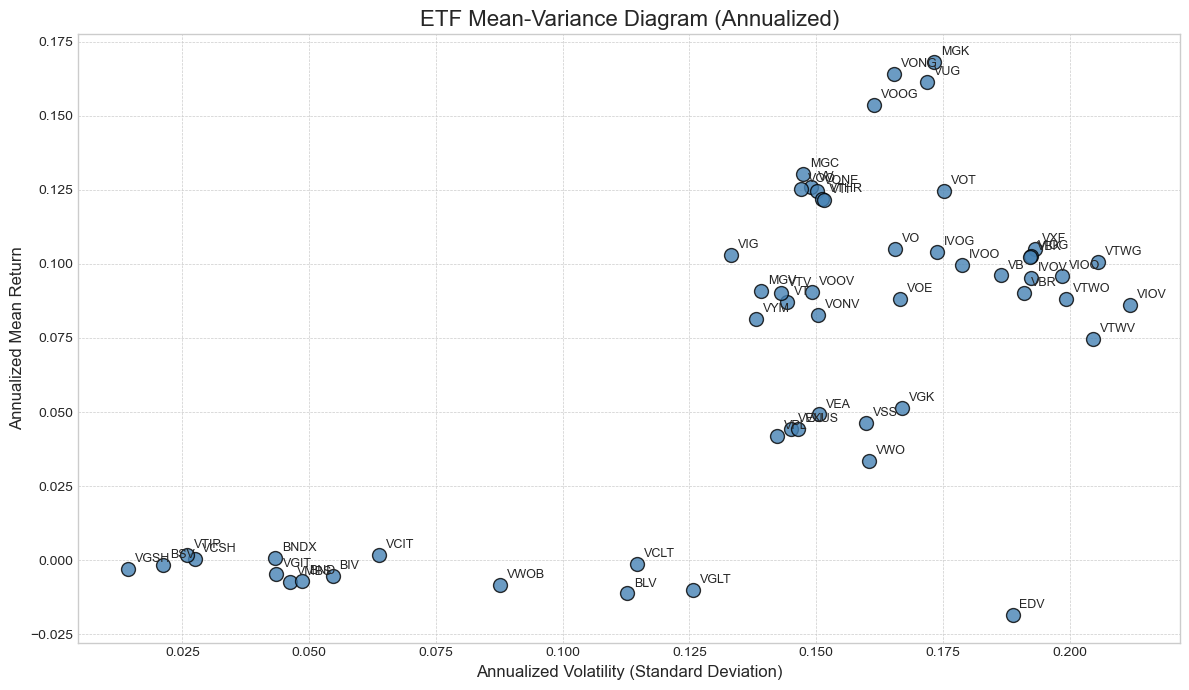

In [104]:
# Calculate annualized mean return and standard deviation
mean_returns = returns_monthly.mean() * 12  # 12 months in a year
volatility = returns_monthly.std() * np.sqrt(12)

# Create the scatter plot
plt.figure(figsize=(12, 7))
plt.scatter(volatility, mean_returns, color='steelblue', edgecolors='black', s=100, alpha=0.8)

# Annotate each ETF
for i, symbol in enumerate(etf_symbols):
    plt.annotate(symbol,
                 (volatility.iloc[i], mean_returns.iloc[i]),
                 textcoords="offset points",
                 xytext=(5, 5),
                 ha='left', fontsize=9)

# Formatting the plot
plt.title("ETF Mean-Variance Diagram (Annualized)", fontsize=16)
plt.xlabel("Annualized Volatility (Standard Deviation)", fontsize=12)
plt.ylabel("Annualized Mean Return", fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

There is quite a big variation between ETFs.  Some ETFs have very low historic returns, like VCIT, the intermediate corporate bonds ETFs, but also low volatility.  That means, these ETFs are expected to have a small put relatively consistent return over time.  On the other hand, ETFs like MGK, Mega Cap Growth, have experienced very high returns over the past 10 year (more than 17% p.a. on average!), but they were also enormously volatile and risky.  

The individual volatility of assets is only partially useful.  What is more interesting is how assets co-move with other assets over time.  So, let us have a look at the covariance between ETFs.

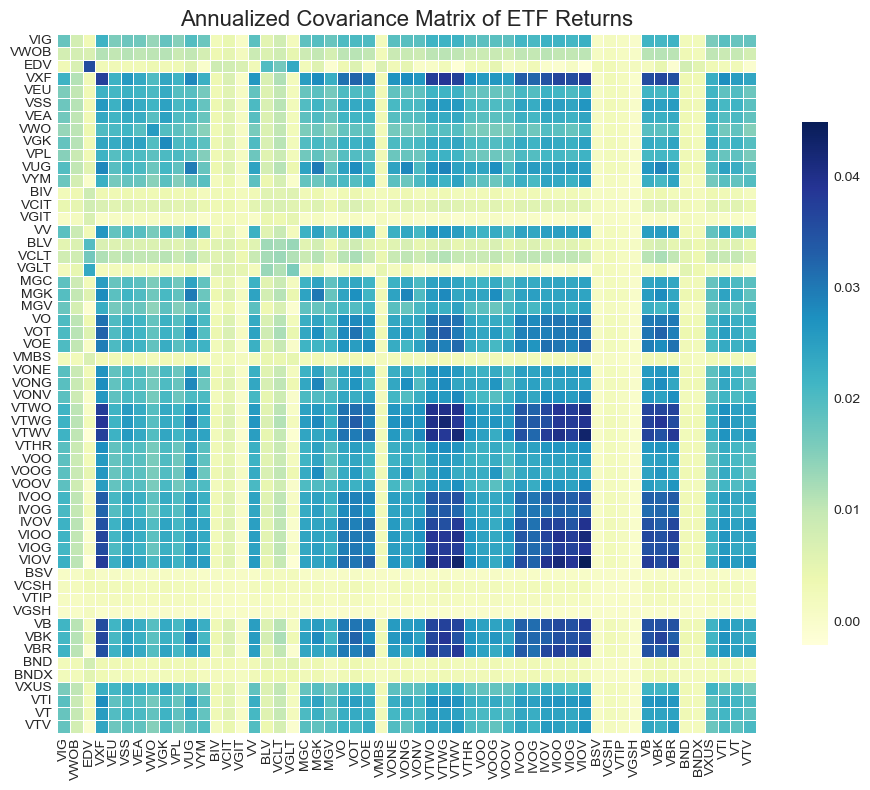

In [105]:
# Compute covariance matrix (annualized)
covariance_matrix = returns_monthly.cov() * 12

plt.figure(figsize=(10, 8))
sns.heatmap(covariance_matrix,
            annot=False, fmt=".3f",
            cmap="YlGnBu",
            xticklabels=etf_symbols,
            yticklabels=etf_symbols,
            square=True, linewidths=0.5,
            cbar_kws={"shrink": 0.75})

plt.title("Annualized Covariance Matrix of ETF Returns", fontsize=16)
plt.tight_layout()
plt.show()

The covariance is quite widespread, just like the variance in the diagonal.  Looking at the matrix, we actually can understand why portfolio optimization (and asset pricing in general) is focused on the covariance of assets.  There are only 55 elements in the diagonal (the variance of assets), but 55*54 elements everywhere else representing how each asset co-moves with each other assets.  So, it is much more important how asset co-move with other assets rather than how volatile it is by itself, especially when we combine assets to portfolio. 

Covariances are less intuitive than correlations, especially since correlations are bound between -1 and 1.  So, let's also have a look at the correlation matrix of the ETFs.

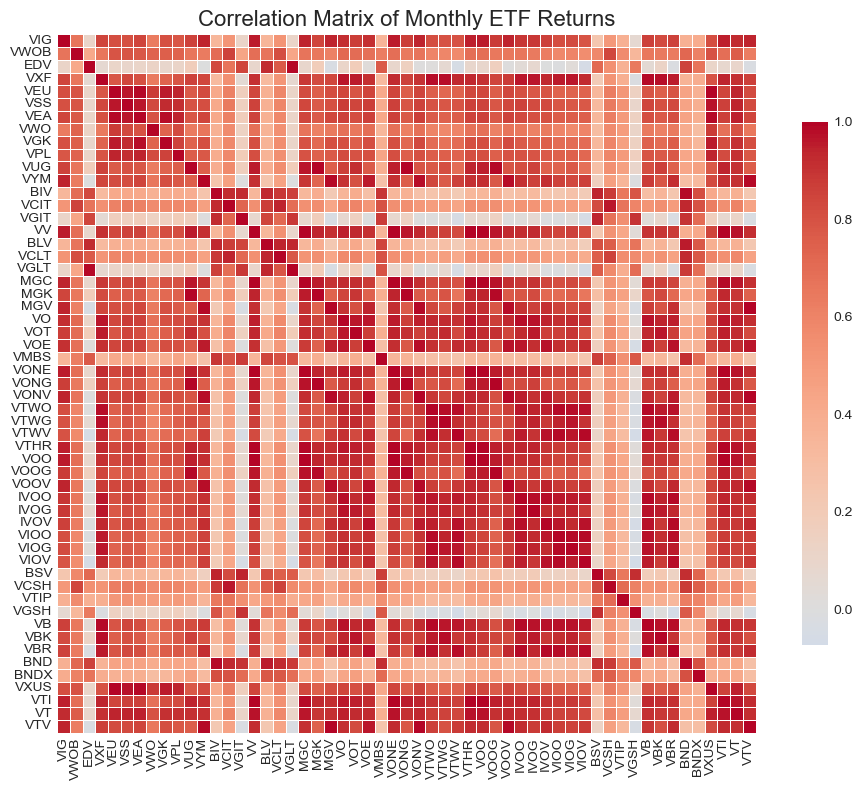

In [106]:
# Compute correlation matrix
correlation_matrix = returns_monthly.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix,
            annot=False, fmt=".2f",
            cmap="coolwarm", center=0,
            xticklabels=etf_symbols,
            yticklabels=etf_symbols,
            square=True, linewidths=0.5,
            cbar_kws={"shrink": 0.75})

plt.title("Correlation Matrix of Monthly ETF Returns", fontsize=16)
plt.tight_layout()
plt.show()

We already know assets have varying degrees of correlation from the covariance matrix, but the correlation matrix tells us one additional fact: no assets are perfectly correlated with each other (they would have a deep red color like the diagonal with correlation coefficient 1).  

This means that combinations of assets will have a lower variance than the weighted average of the variances.  To see why, consider the standard deviation of ETF 1 and ETF 2, $\sigma_1$ and $\sigma_2$, and portfolio weights $w_1$ and $w_2$, where the assets are not perfectly correlated.

The portfolio variance of two assets is given by:

$$
\sigma_p^2 = w_1^2 \sigma_1^2 + w_2^2 \sigma_2^2 + 2w_1 w_2 \rho_{12} \sigma_1 \sigma_2
$$

Since the correlation $\rho_{12} < 1$, i.e., ETF 1 and ETF 2 do not move perfectly together, the portfolio variance is **smaller** than the square of the weighted average of the standard deviations of the two ETFs, and thus also less than the average of the individual variances in most cases: 

$$
\sigma_p^2 < w_1^2 \sigma_1^2 + w_2^2 \sigma_2^2  + 2w_1 w_2 \sigma_1 \sigma_2 = (w_1 \sigma_1 + w_2 \sigma_2)^2
$$

For the expected returns, this is not true.  The expected return is a weighted average of the individual expected returns of the ETFs, $\mu_1$ and $\mu_2$.

$$
\mathbb{E}[R_p] = w_1 \mu_1 + w_2 \mu_2
$$

This is the idea behind **diversification**: by combining assets that are not perfectly correlated, the portfolio’s overall variance (risk) becomes lower than the average of the individual asset variances.  In other words, diversification helps smooth out the ups and downs, because not all assets move together.

Now we understand why diversification helps us when building portfolios to reduce risk and we can try to find optimal portfolios that reduce the variance for a given expected return target, or maximize the expected return for a volatility/risk level we are willing to accept.

### 3. Mean‑Variance Optimization

In this section, we will define the efficient frontier based on the historic average returns and covariances of the ETF and find our optimal portfolio that matches VOO.  We will explore different regularization and shrinkage estimators for the mean and covariance.  Our take-away from this section: the optimal portfolio is a combination of short-term Treasury ETF and the Russell 1000 Growth ETF. 

The basic problem of finding the best portfolios for a given expected return goes back to the classic [Markowitz (1952)](https://www.jstor.org/stable/2975974) problem:

$$
\min_{\mathbf{w}} \; \tfrac{1}{2} \mathbf{w}^\top \Sigma \mathbf{w}
\quad \text{subject to} \quad
\mathbf{w}^\top \mathbf{1} = 1, \quad
\mathbf{w}^\top \mu = \mu^*.
$$

Quite straightforward: to objective is to find portfolio weights $\mathbf{w}$ for the ETFs that minimize the variance of the portfolio while matching the expected return $\mu^*$.  The only other constraint is that the weights sum up to one.  That's all.  We can build a efficient frontier with this approach by defining a sequence of target expected returns $\mu^*$ for the portfolios, between the smallest and largest returns of the ETFs, and solve for the portfolio with minimum variance for each target $\mu^*$.  Since we are only dealing with first and second moments, so nothing of higher order than to the power of two, the minimization problem is convex and we can find unique portfolio weights that minimize the variance.

Note that since we have a nice quadratic problem, we can use the [CVXOPT Quadratic Programming solver](https://cvxopt.org/userguide/coneprog.html?highlight=cvxopt%20solvers%20qp#quadratic-programming) to find the solution to the program above.  We only need to translate the conditions into the proper vectors and matrices that the optimizer expects.

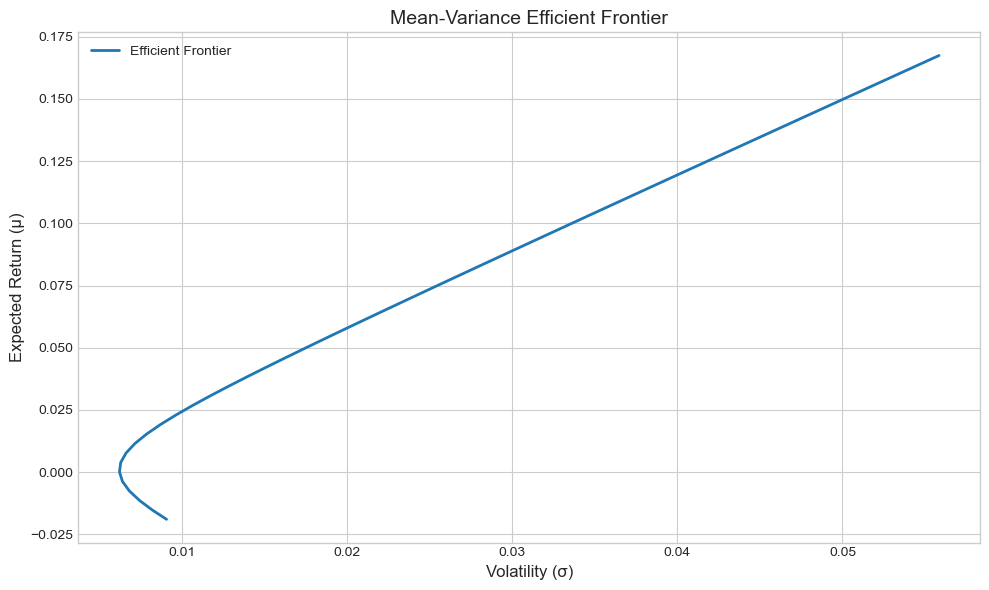

In [107]:
# These are the two key inputs for Markowitz portfolio optimization.
# 1. Expected Returns (mu): The anticipated annualized return for each asset.
# 2. Covariance Matrix (Sigma): A measure of how asset returns move together.

# Calculate historical annualized mean returns, net of expense ratios
annual_mu_sample = (returns_monthly.mean().values * 12) - expense_vector

# The sample covariance matrix is calculated from historical returns and annualized
sample_cov = returns_monthly.cov().values
annual_cov_sample = sample_cov * 12


def efficient_frontier_markowitz(expected_returns, covariance_matrix, n_points=50):
    """
    Computes the mean-variance efficient frontier using classic Markowitz optimization.

    Args:
        expected_returns (np.array): Vector of expected returns (annualized).
        covariance_matrix (np.array): Covariance matrix of returns (annualized).
        n_points (int): Number of portfolios to calculate along the frontier.

    Returns:
        dict: Contains lists of 'mu', 'sigma', and 'weights' for each portfolio.
    """
    n_assets = len(expected_returns)
    frontier = {"mu": [], "sigma": [], "weights": []}

    # Define QP parameters that don't change in the loop
    P = opt.matrix(covariance_matrix)
    q = opt.matrix(np.zeros(n_assets))
    
    # Equality constraint matrix A: one row for expected return, one for weights summing to 1
    A = opt.matrix(np.vstack([expected_returns, np.ones(n_assets)]))
    
    # Range of target returns
    target_mus = np.linspace(expected_returns.min(), expected_returns.max(), n_points)

    for mu_target in target_mus:
        b = opt.matrix([mu_target, 1.0])  # RHS of constraints
        try:
            sol = opt.solvers.qp(P, q, None, None, A, b)
            if sol['status'] == 'optimal':
                w = np.array(sol['x']).flatten()
                mu = w @ expected_returns
                sigma = np.sqrt(w @ covariance_matrix @ w)
                frontier["mu"].append(mu)
                frontier["sigma"].append(sigma)
                frontier["weights"].append(w)
        except:
            continue

    return frontier

# Compute the frontier
frontier_data = efficient_frontier_markowitz(annual_mu_sample, annual_cov_sample)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(frontier_data["sigma"], frontier_data["mu"], lw=2, label="Efficient Frontier")
plt.xlabel("Volatility (σ)", fontsize=12)
plt.ylabel("Expected Return (μ)", fontsize=12)
plt.title("Mean-Variance Efficient Frontier", fontsize=14)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


This looks exactly as expected!  The efficient frontier has the shape of a parabola on it's side, because eventually the variance of a portfolio is a sum over squared deviations from the mean.  We also see that for some volatility level we actually have two solution, a lower and an upper arm of the frontier (due to the quadratic nature of the problem).  The lower arm economically makes no sense, so we will prune the results later to remove it; practically, if an investor is willing to accept a level of risk (volatility) that has two optimal portfolios, he would only choose portfolios from the upper arm with highest return.

We eventually want to select optimal portfolios from the efficient frontier that minimize the variance for a specific target expected return, or that maximize the return for a given level of risk.  As benchmark for our optimal portfolios, we can look at VOO, the S&P 500 ETF.  VOO is one of the largest ETFs worldwide and the S&P 500 is frequently used as a proxy for the overall market portfolio, so it makes sense to use the returns and volatility of VOO as targets for our portfolio optimization.  

Let's first find the portfolio weights of the efficient frontier portfolio that has the same expected return as VOO.

In [108]:
voo_returns_monthly = returns_monthly["VOO"]
voo_mu_annual = voo_returns_monthly.mean() * 12 - etf_expense_map.get("VOO", 0.0)
voo_sigma_annual = voo_returns_monthly.std() * np.sqrt(12)


def select_portfolio(frontier, target_metric, target_value):
    """
    Selects a portfolio from the efficient frontier closest to a target value.

    Args:
        frontier (dict): The efficient frontier dictionary.
        target_metric (str): The metric to match ('mu' or 'sigma').
        target_value (float): The target return or volatility.

    Returns:
        tuple: Index and weights of the selected portfolio, or (None, None).
    """
    if not frontier[target_metric]:
        return None, None
    diffs = np.abs(np.array(frontier[target_metric]) - target_value)
    idx = diffs.argmin()
    return idx, frontier["weights"][idx]

# Select matching portfolio
idx, weights_voo_match = select_portfolio(frontier_data, target_metric="mu", target_value=voo_mu_annual)

To get a sense of how the optimal portfolio looks like, we can print the top and bottom three portfolio weights, the smallest weights in absolute terms, and plot weights.


Comparison with VOO:
VOO - Expected Return: 12.49%, Volatility: 14.70%
Selected Portfolio - Expected Return: 12.56%, Volatility: 4.20%

Top 3 Weights in Selected Portfolio:
VCIT: 334.99%
VB: 290.88%
BSV: 279.66%

Bottom 3 Weights in Selected Portfolio:
BIV: -264.75%
VV: -265.53%
BND: -674.07%

3 Smallest Absolute Weights in Selected Portfolio:
VGSH: -0.77%
VIG: 2.11%
VTWV: 3.51%


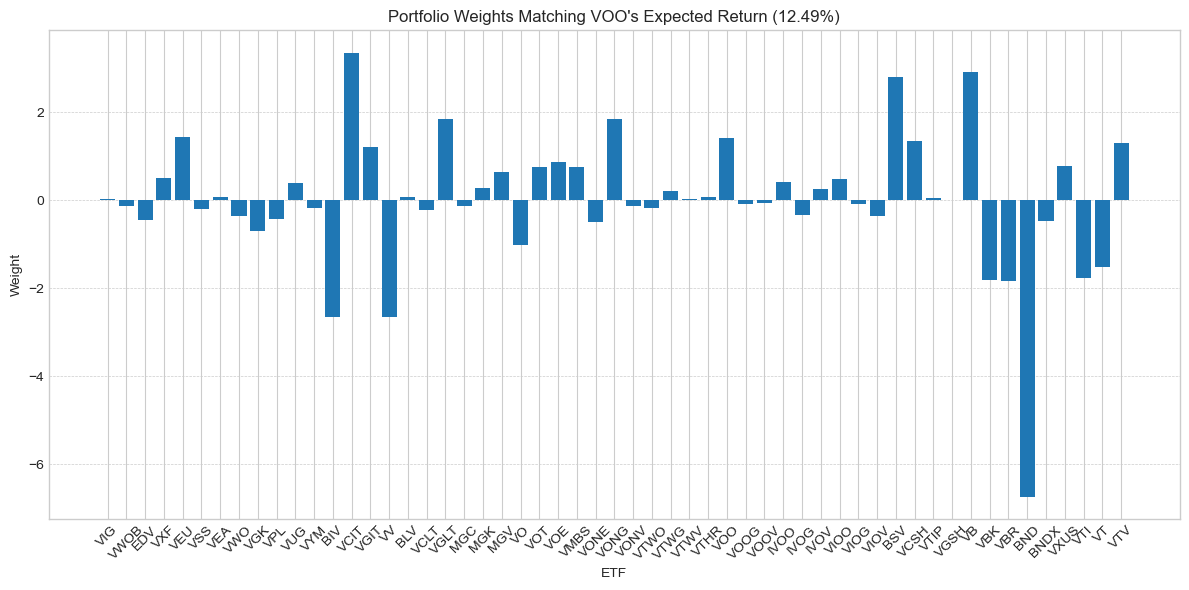

In [109]:
if weights_voo_match is not None:
    selected_mu = frontier_data["mu"][idx]
    selected_sigma = frontier_data["sigma"][idx]

    print(f"\nComparison with VOO:")
    print(f"VOO - Expected Return: {voo_mu_annual:.2%}, Volatility: {voo_sigma_annual:.2%}")
    print(f"Selected Portfolio - Expected Return: {selected_mu:.2%}, Volatility: {selected_sigma:.2%}")

    # Zip symbols and weights, then sort by weight
    weights_named = list(zip(etf_symbols, weights_voo_match))
    sorted_weights = sorted(weights_named, key=lambda x: x[1], reverse=True)
    sorted_by_abs = sorted(weights_named, key=lambda x: abs(x[1]))

    print("\nTop 3 Weights in Selected Portfolio:")
    for symbol, weight in sorted_weights[:3]:
        print(f"{symbol}: {weight:.2%}")

    print("\nBottom 3 Weights in Selected Portfolio:")
    for symbol, weight in sorted_weights[-3:]:
        print(f"{symbol}: {weight:.2%}")

    print("\n3 Smallest Absolute Weights in Selected Portfolio:")
    for symbol, weight in sorted_by_abs[:3]:
        print(f"{symbol}: {weight:.2%}")


    plt.figure(figsize=(12, 6))
    plt.bar(etf_symbols, weights_voo_match)
    plt.title(f"Portfolio Weights Matching VOO's Expected Return ({voo_mu_annual:.2%})")
    plt.ylabel("Weight")
    plt.xlabel("ETF")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()
else:
    print("No matching portfolio found on the frontier.")

This is unfortunately a typical result for simple portfolio optimization: the expected volatility for the optimal portfolio is much lower than for VOOs, but it is practically infeasible as there are many assets with extreme weights in the optimal portfolio.  The Total Bond Market ETF (BND), for example, should have a weight of more than -600%, while the Intermediate Corporate Bond ETF (VCIT) should have a weight of more than 300%!  In other words, if you want to invest $1, you should short-sell $6 of BND and use the proceeds to purchase $3 of VCIT, etc.  This is not really feasible for a retail investor.  

We could also encounter a second problem: there are many portfolios with quite small weights, such as the Short-Term Inflation-Protected Securities ETF (VTIP) having a weight of around 3%.  This is not very large and it makes the implementation of trading strategies difficult since we have to purchase many ETFs with tiny weights.

A third problem we have not mentioned yet is estimation error.  Given how extreme the weights are, even small errors in the estimated expected return or the covariance matrix can lead to substantial changes in the optimal portfolio allocations.  


To account for these problem, we can try the following:
- **Add long-only constraints**: we can add an additional constraint to make sure each portfolio weight is between zero and one.  This is much more realistic for an individual investor.

- **Apply L1 regularization**: we can adapt the idea from the LASSO regression and add a penalty for large and non-zero weights, making it more likely that the optimization shrinks more weights to zero, reducing the number of assets in the optimal portfolio.  We need to decide on a the meta-parameter for the penalty, $\lambda$, which we can do via a simple grid search.  Choosing to small of a $\lambda$ and we might have too many small ETFs in the optimal portfolio, choosing to large a $\lambda$ and we introduce too much of a bias and the portfolio is not optimal anymore.  So, let's look for the $\lambda$ that maximizes the Sharpe ratio, expected return over sigma, for the optimal portfolio that matches VOO's expected return.  The Sharpe ratio is a measure of the price of risk, so it makes sense to choose the highest possible return that we can get for one unit of risk, i.e., volatility.

- **Apply shrinkage methods to $\mu$ and $\sigma$**: to reduce the effect of estimation error in the expected return and the covariance matrix, we can apply shrinkage methods for both.  We can try James-Stein for the expected return and Ledoit-Wolf for the covariance matrix.  Both shrink the sample estimates to a reasonable target, thus reducing estimation error and noise of the estimates.  James-Stein shrinks the sample means of the ETFs to the grand mean over all ETFs, and Ledoit-Wolf shrinks the covariance matrix to the identify matrix.

Useful sources on implementing the LASSO regularization in quadratic programming are [Stéphane Caron's blog](https://scaron.info/blog/lasso-regularization-in-quadratic-programming.html) and the original paper by Rovert Tibshirani, [*Regression Shrinkage and Selection via the Lasso*](https://academic.oup.com/jrsssb/article-pdf/58/1/267/49098631/jrsssb_58_1_267.pdf), .

We can now expand the optimization problem as follows, with $\mu$ and $\Sigma$ either the sample mean and covariance or by the shrunk versions.

#### Objective

$$
\min_{\mathbf{w}, \mathbf{u}} \quad \tfrac{1}{2} \mathbf{w}^\top \Sigma \mathbf{w} + \lambda \sum_{i=1}^n u_i
$$


#### Constraints

1. **L1 Reformulation (Enforce $ u_i \ge |w_i| $)**

$$
w_i - u_i \le 0 \quad \text{(i.e., } u_i \ge w_i \text{)}
$$

$$
-w_i - u_i \le 0 \quad \text{(i.e., } u_i \ge -w_i \text{)}
$$

2. **Long-only Constraints**

$$
0 \le w_i \le 1
$$

3. **Budget Constraint**

$$
\sum_{i=1}^n w_i = 1
$$

4. **Target Return Constraint**

$$
\sum_{i=1}^n w_i \mu_i = \mu^*
$$


In [110]:
def efficient_frontier(
    covariance_matrix, expected_returns, n_points=50, lambda_l1=0.0
):
    """
    Calculates the efficient frontier using the Markowitz model with optional L1
    regularization (LASSO). This encourages sparse portfolios by driving the
    weights of less important assets to exactly zero.

    This function reformulates the L1-regularized problem into a standard
    Quadratic Program (QP) that can be solved efficiently by CVXOPT.

    Args:
        covariance_matrix (np.array): Annualized covariance matrix of asset returns.
        expected_returns (np.array): Annualized vector of expected asset returns.
        n_points (int): The number of points to calculate along the frontier.
        lambda_l1 (float): The regularization strength. Higher values lead to
                           more sparsity (more zero weights).

    Returns:
        dict: A dictionary containing returns ('mu'), volatilities ('sigma'),
              and portfolio weights ('weights') for each point on the frontier.
    """
    n_assets = len(expected_returns)

    # We solve for a combined vector x = [w, u] of size 2*n_assets, where:
    # w: the standard portfolio weights (n_assets)
    # u: auxiliary variables to handle the absolute value |w_i| (n_assets)
    # The objective becomes: minimize 0.5*w'.Cov.w + lambda*1'.u
    # Subject to: w-u <= 0, -w-u <= 0 (which implies u >= |w|)

    # 1. The Quadratic Term P
    # Only involves 'w', so P_new has the original covariance_matrix in the
    # top-left block and zeros elsewhere.
    P_l1 = opt.matrix(
        np.block(
            [
                [covariance_matrix, np.zeros((n_assets, n_assets))],
                [np.zeros((n_assets, n_assets)), np.zeros((n_assets, n_assets))],
            ]
        )
    )

    # 2. The Linear Term q
    # The L1 penalty `lambda * sum(|w_i|)` is reformulated as `lambda * sum(u_i)`.
    # This becomes the linear part of the objective, q'.x.
    q_l1 = opt.matrix(np.concatenate([np.zeros(n_assets), lambda_l1 * np.ones(n_assets)]))

    # 3. The Inequality Constraints G and h (for Gx <= h)
    # These enforce u_i >= |w_i| and the original box constraints 0 <= w_i <= 1.
    I = np.eye(n_assets)
    Z = np.zeros((n_assets, n_assets))
    G_l1 = opt.matrix(
        np.block(
            [
                [I, -I],  # For w_i - u_i <= 0
                [-I, -I],  # For -w_i - u_i <= 0
                [-I, Z],  # For -w_i <= 0 (w_i >= 0)
                [I, Z],  # For w_i <= 1
            ]
        )
    )
    h_l1 = opt.matrix(np.concatenate([np.zeros(3 * n_assets), np.ones(n_assets)]))

    # 4. The Equality Constraints A and b (for Ax = b)
    # These constraints (sum of weights = 1, portfolio return = target)
    # only apply to the 'w' part of our variable vector 'x'.
    A_l1 = opt.matrix(
        np.block(
            [
                [expected_returns, np.zeros(n_assets)],
                [np.ones(n_assets), np.zeros(n_assets)],
            ]
        )
    )

    # Iterate through a range of target returns to trace the frontier
    target_mus = np.linspace(expected_returns.min(), expected_returns.max(), n_points)
    frontier = {"mu": [], "sigma": [], "weights": []}
    for target_mu in target_mus:
        # The RHS of the equality constraint
        b_l1 = opt.matrix([target_mu, 1.0])
        try:
            # Solve the larger, reformulated QP problem
            solution = opt.solvers.qp(P_l1, q_l1, G_l1, h_l1, A_l1, b_l1)
            if solution["status"] == "optimal":
                # Extract only the weights 'w' from the solution vector 'x'.
                weights = np.array(solution["x"][:n_assets]).flatten()
                # Clean up tiny weights due to solver precision
                weights[np.abs(weights) < 1e-7] = 0
                # Re-normalize to ensure sum is exactly 1 after cleanup
                if np.sum(weights) > 0:
                    weights /= np.sum(weights)

                sigma = np.sqrt(weights.T @ covariance_matrix @ weights)
                actual_mu = weights.T @ expected_returns
                frontier["mu"].append(actual_mu)
                frontier["sigma"].append(sigma)
                frontier["weights"].append(weights)
        except ValueError:
            # Solver may fail if no feasible solution exists for a target return
            pass
    return frontier


def prune_frontier(frontier):
    """
    Removes dominated portfolios from a mean-variance frontier, keeping only
    the efficient upper arm where return increases with volatility.

    Args:
        frontier (dict): A dict with keys 'sigma', 'mu', 'weights'.

    Returns:
        dict: A pruned frontier with the same structure.
    """
    vol = np.asarray(frontier["sigma"])
    ret = np.asarray(frontier["mu"])
    wlist = list(frontier["weights"])

    # 1) Sort by volatility (ascending)
    order = np.argsort(vol)
    vol, ret = vol[order], ret[order]
    wlist = [wlist[i] for i in order]

    # 2) Walk from left to right, keeping only points with strictly increasing returns
    keep_idx = []
    last_best_ret = -np.inf
    for i in range(len(ret)):
        if ret[i] > last_best_ret + 1e-12:
            keep_idx.append(i)
            last_best_ret = ret[i]

    # 3) Assemble the pruned frontier
    return {
        "sigma": vol[keep_idx].tolist(),
        "mu": ret[keep_idx].tolist(),
        "weights": [wlist[i] for i in keep_idx],
    }

We need to still define the optimal L1 penalty term for regularization, $\lambda$.  Too large a parameter promotes sparsity but introduces too much bias, while too small a parameter being ineffective in removing small weights.  We will do a grid search and find the parameter that maximizes the Sharpe ratio for the optimal portfolio that matches VOO's volatility.  We can add robustness to the search by using a training-test split to compare $\lambda$'s based on out-of-sample performance.   

In [111]:
#  Grid-Search for the "Best" L1-Penalty (lambda_1)
# - A simple train/validation split is used (last 20% = validation).
# - The metric for "best" is the out-of-sample Sharpe Ratio.
# - The portfolio on the frontier is chosen by matching VOO's volatility.
print("\n--- Grid-searching for optimal L1 penalty (lambda) ---")
lambda_grid = np.logspace(-6, -1, 11)  # 11 points: 1e-6 to 1e-1
val_frac = 0.20
target_sig = voo_mu_annual

# Split data into training and validation sets
T = len(returns_monthly)
split_idx = int((1 - val_frac) * T)
ret_train = returns_monthly.iloc[:split_idx]
ret_val = returns_monthly.iloc[split_idx:]

mu_train = ret_train.mean().values * 12
cov_train = ret_train.cov().values * 12
mu_val = ret_val.mean().values * 12
cov_val = ret_val.cov().values * 12


def sharpe_ratio(mu, sigma):
    """
    Calculates annualized Sharpe ratio from annualized decimal returns.
    (Assumes risk-free rate = 0).
    """
    return mu / sigma if sigma > 0 else np.nan


def eval_lambda(lam):
    """Fit frontier with lambda_1=lam on train-set, score on validation."""
    front = efficient_frontier(cov_train, mu_train, n_points=30, lambda_l1=lam)
    _, w = select_portfolio(front, "mu", target_sig)
    if w is None:
        return np.nan
    mu_out_of_sample = w @ mu_val
    sigma_out_of_sample = np.sqrt(w @ cov_val @ w)
    return sharpe_ratio(mu_out_of_sample, sigma_out_of_sample)


# Perform grid search
scores = [eval_lambda(lam) for lam in lambda_grid]
best_idx = int(np.nanargmax(scores))
best_lambda = float(lambda_grid[best_idx])

# Report results
print(f"lambda_1 candidates: {[f'{l:.5g}' for l in lambda_grid]}")
print(f"Validation Sharpe: {[f'{s:.3f}' for s in scores]}")
print(f"\n-> Selected optimal lambda_1 = {best_lambda:.5g}\n")


--- Grid-searching for optimal L1 penalty (lambda) ---
lambda_1 candidates: ['1e-06', '3.1623e-06', '1e-05', '3.1623e-05', '0.0001', '0.00031623', '0.001', '0.0031623', '0.01', '0.031623', '0.1']
Validation Sharpe: ['1.832', '1.832', '1.832', '1.832', '1.832', '1.832', '1.832', '1.832', '1.832', '1.832', '1.832']

-> Selected optimal lambda_1 = 0.031623



Before we implement the portfolio optimization with shrinkage estimates for $\mu$ and $\Sigma$, we should understand what the shrinkage estimators are and see how they compare to the sample mean and covariance.

There are many sources for shrinkage estimators, for James-Stein, for example, these [lecture notes by Maxime Cauchois](https://web.stanford.edu/class/stats50/files/STATS_50_Regression_to_the_mean.pdf) provide a nice summary, or the paper by Eric Bennett Rasmusen, [*Understanding Shrinkage Estimators: From Zero to Oracle to James-Stein*](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2675681).  For Ledoit-Wolf, the original paper, [*A well-conditioned estimator for large-dimensional covariance matrices*](https://perso.ens-lyon.fr/patrick.flandrin/LedoitWolf_JMA2004.pdf), is a solid source, but also the [sklean documentation about covariance shrinkage](https://scikit-learn.org/stable/modules/covariance.html#shrunk-covariance) is very useful. 

The James-Stein estimator is a famous and straightforward approach to use Bayesian-style shrinkage to the expected return.  It's formula is data-driven and basically tries to shrink the sample means for each asset towards the grand mean.  I use the following formula:

$$
\hat\mu^{\text{JS}}_i \;=\; (1-\lambda)\,\hat\mu_i \;+\; \lambda\,\bar\mu,
\qquad
\lambda \;=\; \min\!\Bigl[1,\;\frac{(p-2)\,s^{2}}{\sum_{j=1}^{p}(\hat\mu_j-\bar\mu)^{2}}\Bigr]
$$

with $\bar\mu=\tfrac{1}{p}\sum_{j=1}^{p}\hat\mu_j$ and $s^{2}=\tfrac{1}{p-1}\sum_{j=1}^{p}(\hat\mu_j-\bar\mu)^{2}$.  $\bar\mu$ is nothing but the grand mean, the average return across all expected ETF returns, and $s^{2}$ is the estimated variance of the individual ETF means.  The James-Stein estimator thus intuitively shrinks more towards the grand mean if there is more uncertainty about the each estimators (larger $s^{2}$) or when the estimates for $\mu$ are closer around the grand mean (smaller $\sum_{j=1}^{p}(\hat\mu_j-\bar\mu)^{2}$).

One assumptions here is that all estimators for the mean return have the same variance, thus we can use one $s^{2}$ for the approach.  This is probably not correct, but a useful and simple starting point.  We further see that $\lambda$ simplifies to $\frac{p-2}{p-1}$, since $s^{2}$ is estimated from the same data as the denominator.  This is a big simplification, more accurate would be to use the estimated variance of each ETF's mean, so that ETFs with more uncertainty about the expected return are shrunk closer to the grand mean, but for initial understanding how shrinkage affects our portfolio optimization, this is enough.  


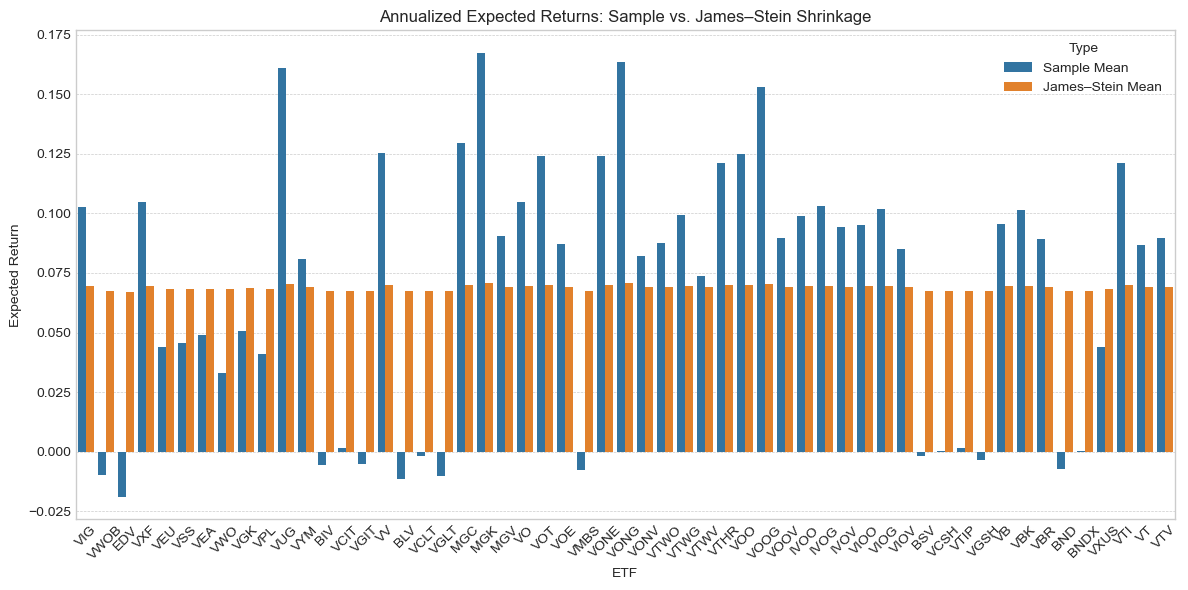

In [112]:
def james_stein_shrinkage(mu_hat):
    """
    Applies James–Stein shrinkage to the vector of sample means.

    Args:
        mu_hat (np.ndarray): Sample mean returns (shape: [n_assets]).

    Returns:
        np.ndarray: Shrunk mean returns.
    """
    p = len(mu_hat)
    mu_bar = np.mean(mu_hat)
    numerator = (p - 2) * np.var(mu_hat, ddof=1)
    denominator = np.sum((mu_hat - mu_bar) ** 2)
    
    # Guard against division by zero
    if denominator == 0:
        lambda_js = 0
    else:
        lambda_js = min(1, max(0, numerator / denominator))

    mu_shrunk = (1 - lambda_js) * mu_hat + lambda_js * mu_bar
    return mu_shrunk


# Mean shrinkage
annual_mu_shrunk = james_stein_shrinkage(annual_mu_sample)

# Create DataFrame for plotting
df_mu = pd.DataFrame({
    "ETF": etf_symbols,
    "Sample Mean": annual_mu_sample,
    "James–Stein Mean": annual_mu_shrunk
})

# Melt to long format for seaborn
df_mu_melted = df_mu.melt(id_vars="ETF", var_name="Type", value_name="Return")

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_mu_melted, x="ETF", y="Return", hue="Type")
plt.xticks(rotation=45)
plt.title("Annualized Expected Returns: Sample vs. James–Stein Shrinkage")
plt.ylabel("Expected Return")
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


James-Stein is too aggressive and shrinks the annual mean to severely towards the grand mean.  I appears that since the sample means are no too widely distributed, James-Stein shrinks them relatively quickly towards the grand mean.

Instead of the harsh shrinkage by James-Stein, let's use a more gentle shrinkage parameter to preserves more of the dispersion of the individual expected returns of the ETFs.

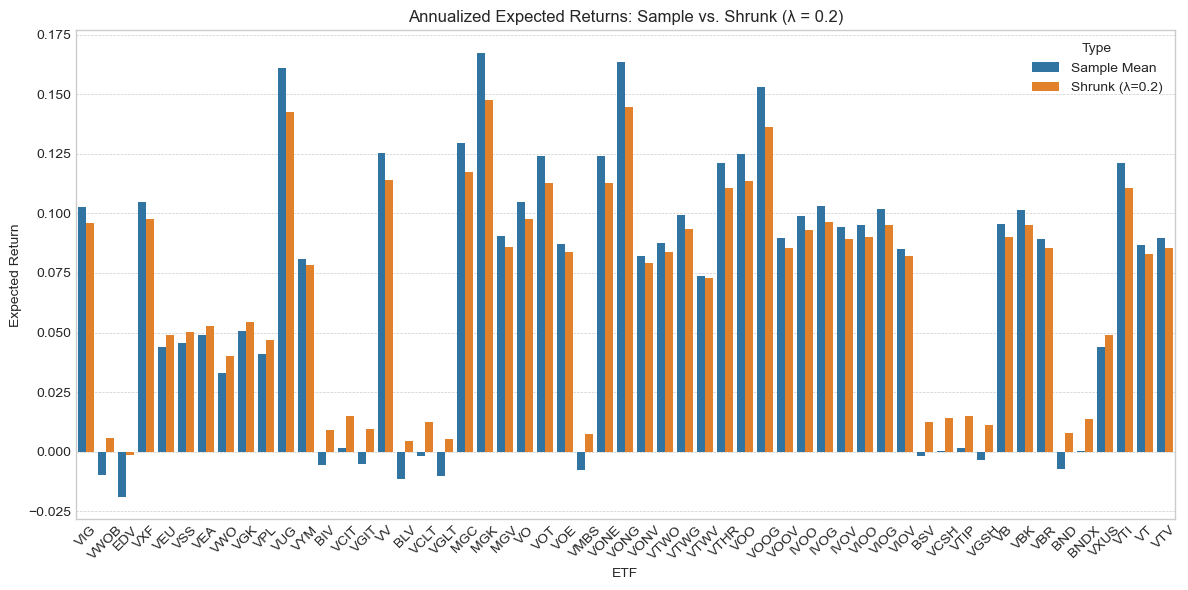

In [113]:
lambda_small = 0.2  # small shrinkage strength
mu_grand = np.mean(annual_mu_sample)
annual_mu_shrunk_partial = (1 - lambda_small) * annual_mu_sample + lambda_small * mu_grand

# Build DataFrame
df_mu_partial = pd.DataFrame({
    "ETF": etf_symbols,
    "Sample Mean": annual_mu_sample,
    f"Shrunk (λ={lambda_small})": annual_mu_shrunk_partial
})

# Melt to long format for plotting
df_mu_melted = df_mu_partial.melt(id_vars="ETF", var_name="Type", value_name="Return")

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_mu_melted, x="ETF", y="Return", hue="Type")
plt.xticks(rotation=45)
plt.title(f"Annualized Expected Returns: Sample vs. Shrunk (λ = {lambda_small})")
plt.ylabel("Expected Return")
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

Next, we can shrink the covariance using Ledoit-Wolf.  The basic approach here can also be viewed as Bayesian-like shrinkage for the covariance matrix towards the a grand-mean type identity matrix that has the average variance in the diagonal.  The precise formula for the weights is quite complicated, but it is worth noting that the weight on the diagonal target matrix decreases as the sample covariance matrix becomes more reliable.  The formula looks like this:

$$
\Sigma_{\text{LW}} = (1-\delta)\,S + \delta F,
\qquad
F = \bar{s}\,I,\qquad
\bar{s} = \frac{1}{p}\operatorname{tr}(S).
$$

* $S$ = sample covariance matrix
* $F$ = scaled identity matrix with the same average variance as $S$
* $0\le\delta\le1$ = data-driven shrinkage weight picked by the Ledoit-Wolf rule to minimize estimation error

Luckily, the implementation in Python is straightforward with the sklearn library.  We can compare the heat map of the raw and the shrunk estimators to see how much shrinkage affects our covariance matrix.

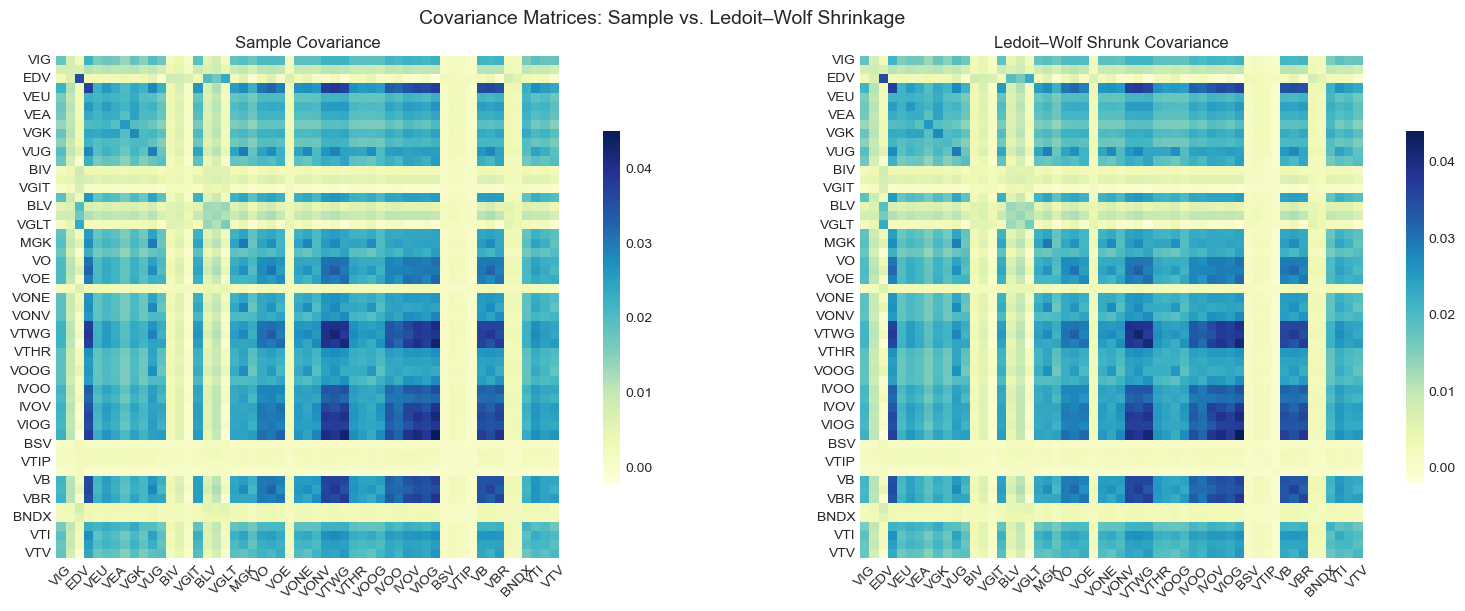

In [114]:
# Covariance shrinkage
lw = LedoitWolf().fit(returns_monthly.values)
annual_cov_shrunk = lw.covariance_ * 12

# Convert to DataFrames for heatmap comparison
df_cov_sample = pd.DataFrame(annual_cov_sample, index=etf_symbols, columns=etf_symbols)
df_cov_shrunk = pd.DataFrame(annual_cov_shrunk, index=etf_symbols, columns=etf_symbols)

# Plot side-by-side heatmaps
fig, axs = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)

sns.heatmap(df_cov_sample, cmap="YlGnBu", ax=axs[0], square=True, cbar_kws={"shrink": 0.7})
axs[0].set_title("Sample Covariance")

sns.heatmap(df_cov_shrunk, cmap="YlGnBu", ax=axs[1], square=True, cbar_kws={"shrink": 0.7})
axs[1].set_title("Ledoit–Wolf Shrunk Covariance")

for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.suptitle("Covariance Matrices: Sample vs. Ledoit–Wolf Shrinkage", fontsize=14)
plt.show()

Ledoit-Wolf barely changes the covariance matrix.  It seems the sample covariance matrix is already quite stable due to the 120 monthly observations for each ETF, so Ledoit-Wolf does not change much.

Finally, let us generate the efficient frontiers for each variant (raw, with L1 regularization, with mean shrunk, with covariance shrunk) and compare optimal portfolios that match VOO's expected mean or volatility.  For this, we can print the top weights for each optimal portfolio.

In [115]:
# Frontier using simple sample estimates
ef_raw = prune_frontier(
    efficient_frontier(annual_cov_sample, annual_mu_sample, n_points=FRONTIER_POINTS)
)
# Frontier using L1 regularization
ef_reg_l1 = prune_frontier(
    efficient_frontier(
        annual_cov_shrunk, annual_mu_sample, n_points=FRONTIER_POINTS, lambda_l1=best_lambda
    )
)
# Frontier using shrinkage-adjusted covariance
ef_shrunk = prune_frontier(
    efficient_frontier(annual_cov_shrunk, annual_mu_sample, n_points=FRONTIER_POINTS)
)
# Frontier using also shrinkage-adjusted means
ef_shrunk_mean = prune_frontier(
    efficient_frontier(annual_cov_shrunk, annual_mu_shrunk_partial, n_points=FRONTIER_POINTS)
)

# Find portfolios on each frontier matching the VOO benchmark's risk or return
_, w_mu_raw = select_portfolio(ef_raw, "mu", voo_mu_annual)
_, w_sigma_raw = select_portfolio(ef_raw, "sigma", voo_sigma_annual)
_, w_mu_reg_l1 = select_portfolio(ef_reg_l1, "mu", voo_mu_annual)
_, w_sigma_reg_l1 = select_portfolio(ef_reg_l1, "sigma", voo_sigma_annual)
_, w_mu_shrunk = select_portfolio(ef_shrunk, "mu", voo_mu_annual)
_, w_sigma_shrunk = select_portfolio(ef_shrunk, "sigma", voo_sigma_annual)
_, w_mu_shrunk_mean = select_portfolio(ef_shrunk_mean, "mu", voo_mu_annual)
_, w_sigma_shrunk_mean = select_portfolio(ef_shrunk_mean, "sigma", voo_sigma_annual)

# Display the composition of selected portfolios
portfolios_to_display = {
    "Raw (Return-Matched)": w_mu_raw,
    "Raw (Risk-Matched)": w_sigma_raw,
    "L1 Regularized (Return-Matched)": w_mu_reg_l1,
    "L1 Regularized (Risk-Matched)": w_sigma_reg_l1,
    "Shrunk Covariance (Return-Matched)": w_mu_shrunk,
    "Shrunk Covariance (Risk-Matched)": w_sigma_shrunk,
    "Shrunk Mean (Return-Matched)": w_mu_shrunk_mean,
    "Shrunk Mean (Risk-Matched)": w_sigma_shrunk_mean,
}

for label, weights in portfolios_to_display.items():
    if weights is not None:
        print(f"\nTop 3 ETFs for {label} Portfolio:")
        top_indices = np.argsort(weights)[-3:][::-1]
        for i in top_indices:
            if weights[i] > 0.001:  # Only show assets with meaningful weight
                symbol = etf_symbols[i]
                name = etf_name_map.get(symbol, "Unknown")
                print(f"  {symbol} ({name}): {weights[i]:.2%}")


Top 3 ETFs for Raw (Return-Matched) Portfolio:
  VONG (Russell 1000 Growth ETF): 77.35%
  VGSH (Short-Term Treasury ETF): 22.65%

Top 3 ETFs for Raw (Risk-Matched) Portfolio:
  VONG (Russell 1000 Growth ETF): 88.76%
  VGSH (Short-Term Treasury ETF): 11.24%

Top 3 ETFs for L1 Regularized (Return-Matched) Portfolio:
  VONG (Russell 1000 Growth ETF): 68.21%
  VGSH (Short-Term Treasury ETF): 22.87%
  MGK (Mega Cap Growth ETF): 8.92%

Top 3 ETFs for L1 Regularized (Risk-Matched) Portfolio:
  VONG (Russell 1000 Growth ETF): 77.29%
  VGSH (Short-Term Treasury ETF): 11.52%
  MGK (Mega Cap Growth ETF): 11.19%

Top 3 ETFs for Shrunk Covariance (Return-Matched) Portfolio:
  VONG (Russell 1000 Growth ETF): 68.21%
  VGSH (Short-Term Treasury ETF): 22.87%
  MGK (Mega Cap Growth ETF): 8.92%

Top 3 ETFs for Shrunk Covariance (Risk-Matched) Portfolio:
  VONG (Russell 1000 Growth ETF): 77.29%
  VGSH (Short-Term Treasury ETF): 11.52%
  MGK (Mega Cap Growth ETF): 11.19%

Top 3 ETFs for Shrunk Mean (Retur

We can also visually compare the efficient frontiers and how close the optimal portfolios are to the target VOO.

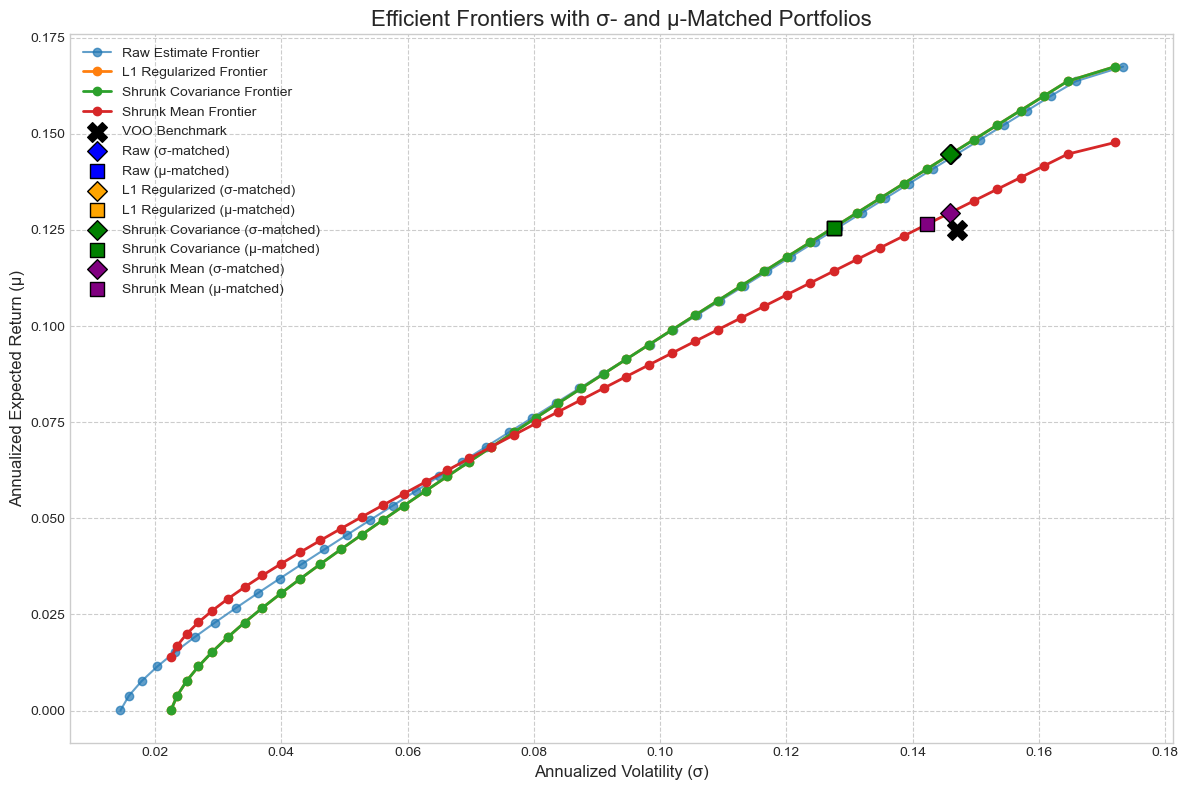

In [116]:
plt.figure(figsize=(12, 8))
plt.plot(ef_raw["sigma"], ef_raw["mu"], "o-", label="Raw Estimate Frontier", alpha=0.7)
plt.plot(ef_reg_l1["sigma"], ef_reg_l1["mu"], "o-", label="L1 Regularized Frontier", lw=2)
plt.plot(
    ef_shrunk["sigma"], ef_shrunk["mu"], "o-", label="Shrunk Covariance Frontier", lw=2
)
plt.plot(
    ef_shrunk_mean["sigma"], ef_shrunk_mean["mu"], "o-", label="Shrunk Mean Frontier", lw=2
)
# VOO benchmark
plt.scatter([voo_sigma_annual], [voo_mu_annual], color="black", marker="X", s=200, label="VOO Benchmark", zorder=5)

# Define portfolio styles
portfolios = [
    ("Raw", w_sigma_raw, w_mu_raw, annual_mu_sample, "blue"),
    ("L1 Regularized", w_sigma_reg_l1, w_mu_reg_l1, annual_mu_sample, "orange"),
    ("Shrunk Covariance", w_sigma_shrunk, w_mu_shrunk, annual_mu_sample, "green"),
    ("Shrunk Mean", w_sigma_shrunk_mean, w_mu_shrunk_mean, annual_mu_shrunk_partial, "purple"),
]

# Plot sigma- and mu-matched portfolios
for label, w_sigma, w_mu, mu_vec, color in portfolios:
    if w_sigma is not None:
        mu = w_sigma @ mu_vec
        sigma = np.sqrt(w_sigma @ annual_cov_shrunk @ w_sigma)
        plt.scatter(sigma, mu, marker="D", color=color, edgecolor="black", s=100, label=f"{label} (σ-matched)", zorder=4)

    if w_mu is not None:
        mu = w_mu @ mu_vec
        sigma = np.sqrt(w_mu @ annual_cov_shrunk @ w_mu)
        plt.scatter(sigma, mu, marker="s", color=color, edgecolor="black", s=100, label=f"{label} (μ-matched)", zorder=4)

# Plot settings
plt.title("Efficient Frontiers with σ- and μ-Matched Portfolios", fontsize=16)
plt.xlabel("Annualized Volatility (σ)", fontsize=12)
plt.ylabel("Annualized Expected Return (μ)", fontsize=12)
plt.grid(True, linestyle="--")
plt.legend()
plt.tight_layout()
plt.show()

Basically all efficient frontiers suggest to put almost 90% of the portfolio weight into Growth ETFs and the rest into the short-term Treasury ETF to match VOO's volatility.   To match VOO's expected return, we would invest 3/4 in Growth ETFs and the rest in short-term Treasury.  This does make economic sense: short-term Treasuries have low return, but also low volatility, while the Russel 1000 Growth ETFs has one of the highest returns in the sample, but also one of the highest volatilities.  The short-term Treasury ETF is also not much correlated with other ETFs (as we can see in the heat map), so some combination of a Growth ETFs with high return/high volatility and a largely uncorrelated low return/low volatility treasury ETFs maximized the diversification potential while still matching VOO's return or risk.

Graphically, we see that the different estimation variants for the efficient frontier perform quite similar, except for the mean-shrinkage method.  Ledoit-Wolf barely changes the covariance matrix, so it virtually delivers the same results as using the sample covariance.  Without regularization, only two ETFs are selected anyways, so we don't have an issue with many small weights.  The L1 regularization only penalizes the large weight on the Russel 1000 Growth ETFs and leads to the addition of another Growth ETF instead, which overall doesn't change much as the Mega Cap Growth ETF has a similar risk-return profile as the Russel 1000 Growth ETF.

Mean shrinkage leads to generally inferior frontier estimates and perform worse than no shrinkage at all.  Since we have 120 monthly return observations per ETF, the estimates for the mean should be quite reliable with such a large sample, so shrinkage might not be needed.  Thus, I will not consider mean shrinkage further for now.  In later iterations of this notebook, we might need to come back to mean shrinkage if the out-of-sample performance for the portfolio optimization without it is terrible.

Using the efficient frontier with raw sample mean and covariance without regularization, we can build a nice little dashboard that allows to select points along the efficient frontier and calculates the optimal weights for that point.  As expected, mostly only the weighting between the short-term Treasury ETf and Growth ETF change; the more risk I am willing to accept, the more weight goes into the Growth ETF and vice versa.

In [117]:
sigmas   = np.array(ef_raw["sigma"])
mus      = np.array(ef_raw["mu"])
weights  = np.array(ef_raw["weights"])          # (n_points, n_assets)
symbols  = etf_symbols                          # ticker list
name_map = etf_name_map                         # dict ticker → long name

fig = go.FigureWidget()
fig.layout.hovermode = "closest"
fig.layout.clickmode = "event+select"

fig.add_scatter(x=sigmas, y=mus, mode="lines",
                line=dict(color="lightgray"), hoverinfo="skip", showlegend=False)

fig.add_scatter(
    x=sigmas,
    y=mus,
    mode="markers",
    marker=dict(size=10, color="black"),
    name="Raw Frontier",
    hovertemplate="σ: %{x:.2%}<br>μ: %{y:.2%}<br>(click to see top weights)<extra></extra>",
)

fig.update_layout(
    title="Efficient Frontier (Raw Estimates)",
    xaxis_title="Volatility (σ)",
    yaxis_title="Expected Return (μ)",
    height=480,
)

out = HTML()

def format_html(idx: int) -> str:
    """Return HTML string listing the three largest weights."""
    w = weights[idx]
    top_idx = np.argsort(w)[-3:][::-1]
    
    rows = []
    for i in top_idx:
        if w[i] > 0.001:  # ≥ 0.1 %
            sym  = symbols[i]
            name = name_map.get(sym, "Unknown")
            rows.append(
                f"<li><b>{sym}</b> <span style='color:#666'>({name})</span>"
                f"<span style='float:right'>{w[i]:.2%}</span></li>"
            )
    
    html = (
        f"<div style='font-family:Arial, sans-serif; font-size:14px;"
        f"line-height:1.4; max-width:420px;'>"
        f"<h4 style='margin:4px 0 8px 0; font-size:15px;'>"
        f"Top 3 ETFs – Frontier Point {idx+1}</h4>"
        f"<ul style='list-style:none; padding-left:0; margin:0;'>"
        + "\n".join(rows) +
        "</ul></div>"
    )
    return html

def show_top_three(idx: int):
    out.value = format_html(idx)

def handle_click(trace, points, selector):
    if points.point_inds:
        show_top_three(points.point_inds[0])

fig.data[1].on_click(handle_click)

display(VBox([fig, out]))


    'data': [{'hoverinfo': 'skip',
              'line': {'color': 'lightgray'},…

### 4. Advanced Static Models & Robustness Checks

In this section, we will implement more advance portfolio optimization model and robustness checks.  Specifically, we will run the following models:

* **Resampled Efficient Frontier** 
* **Rolling Estimation**
* **Black–Litterman** 
* **Risk Parity** 
* **Hierarchical Risk Parity** 
* **DCC‑GARCH** 

All of these models make economic sense, and there are situations in which they are useful (that's why I'm writing about them).  However, if there is one key take-away from this section, it is that for the setting we are looking at, long-only retail investor portfolios, it the simple mean-variance optimization from the previous section is hard to beat.  And more broadly, VOO itself is quite hard to beat as well, especially since many of the methods below implicitly or explicitly minimize portfolio volatility leading to low expected portfolio returns.  

#### Resampling observations - Boostrapping

Bootstrapping tackles uncertainty about the optimal portfolio estimation by repeatedly drawing bootstrap samples of the historical return matrix, estimate the efficient frontier for each sample, and averaging across the resulting weight vectors.  This Monte-Carlo overlay delivers two key benefits: robustness, because it dampens the impact of noisy single-sample estimates of the expected mean and covariance, and diversification, because extreme corner solutions are naturally pulled toward the centre.  Given our ETF universe—only a decade of monthly data spread across many assets—resampling provides a pragmatic hedge against estimation error without forcing Bayesian priors. The trade-off is extra compute time and the risk of diluting genuine alpha if the true optimum is highly concentrated.  I am less worried about missing the optimum, but the computational burden leads me to only estimate 30 points for each efficient frontier.  For the optimal portfolio, I average across the bootstrapped optimal portfolios that match VOO's volatility. 

In [118]:
# Bootstrapping  addresses "estimation error" by creating many new return
# datasets via bootstrapping. The final portfolio is the average of all optimal
# portfolios found, leading to a more diversified and stable allocation.
print(f"Running Resampled Frontier with {RESAMPLE_ITERATIONS} iterations...")
n_obs, n_assets = returns_monthly.shape
resampled_weights_list = []

for i in range(RESAMPLE_ITERATIONS):
    if (i + 1) % 25 == 0:
        print(f"  Resample iteration {i + 1}/{RESAMPLE_ITERATIONS}...")

    # Create a bootstrap sample of the monthly returns
    boot_indices = np.random.choice(n_obs, size=n_obs, replace=True)
    returns_boot = returns_monthly.iloc[boot_indices]

    # Recalculate parameters for the bootstrap sample
    mu_boot = (returns_boot.mean().values * 12) - expense_vector
    try:
        # Use shrunk covariance for better stability in each resampled data set
        cov_boot = LedoitWolf().fit(returns_boot.values).covariance_ * 12
        # Generate frontier and select the risk-matched portfolio
        ef_boot = efficient_frontier(cov_boot, mu_boot, n_points=30)
        _, w_boot = select_portfolio(ef_boot, "sigma", voo_sigma_annual)
        if w_boot is not None:
            resampled_weights_list.append(w_boot)
    except (ValueError, np.linalg.LinAlgError):
        # Skip iteration if the solver or covariance estimation fails
        continue

# The final resampled portfolio is the average of weights from all iterations
if resampled_weights_list:
    w_resampled = np.mean(resampled_weights_list, axis=0)
    w_resampled /= w_resampled.sum()           # <-- ensures Σw = 1
    
    print("\nTop 3 ETFs for Resampled Portfolio:")
    top_indices = np.argsort(w_resampled)[-3:][::-1]
    for i in top_indices:
        symbol = etf_symbols[i]
        name = etf_name_map.get(symbol, "Unknown")
        print(f"  {symbol} ({name}): {w_resampled[i]:.2%}")
else:
    w_resampled = None
    print("\nCould not generate a resampled portfolio.")

Running Resampled Frontier with 100 iterations...
  Resample iteration 25/100...
  Resample iteration 50/100...
  Resample iteration 75/100...
  Resample iteration 100/100...

Top 3 ETFs for Resampled Portfolio:
  VONG (Russell 1000 Growth ETF): 43.93%
  MGK (Mega Cap Growth ETF): 19.32%
  VIG (Dividend Appreciation ETF): 5.48%


Across the bootstrapped optimal portfolios, we actually get a pretty similar results as for the static optimization: we should invest most of our assets into Growth ETFs.  This is more a confirmation of our static, one-shot mean-variance optimization from above. 

#### Rolling estimations

We can check how the efficient frontier estimates change over time.  Ideally, the optimal portfolios are not very sensitive to the estimation window, so we don't have to frequently re-balance. 

This rolling-window exercise re-estimates the mean–variance optimization for every month using the most recent 60 months of data and selecting for each window the optimal portfolio that matches VOO's volatility.  Plotting the time-series of the top-3 ETFs reveals how sensitive the strategy is to new information: a stable profile indicates robustness and low turnover, while sharp oscillations indicate that the efficient frontier is quite sensitive to which historic data go into the model and for what period it is estimated.  

For this model, since we use fewer observations for estimating the covariance matrix, Ledoit-Wolf covariance helps reduce the resulting sampling noise.  I still use the rolling sample mean for optimization as the shrinkage results for the overall sample performed quite poorly, and 60 observations should be enough for a reliable estimate of average returns.

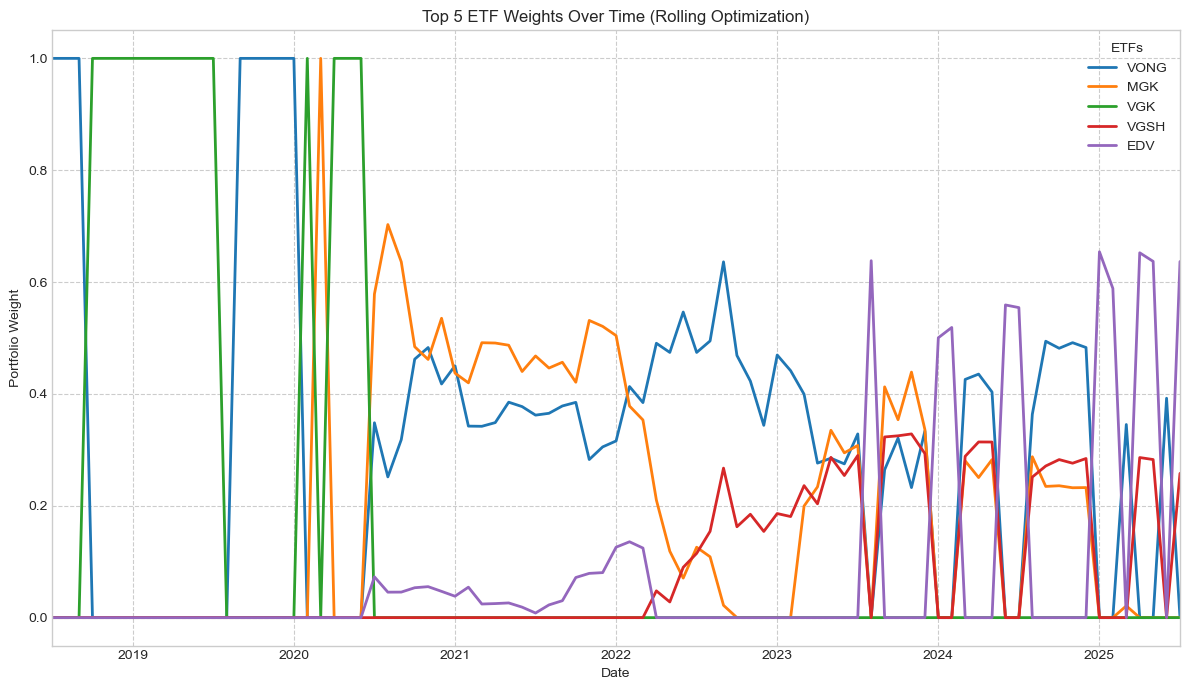

In [119]:
# This analysis shows how the optimal allocation would have changed over time,
# providing insight into the strategy's stability.
rolling_dates = returns_monthly.index[ROLLING_WINDOW_MONTHS:]
rolling_weights_list = []

for date in rolling_dates:
    # Create a data window of the last N months
    window_data = returns_monthly.loc[:date].iloc[-ROLLING_WINDOW_MONTHS:]
    # Estimate parameters on the window
    mu_roll = (window_data.mean().values * 12) - expense_vector
    cov_roll = LedoitWolf().fit(window_data.values).covariance_ * 12
    try:
        # Find the optimal (risk-matched) portfolio for this period
        ef_roll = efficient_frontier(cov_roll, mu_roll, n_points=30)
        _, w_roll = select_portfolio(ef_roll, "sigma", voo_sigma_annual)
        if w_roll is not None:
            rolling_weights_list.append(pd.Series(w_roll, index=etf_symbols, name=date))
    except (ValueError, np.linalg.LinAlgError):
        continue

# Combine results and plot the weight changes for the most important assets
if rolling_weights_list:
    rolling_weights_df = pd.concat(rolling_weights_list, axis=1).T
    # Identify the top 5 ETFs by average weight over time
    top_etfs = rolling_weights_df.mean().sort_values(ascending=False).head(5).index
    rolling_weights_df[top_etfs].plot(
        figsize=(12, 7), title="Top 5 ETF Weights Over Time (Rolling Optimization)", lw=2
    )
    plt.ylabel("Portfolio Weight")
    plt.xlabel("Date")
    plt.grid(True, linestyle="--")
    plt.legend(title="ETFs")
    plt.tight_layout()
    plt.show()

The results are quite sobering.  The weights move around quite a lot.  However, the broad strokes are similar to the static optimization as the Russell 1000 Growth ETF (VONG), and the Mega Cap Growth ETF (MGK), are frequently the top weighted funds.  The Extended Duration Treasury ETF (EDV), has becomes more popular since mid 2023, which makes sense following the rise in interest rates during that period.  

#### Black-Litterman

Black–Litterman is a popular Bayesian portfolio construction framework.  The Black–Litterma model uses market-implied equilibrium returns (the “prior”) and then tilts them toward investor views, producing a posterior return vector that is both economically grounded and data-driven.  

In my implementation the prior is a shrunk blend of the sample mean returns and the grand mean, very similar to what we tried above for James-Stein.  It is a light-touch Bayesian shrinkage, and we can allow for even more flexibility by running grid search to find the best shrinkage parameter.  In terms of investor views, I want to impose no specific assumptions, like by how much a specific ETFs outperforms the rest, but rather an economically defensible approach.  I will assume that the ETFs excess returns are approximately equal to VOO’s.  This makes sense if VOO is close to the market portfolio, the the remaining ETFs should eventually perform about as good as the market in the long run.  Uncertainty in the prior (tau_prior) and in the views (omega_scale) are hyper-parameters that we can tune through a grid search, just as with the shrinkage parameter.  The objective also here should make economic sense and I chose again the parameter combination that maximizes the Sharpe ratio. 

Useful sources: the [documentation of PyPortfolioOpt](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html) and Thomas Idzorek's [Step-by-Step Guide to the Black-Litterman Model](https://people.duke.edu/~charvey/Teaching/BA453_2006/Idzorek_onBL.pdf).

Formally, in the Black–Litterman framework we first update the prior (equilibrium) mean returns to the posterior mean, making this model Bayesian-like.

$$
\boldsymbol\mu_{\text{post}}
=
\Bigl[(\tau\Sigma)^{-1}+P^{\!\top}\Omega^{-1}P\Bigr]^{-1}
\Bigl[(\tau\Sigma)^{-1}\boldsymbol\pi + P^{\!\top}\Omega^{-1}\mathbf Q\Bigr]
$$

where

* $\boldsymbol\pi$ – prior (market-implied) mean vector.  In our case this are the sample mean returns shrunk towards the grand mean.  The relevant shrinkage factor which determines how much weight is given to the grand mean is one of the hyperparameters that we need to tune.
* $\Sigma$ – asset-return covariance matrix.  Since we want to be robust here, we are using the Ledoit-Wolf shrunk covariance matrix.
* $\tau$ – scalar reflecting uncertainty in the prior.  We need to tune this hyperparameter.
* $P$ – matrix that selects assets involved in each investor view.
* $\mathbf Q$ – vector of return views. This is combined with $P$ to represent the investor's views.
* $\Omega$ – diagonal matrix of view uncertainties (larger ⇒ softer views).  Also this parameter needs to be tuned.


We still need to think through how we can incorporate our investor views into the model.  I will assume that in the long run, all return are circa the same as the market portfolio's return, i.e., VOO.  This is a bit restrictive as it imposes return expectations on all assets, but it is in the spirit of Bayesian shrinkage towards the grand mean, and $\tau$ can be tuned to put less certainty on the prior. 

We can implement this assumption using the $P$ matrix and the $Q$ vector for each ETF.  Let $k$ index the $k$-th view, and let $j_k$ denote the ETF involved in that view:

$$
P_{k,j}=1,\; P_{k,\text{VOO}}=-1,
\quad
Q_k = 0
$$
meaning *“ETF $j$ will perform about the same as VOO.”*  In other words, the expected excess return of ETF $j_k$ relative to VOO is zero.  Note that the total number of views is equal to the number of ETFs - 1 as we implement one view per asset other than VOO.

Using these posterior returns, we choose portfolio weights $\mathbf w$ by solving the long-only mean–variance optimization program:

$$
\begin{aligned}
\min_{\mathbf w}\;&\tfrac12\,\mathbf w^{\!\top}\Sigma\,\mathbf w
-\boldsymbol\mu_{\text{post}}^{\!\top}\mathbf w \\
\text{s.t. }&\mathbf 1^{\!\top}\mathbf w = 1,\qquad
\mathbf w \ge 0
\end{aligned}
$$

Why do we not have the expected return not as a constraint but as part of the objective function here?  The reason is that we are estimating an equilibrium that maximizes the investors expected utility, based on her views.  We assume here that the investor has a simple **quadratic utility function**:

$$
U(\mathbf{w}) = \boldsymbol{\mu}^\top \mathbf{w} - \frac{\gamma}{2} \, \mathbf{w}^\top \Sigma \mathbf{w}
$$

Where:

- $\mathbf{w}$ is the vector of portfolio weights.
- $\boldsymbol{\mu}$ is the vector of expected returns.
- $\Sigma$ is the covariance matrix of asset returns.
- $\gamma > 0$ is the investor's risk aversion coefficient.


This utility function reflects a tradeoff between higher returns, $\boldsymbol{\mu}^\top \mathbf{w}$, and higher portfolio risk, $\mathbf{w}^\top \Sigma \mathbf{w}$.  The values of $\gamma$ indicates the investor's risk aversion, the more risk averse the more risky, high-volatility portfolios are penalized, thus acts as the measure of absolute risk aversion.  Quadratic utility functions are frequently used in Finance due to their easy tractability.  We will do so as well and just set $\gamma$ to 1. 

The investor’s goal is to maximize $U(\mathbf{w})$ — that is, to choose portfolio weights $\mathbf{w}$ that achieve the best balance between return and risk given their risk aversion.  To solve the Black-Litterman model, we multiply the utility function by -1 to get a minimization problem and plug in the posterior return estimates and robust covariance matrix, as well as setting the constraints so that portfolio weights add up to 1 and are non-negative.  

In [120]:
# The Black-Litterman model starts with market-implied equilibrium returns and
# then tilts them based on an investor's specific views, creating a blended,
# more intuitive set of expected returns for optimization.
def run_black_litterman(
    shrink_factor=0.3, tau_prior=0.20, omega_scale=0.02, print_summary=True
):
    """
    Performs Black-Litterman optimization with tunable hyperparameters.

    Args:
        shrink_factor (float): Weight on the sample mean in the prior;
                               1-shrink_factor goes to the grand mean.
        tau_prior (float): Prior uncertainty scale. Larger => prior is less certain.
        omega_scale (float): Diagonal element for Omega matrix (view uncertainty).
                             Larger => views are softer/less binding.
        print_summary (bool): If True, prints portfolio weights and top holdings.

    Returns:
        tuple: (weights_bl, mu_posterior)
               - weights_bl (np.ndarray | None): Optimal long-only weights.
               - mu_posterior (np.ndarray | None): Posterior expected-return vector.
    """
    n_assets = len(etf_symbols)
    # 1. Prior mean (pi) - a blend of sample mean and grand mean
    grand_mean = annual_mu_sample.mean()
    prior_mean = shrink_factor * annual_mu_sample + (1 - shrink_factor) * grand_mean

    try:
        # 2. Investor view: each ETF's return is approximately equal to VOO's return
        idx_voo = etf_symbols.index("VOO")
        other_symbols = [sym for sym in etf_symbols if sym != "VOO"]
        # P matrix selects assets involved in the view
        P = np.zeros((len(other_symbols), n_assets))
        for k, sym in enumerate(other_symbols):
            P[k, returns_monthly.columns.get_loc(sym)] = 1  # +1 on ETF
            P[k, idx_voo] = -1  # -1 on VOO
        # Q vector contains the expected outperformance ("approximately 0" in this case)
        Q = np.zeros(len(other_symbols))

        # 3. View-uncertainty (Omega)
        Omega = np.diag(np.full(len(Q), omega_scale))

        # 4. Posterior mean calculation (core Black-Litterman formula)
        inv_cov_prior = np.linalg.inv(tau_prior * annual_cov_shrunk)
        inv_Omega = np.linalg.inv(Omega)
        middle = np.linalg.inv(inv_cov_prior + P.T @ inv_Omega @ P)
        mu_posterior = middle @ (inv_cov_prior @ prior_mean + P.T @ inv_Omega @ Q)

        # 5. Optimize portfolio (mean-variance) using the posterior returns
        P_qp = opt.matrix(annual_cov_shrunk)
        q_qp = opt.matrix(-mu_posterior)
        G_qp = opt.matrix(-np.eye(n_assets))  # w >= 0
        h_qp = opt.matrix(np.zeros(n_assets))
        A_qp = opt.matrix(np.ones((1, n_assets)))  # sum(w) = 1
        b_qp = opt.matrix(1.0)

        sol = opt.solvers.qp(P_qp, q_qp, G_qp, h_qp, A_qp, b_qp)
        if sol["status"] != "optimal":
            raise RuntimeError(f"CVXOPT failed: {sol['status']}")

        weights_bl = np.array(sol["x"]).ravel()
        weights_bl[weights_bl < 1e-7] = 0
        weights_bl /= weights_bl.sum()

        if print_summary:
            print(
                f"\n--- Black-Litterman (shrink={shrink_factor}, "
                f"tau={tau_prior}, omega={omega_scale}) ---"
            )
            print("Weights > 1%:")
            for i, w in enumerate(weights_bl):
                if w > 0.01:
                    print(f"  {etf_symbols[i]}: {w:.1%}")
            top_idx = weights_bl.argsort()[-3:][::-1]
            print("\nTop 3 ETFs:")
            for i in top_idx:
                sym = etf_symbols[i]
                name = etf_name_map.get(sym, "Unknown")
                print(f"  {sym} ({name}): {weights_bl[i]:.2%}")

        return weights_bl, mu_posterior

    except (ValueError, IndexError, np.linalg.LinAlgError) as e:
        if print_summary:
            print(f"Black-Litterman failed: could not locate VOO or matrix error. {e}")
        return None, None

There are several hyperparameters that we need to decide upon, specifically the shrinkage factor of expected returns towards the grand mean, the uncertainty about the prior, $\tau$, and the uncertainty about the views, $\Omega$.  I will use again grid search to find the hyperparameter setting that maximizes the Sharpe ratio of the optimal portfolio.

In [121]:
print("\n--- Tuning Black-Litterman Hyperparameters ---")
shrink_grid = [0.2, 0.4, 0.6, 0.8]
tau_grid = [0.05, 0.10, 0.20, 0.30, 0.40]
omega_grid = [0.005, 0.01, 0.02, 0.05]
records = []

for shrink in shrink_grid:
    for tau in tau_grid:
        for omega in omega_grid:
            w, mu_post = run_black_litterman(shrink, tau, omega, print_summary=False)
            if w is None:
                continue
            exp_ret = float(w @ mu_post)
            vol = float(np.sqrt(w @ annual_cov_shrunk @ w))
            sharpe = exp_ret / vol if vol else np.nan
            records.append(
                {
                    "shrink": shrink,
                    "tau": tau,
                    "omega": omega,
                    "exp_return": exp_ret,
                    "vol": vol,
                    "sharpe": sharpe,
                    "top_weight": w.max(),
                    "assets_>1pct": (w > 0.01).sum(),
                }
            )

tune_df = pd.DataFrame(records).sort_values("sharpe", ascending=False)
print("Tuning results (top 10 by in-sample Sharpe):")
print(tune_df.head(10))
# ------------------------------------------------------------------------------

# Rerun with the best parameters found and print a summary
print("\n--- Final Black-Litterman Portfolio (using best tuned parameters) ---")
best_row = tune_df.iloc[0]
w_bl_opt, mu_bl = run_black_litterman(
    best_row["shrink"], best_row["tau"], best_row["omega"], print_summary=True
)


--- Tuning Black-Litterman Hyperparameters ---
Tuning results (top 10 by in-sample Sharpe):
    shrink   tau  omega  exp_return   vol  sharpe  top_weight  assets_>1pct
16   0.200 0.400  0.005       0.056 0.036   1.556       0.345             4
12   0.200 0.300  0.005       0.056 0.039   1.454       0.313             4
17   0.200 0.400  0.010       0.056 0.044   1.296       0.290             4
8    0.200 0.200  0.005       0.056 0.044   1.296       0.290             4
13   0.200 0.300  0.010       0.057 0.048   1.180       0.294             4
18   0.200 0.400  0.020       0.058 0.057   1.020       0.307             4
4    0.200 0.100  0.005       0.058 0.057   1.020       0.307             4
9    0.200 0.200  0.010       0.058 0.057   1.020       0.307             4
14   0.200 0.300  0.020       0.059 0.064   0.915       0.360             4
0    0.200 0.050  0.005       0.060 0.077   0.787       0.446             4

--- Final Black-Litterman Portfolio (using best tuned parameters) ---


These results look quite different to what we have seen so far.  While we again have a combination of Treasury ETFs and Growth ETFs, Black-Litterman clearly prefers to most weight into Treasuries.  This makes sense as we shrink the mean returns of the ETFs towards the market return, leading to the posterior returns being quite similar across ETFs.  If expected returns are similar across assets, Black-Litterman only cares about minimizing portfolio volatility, exactly what Treasury ETFs provide.  

By the way, enforcing minimum returns in this setting, for example by setting constraints such that the optimal portfolios should deliver at least 80% of VOO's expected return, frequently leads to the algorithm not converging.  Mean shrinkage might make it infeasible to reach higher expected returns. 

#### Risk Parity

The Risk Parity builds a portfolio in which each ETF contributes the same percentage to total portfolio volatility, intentionally ignoring expected returns.  This “equal-risk” stance delivers two practical benefits: first, diversification that is easy to explain to non-quants: no single asset can dominate portfolio risk.  Second, robustness to return-forecast error.  The trade-offs is that in can overweight low-volatility assets and under-deliver on absolute returns.  The code implements the idea by computing marginal risk contributions, minimizing the squared deviation of each asset’s risk share from the equal-split target, and enforcing long-only, fully­-invested weights. 

Useful source: [Daniel Palomar's presentation](https://palomar.home.ece.ust.hk/ELEC5470_lectures/slides_risk_parity_portfolio.pdf) on pp. 31-32.


Formally, in risk-parity portfolios we ignore expected returns and aim for every asset to shoulder the same share of total portfolio volatility.
Given weights $\mathbf w$ and covariance matrix $\Sigma$, we can define the following:

* **Portfolio volatility**

  $$
  \sigma_p=\sqrt{\mathbf w^{\!\top}\Sigma\,\mathbf w}
  $$

* **Marginal risk contribution (MRC)** of asset $i$

  $$
  \text{MRC}_i = \frac{\partial \sigma_p}{\partial w_i} = \frac{(\Sigma\,\mathbf w)_i}{\sigma_p}
  $$

* **Total (percentage) risk contribution**

  $$
  \text{RC}_i = w_i \cdot \text{MRC}_i = \frac{w_i \cdot (\Sigma \, \mathbf{w})_i}{\sigma_p}
  $$

Risk parity asks for

$$
\text{RC}_1=\text{RC}_2=\dots=\text{RC}_n=\frac{\sigma_p}{n}.
$$

A convenient way to reach this is to choose $\mathbf w$ that solves

$$
\begin{aligned}
\min_{\mathbf w}\;&\sum_{i=1}^{n}\bigl(\text{RC}_i-\sigma_p/n\bigr)^2 \\[4pt]
\text{s.t. }&\sum_{i=1}^{n} w_i = 1,\qquad w_i \ge 0.
\end{aligned}
$$

The [`SLSQP routine`](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-slsqp.html) in the code numerically searches for these weights, starting from an equal-weight guess and iteratively shrinking the squared differences between each asset’s risk contribution and the target until all assets contribute the same fraction of total portfolio risk.  SLSQP, or Sequential Least Squares Programming, is quite handy here as it as it works with a non-linear objective function, accepts constraints and boundary conditions, easy to implement, and as added bonus it is deterministic.


In [122]:
# Risk Parity aims to construct a portfolio where each asset contributes equally
# to the total portfolio risk. It ignores expected returns.
def portfolio_volatility(weights, cov_matrix):
    """Calculates the annualized volatility of a portfolio."""
    return np.sqrt(weights.T @ cov_matrix @ weights)


def risk_contributions(weights, cov_matrix):
    """Calculates each asset's percentage contribution to total portfolio risk."""
    port_vol = portfolio_volatility(weights, cov_matrix)
    if port_vol == 0:
        return np.zeros_like(weights)
    # Marginal Risk Contribution (MRC) = (Cov * w) / sigma_p
    mrc = (cov_matrix @ weights) / port_vol
    # Total Risk Contribution = w_i * MRC_i
    return weights * mrc


def risk_parity_objective(weights, cov_matrix):
    """
    Objective function for the optimizer. It seeks to minimize the
    variance of risk contributions across all assets, forcing them to be equal.
    """
    total_risk_contribs = risk_contributions(weights, cov_matrix)
    # Target is an equal contribution from each asset
    target_contribution = total_risk_contribs.sum() / len(weights)
    # Minimize the squared differences from this target
    return np.sum((total_risk_contribs - target_contribution) ** 2)


# Solve the optimization problem
initial_weights = np.ones(n_assets) / n_assets
bounds = tuple((0.0, 1.0) for _ in range(n_assets))
constraints = {"type": "eq", "fun": lambda w: np.sum(w) - 1.0}

result = minimize(
    fun=risk_parity_objective,
    x0=initial_weights,
    args=(annual_cov_sample,),
    method="SLSQP",
    bounds=bounds,
    constraints=constraints,
    options={"disp": False},
)

rp_weights = result.x if result.success else None
if rp_weights is not None:
    print("Optimal Risk Parity Portfolio (weights > 1%):")
    for i, weight in enumerate(rp_weights):
        if weight > 0.01:
            print(f"  - {etf_symbols[i]}: {weight:.1%}")
    print("\nTop 3 ETFs for Risk Parity Portfolio:")
    top_indices = np.argsort(rp_weights)[-3:][::-1]
    for i in top_indices:
        symbol = etf_symbols[i]
        name = etf_name_map.get(symbol, "Unknown")
        print(f"  {symbol} ({name}): {rp_weights[i]:.2%}")
else:
    print("Risk Parity optimization failed.")

Optimal Risk Parity Portfolio (weights > 1%):
  - VIG: 1.7%
  - VWOB: 3.2%
  - EDV: 3.9%
  - VXF: 1.1%
  - VEU: 1.5%
  - VSS: 1.2%
  - VEA: 1.4%
  - VWO: 1.8%
  - VGK: 1.2%
  - VPL: 1.7%
  - VUG: 1.1%
  - VYM: 1.7%
  - BIV: 3.5%
  - VCIT: 3.5%
  - VGIT: 3.1%
  - VV: 1.3%
  - BLV: 3.6%
  - VCLT: 3.1%
  - VGLT: 3.7%
  - MGC: 1.3%
  - MGK: 1.1%
  - MGV: 1.7%
  - VO: 1.0%
  - VOE: 1.1%
  - VMBS: 3.4%
  - VONE: 1.2%
  - VONG: 1.2%
  - VONV: 1.3%
  - VTWO: 1.1%
  - VTWG: 1.1%
  - VTWV: 1.1%
  - VTHR: 1.2%
  - VOO: 1.3%
  - VOOG: 1.2%
  - VOOV: 1.4%
  - IVOO: 1.0%
  - IVOG: 1.0%
  - IVOV: 1.1%
  - VIOO: 1.1%
  - VIOG: 1.1%
  - VIOV: 1.2%
  - BSV: 3.0%
  - VCSH: 3.2%
  - VTIP: 3.1%
  - VGSH: 2.7%
  - VB: 1.1%
  - VBK: 1.0%
  - VBR: 1.1%
  - BND: 3.4%
  - BNDX: 3.3%
  - VXUS: 1.5%
  - VTI: 1.2%
  - VT: 1.3%
  - VTV: 1.6%

Top 3 ETFs for Risk Parity Portfolio:
  EDV (Extended Duration Treasury ETF): 3.85%
  VGLT (Long-Term Treasury ETF): 3.71%
  BLV (Long-Term Bond ETF): 3.58%


As risk parity tries to distribute the risk across portfolio assets, we get many small weights across a lot of ETFs.  But it also seems that the highest weights go again to the low-volatility treasury ETFs, not great for expected returns.  We could implement something like L1 regularization also here to penalize small weights, but it likely would not lead to less weight on Treasury ETFs; they are low-volatility and will have large weights as their marginal risk contribution is small.

#### Hierarchical Risk Parity (HRP)

Hierarchical Risk Parity (HRP) is a machine-learning-inspired take on risk parity portfolio optimization.  It follows a three-step, graph-theoretic workflow: 

1. **Clustering**: Convert the correlation matrix into a distance matrix and apply hierarchical clustering to group strongly related ETFs based on their co-movements.

2. **Quasi-diagonalization**: Reorder the covariance matrix based on the clustering results so that similar assets are placed next to each other. This reveals a block-like structure and reflects asset similarity.

3. **Recursive bisection**: The algorithm recursively splits the ordered list of assets in half and allocates capital inversely proportional to each sub-cluster’s variance, proceeding top-down through the tree.

The result is a portfolio that automatically diversifies across statistically distinct clusters *without estimating expected returns.*  

One big advantage of this method is that is allows for a visual representation of the clusters via a dendrogram.  The disadvantage of the method is that is also will weight heavily on clusters with low volatility.  What we can do, though, is to leverage this to our advantage and improve on the two-asset allocation we found through the static mean-variance optimization.  We can take the portfolio that we found that matches VOO's volatility from the static optimization above (which mostly consists of Growth ETFs) and blend it with the optimal portfolio from HRP, which will have lower volatility and lower expected return, to match VOO's expected return.  Basically, we can find with this method a better low-volatility portfolio than the Treasury ETF we found from the static portfolio optimization.

Useful sources: [Hudson and Thames introduction to HRP article](https://hudsonthames.org/an-introduction-to-the-hierarchical-risk-parity-algorithm/) and the original paper by Marcos Lopez de Prado, *Building Diversified Portfolios that Outperform Out-of-Sample*; with the [working paper version on SSRN](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2708678).

The logic for HRP is based on hierarchical clustering to arrange the assets into clusters based on their correlation and then walk through the tree to assign portfolio weight inversely to each sub-cluster's variance.

1. **Convert correlations to “distances”**

   For any pair of assets $i,j$ with correlation $\rho_{ij}$, we define a distance metric as:

   $$
   d_{ij}= \sqrt{\tfrac{1}{2}\,\bigl(1-\rho_{ij}\bigr)}
   $$

   A smaller value of $d_{ij}$ means the assets move together more closely.

2. **Build the hierarchy**

   Apply agglomerative clustering (e.g. *single-linkage*) on the distance matrix $D=(d_{ij})$ to obtain a dendrogram.  What this does is iteratively merge pairs of assets and then clusters based on the minimum distance (in this case, the minimum pair-wise distance for all elements in each cluster).  In the last step, we end up with one cluster containing all assets.  In effect, the algorithm *builds the tree from the leaves to the root*, starting with individual assets and successively merging them into larger clusters.

   The final dendrogram gives an ordering (seriation) that groups similar assets next to one another, which we can use to rearrange the covariance matrix.

   This is a straightforward approach which we can complete with Python libraries such as [`scipy`](https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html) relatively easily.  The original paper provides a step-by-step algorithm to identify clusters and quasi-diagonalize the matrix.  It is not essential that we follow here the same approach as the paper, we only need to find a way to seriate the covariance matrix and remain aware of subtle difference, such as specific tie-breaking rules.

3. **Recursive Bisection Allocation**

   Move **backward** through the hierarchical tree, starting at the root cluster that contains all assets, and recursively bisect until each individual asset (leaf) is assigned its final weight.

   At each step:

   1. Split the current cluster into two sub-clusters: **left** $C_L$ and **right** $C_R$.

   2. Allocate the cluster's total weight to the two halves *inversely proportional to the sub-clusters' variances* — i.e., assign more weight to the less volatile sub-cluster:

   $$
   \alpha = 1 - \frac{\sigma_{C_L}^2}{\sigma_{C_L}^2 + \sigma_{C_R}^2},
   \qquad
   \begin{cases}
   w_{C_L} \gets w_{C_L} \cdot \alpha, \\[4pt]
   w_{C_R} \gets w_{C_R} \cdot (1 - \alpha)
   \end{cases}
   $$

   To compute the variance of a cluster $C$ with covariance sub-matrix $\Sigma_C$ and asset set $k \in C$:

   1. Compute inverse-variance weights:

   $$
   \tilde{w}_k = \frac{1}{\sigma_k^2},
   \qquad
   w_k = \frac{\tilde{w}_k}{\sum_{j \in C} \tilde{w}_j}
   $$

   where $\sigma_k^2 = \Sigma_{kk}$ is the variance of asset $k$.

   2. Use these weights to calculate the cluster variance:

   $$
   \sigma_C^2 = \mathbf{w}_C^{\!\top} \, \Sigma_C \, \mathbf{w}_C
   $$

   Repeat the recursive bisection process until every leaf node (individual asset) receives its final weight in the portfolio.

The final weight vector $\mathbf w$ is long-only, sums to one, and tends to equalize risk across clusters without solving a quadratic program.


Optimal HRP Portfolio (weights > 1%):
  - BIV: 1.3%
  - VCIT: 1.7%
  - VGIT: 2.4%
  - VMBS: 2.6%
  - BSV: 10.1%
  - VCSH: 11.1%
  - VTIP: 10.3%
  - VGSH: 47.9%
  - BND: 1.7%
  - BNDX: 4.5%

Top 3 ETFs for HRP Portfolio:
  VGSH (Short-Term Treasury ETF): 47.86%
  VCSH (Short-Term Corporate Bond ETF): 11.11%
  VTIP (Short-Term Inflation-Protected Securities ETF): 10.31%


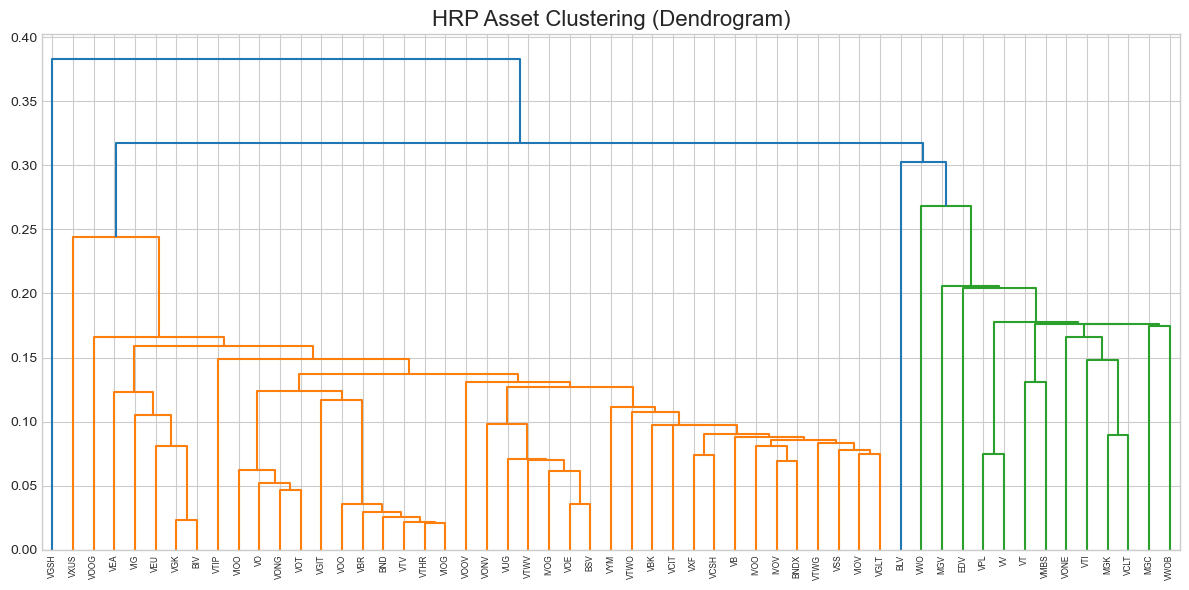

In [123]:
# HRP uses graph theory and machine learning to build a diversified portfolio.
# It clusters assets, reorders the covariance matrix, and allocates weights recursively.
def correlation_to_distance(corr_matrix):
    """Converts a correlation matrix to a distance matrix."""
    return np.sqrt(0.5 * (1 - corr_matrix))


def get_cluster_variance(cov_matrix, cluster_indices):
    """Calculates the variance of a cluster of assets."""
    sub_cov = cov_matrix[np.ix_(cluster_indices, cluster_indices)]
    # Inverse variance weights within the cluster
    inv_var_weights = 1.0 / np.diag(sub_cov)
    inv_var_weights /= inv_var_weights.sum()
    return inv_var_weights.T @ sub_cov @ inv_var_weights


def recursive_bisection(cov_matrix, sorted_indices):
    """Recursively splits weights between asset clusters."""
    weights = pd.Series(1.0, index=sorted_indices)
    clusters = [sorted_indices]
    while clusters:
        cluster = clusters.pop(0)
        if len(cluster) <= 1:
            continue
        # Bisect the cluster
        split_point = len(cluster) // 2
        left_cluster, right_cluster = cluster[:split_point], cluster[split_point:]
        # Calculate variance for each sub-cluster
        var_left = get_cluster_variance(cov_matrix, left_cluster)
        var_right = get_cluster_variance(cov_matrix, right_cluster)
        # Allocate weights inversely to cluster variance
        alpha = 1.0 - var_left / (var_left + var_right)
        weights[left_cluster] *= alpha
        weights[right_cluster] *= 1.0 - alpha
        # Add the new sub-clusters to the list to be processed
        clusters.extend([left_cluster, right_cluster])
    return weights.sort_index()


# Step 1: Hierarchical Clustering
corr_matrix = returns_monthly.corr()
dist_matrix = correlation_to_distance(corr_matrix)
linkage_matrix = linkage(squareform(dist_matrix), method="single")

# Step 2: Quasi-Diagonalization (Seriation)
# This reorders assets to place similar assets next to each other.
sorted_indices = leaves_list(linkage_matrix)
sorted_tickers = [etf_symbols[i] for i in sorted_indices]

# Step 3: Recursive Bisection
sorted_cov = returns_monthly[sorted_tickers].cov().values * 12
hrp_weights_sorted = recursive_bisection(sorted_cov, np.arange(len(sorted_tickers)))

# Map weights back to the original order of etf_symbols
hrp_weights = np.zeros(n_assets)
for i, ticker in enumerate(sorted_tickers):
    original_idx = etf_symbols.index(ticker)
    hrp_weights[original_idx] = hrp_weights_sorted.iloc[i]

print("Optimal HRP Portfolio (weights > 1%):")
for i, weight in enumerate(hrp_weights):
    if weight > 0.01:
        print(f"  - {etf_symbols[i]}: {weight:.1%}")

if hrp_weights is not None:
    print("\nTop 3 ETFs for HRP Portfolio:")
    top_indices = np.argsort(hrp_weights)[-3:][::-1]
    for i in top_indices:
        symbol = etf_symbols[i]
        name = etf_name_map.get(symbol, "Unknown")
        print(f"  {symbol} ({name}): {hrp_weights[i]:.2%}")

# Optional: Visualize the asset hierarchy with a dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, labels=sorted_tickers, leaf_rotation=90)
plt.title("HRP Asset Clustering (Dendrogram)", fontsize=16)
plt.tight_layout()
plt.show()


The dendrogram shows quite interesting risk clusters.  There are apparently two large clusters, with the right cluster including, for example, all the Mega Cap ETFs (MGC, MGK, and MGV), the Total Stock Market ETF (VTI), but also the Extended Duration Treasury ETF (EDV).  Apparently, the closest ETFs to the Mega Cap Growth ETFs (MGK) in terms of volatility is the Long-Term Corporate Bond ETF (VCLT).  Quite unexpected.  And for the Russell 1000 Growth ETF (VONG) the closest ETF is the Mid-Cap Growth ETF (VOT), which is a bit less unexpected.

Hierarchical Risk Parity (HRP) tends to produce a minimum-variance portfolio, which is typically conservative and heavily tilted toward low-volatility assets.  If we aim to achieve higher expected returns, we need to consider blending this portfolio with higher-return alternatives. For instance, the mean-variance optimal portfolio often assigns substantial weight to high-return, high-volatility Growth ETFs and matches VOO's volatility.  We can use the HRP-derived minimum-variance portfolio as a low-risk anchor and then blend it with a Growth ETF portfolio to reach a desired return level—such as matching VOO's expected return.

In [124]:
# Blend the HRP portfolio with the MVO portfolio (risk-matched to VOO)
# to create a new portfolio that meets VOO's expected return.
mu_hrp = hrp_weights @ annual_mu_sample
mu_mv = w_sigma_raw @ annual_mu_sample
# Calculate blending factor 'alpha'
alpha = np.clip((voo_mu_annual - mu_hrp) / (mu_mv - mu_hrp + 1e-12), 0, 1)
# Create blended weights
w_tilt = (1 - alpha) * hrp_weights + alpha * w_sigma_raw
w_tilt /= w_tilt.sum()
sigma_tilt = np.sqrt(w_tilt @ annual_cov_sample @ w_tilt)

print(f"\nBlended HRP-MVO portfolio: alpha = {alpha:.3f}")
print(f"  Expected mu   = {w_tilt @ annual_mu_sample:.2%} (VOO: {voo_mu_annual:.2%})")
print(f"  Volatility sigma = {sigma_tilt:.2%} (VOO: {voo_sigma_annual:.2%})")
print("\nTop 3 ETFs for Blended HRP-MVO Portfolio:")
top_indices = np.argsort(w_tilt)[-3:][::-1]
for i in top_indices:
    symbol = etf_symbols[i]
    name = etf_name_map.get(symbol, "Unknown")
    print(f"  {symbol} ({name}): {w_tilt[i]:.2%}")


Blended HRP-MVO portfolio: alpha = 0.862
  Expected mu   = 12.49% (VOO: 12.49%)
  Volatility sigma = 12.86% (VOO: 14.70%)

Top 3 ETFs for Blended HRP-MVO Portfolio:
  VONG (Russell 1000 Growth ETF): 76.55%
  VGSH (Short-Term Treasury ETF): 16.28%
  VCSH (Short-Term Corporate Bond ETF): 1.53%


As expected, the blended portfolio weighs heavily on the Russell 1000 Growth ETF, but now also includes, for example, the Short-Term Corporate Bond ETFs as low-volatility component.

#### DCC-GARCH

In this section, we will try to find the optimal portfolios accounting for changing volatility and covariances over time.  Dynamic Conditional Correlation (DCC)-GARCH extends classic GARCH by allowing both volatilities and cross-asset correlations to evolve over time.  This method allows us to model and predict the covariance matrix in a more dynamic fashion than just looking at historic returns.  The estimation procedure is quite parameter heavy, thus we need ideally a lot of observations.  For this, we switch to weekly ETF returns.  We then can fit for each ETF the a univariate GARCH(1,1) and get standardized residuals (residuals divided by the volatility estimate) and conditional variance estimates.  Then, we can estimate a two-parameter DCC(1,1) model via quasi-maximum likelihood.  We can forecast the 1-step-ahead covariance matrix with this and feed it into a monthly mean–variance optimization, allowing for moving portfolio weights and changing correlation relations between assets over time.

Source are the original Engle paper, *Dynamic Conditional Correlation A Simple Class of Multivariate Generalized Autoregressive Conditional Heteroskedasticity Models*, an its [working paper version](https://pages.stern.nyu.edu/~rengle/dccfinal.pdf), Qunxing Pan's [*A Teaching Summary on the Estimation of DCC-type Models*](https://www.atlantis-press.com/article/125960938.pdf), and the website of [NYU's V-Lab](https://vlab.stern.nyu.edu/docs/correlation/GARCH-DCC).

Before we go into DCC, let us first understand how we can model an individual asset's volatility.  Many time series, such as those of ETFs, often exhibit volatility clustering — periods of high volatility tend to be followed by high volatility, and calm periods tend to follow calm periods.  This is inconsistent with the assumptions that ETFs have a constant variance, but we can use **GARCH models** (Generalized Autoregressive Conditional Heteroskedasticity model) to capture such changes of volatility over time.

A GARCH(1,1) models the conditional variance of returns as a function of past squared shocks and the past variance:

$$
r_{i,t} = \mu_i + \varepsilon_{i,t}, \qquad
\varepsilon_{i,t} = \sigma_{i,t} z_{i,t}, \quad
z_{i,t} \sim \mathcal{N}(0, 1)
$$

$$
\sigma_{i,t}^2 = \omega_i + a_i\,\varepsilon_{i,t-1}^2 + b_i\,\sigma_{i,t-1}^2
$$

Where:
- $\sigma_{i,t}^2$ is the conditional variance of ETF $i$ at time $t$,
- $\omega_i$, $a_i$, and $b_i$ are model parameters,
- $\varepsilon_{i,t}$ is the return shock (innovation),
- $z_{i,t}$ is the standardized innovation, assumed to be i.i.d. standard normal.

In estimation, the **standardised residuals** are then computed as: $z_{i,t} = \varepsilon_{i,t}/\sigma_{i,t}$.

The GARCH(1,1) model thus captures how volatility evolves over time and allows us to forecast next-period volatility.

GARCH models are only appropriate if the return series exhibits *autoregressive conditional heteroskedasticity (ARCH effects)* — that is, if the variance of the series changes over time in a predictable way.  Fortunately, we can test for this using *Engle’s ARCH test*, which is implemented in [`statsmodels`](https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.het_arch.html). The test checks whether there is significant autocorrelation in the squared residuals of a return series — a key sign of time-varying volatility.

A useful short explanation of the test can also be found in the [MATLAB documentation](https://www.mathworks.com/help/econ/engles-arch-test.html).


To estimate the Dynamic Conditional Correlation (DCC) between assets, I first estimate univariate GARCH models for each ETF — after verifying that ARCH effects are present in the data.  Then, I fit the DCC model to the standardized residuals to produce a time-varying covariance matrix, allowing for one-step-ahead covariance forecasts.

1. **Fit a standard GARCH(1, 1)** to every return series $r_{i,t}$.

   This step is comparatively easy, since Python has standard libraries to fit GARCH models, such as [`arch`](https://arch.readthedocs.io/en/latest/univariate/generated/arch.univariate.GARCH.html#).  However, we need to be aware that these models typically need a lot of observation to lead to stable estimates.  Thus, I'm using weekly observations instead of monthly.  Note also that I scale the weekly returns by a factor of 100, since this makes fitting the models easier.

2. **Estimate the dynamic correlation structure, DCC(1, 1)**

   Collect the vector of standardized residuals at date $t$ as
   $\mathbf z_t = (z_{1,t},\dots,z_{N,t})^\top$.
   
   Let $Q_t$ be the covariance of $\mathbf z_t$ and $\bar{Q}$ the unconditional (sample) covariance matrix.  Then, we can fit the following model for $Q_t$ via log-likelihood:

   $$
   Q_t
     \;=\;
     (1-\alpha-\beta)\,\bar{Q}
     +\alpha\,\mathbf z_{t-1}\mathbf z_{t-1}^\top
     +\beta\,Q_{t-1},
     \qquad 0<\alpha,\beta,\ \alpha+\beta<1.
   $$

   This is a GARCH-like structure applied to the covariance matrix of standardized returns.

   Finally, we convert $Q_t$ to the correlation matrix:

   $$
   R_t = \bigl(\operatorname{diag}Q_t\bigr)^{-1/2} Q_t \bigl(\operatorname{diag}Q_t\bigr)^{-1/2}.
   $$

   Note that for the quasi-log-likelihood minimization, we take the standardized residuals $\mathbf z_t$ as observed input from the individual GARCH models, thus we can drop them from the estimation; only $\alpha$ and $\beta$ are estimated. 

3. **One-step-ahead forecast of the full covariance matrix**

   To forecast the covariance matrix at time $T+1$, we combine the results from the DCC model and the univariate GARCH models. Two components are required:

   *First*, we compute the dynamic correlation matrix $R_{T+1}$ from the DCC model.  
   We obtain this by plugging the most recent standardized residual vector $\mathbf{z}_T$, the last estimated $Q_T$, and the unconditional sample covariance matrix $\bar{Q}$ into the DCC recursion:

   $$
   Q_{T+1} = (1 - \alpha - \beta)\,\bar{Q} + \alpha\,\mathbf{z}_T \mathbf{z}_T^\top + \beta\,Q_T
   $$

   Then, convert $Q_{T+1}$ to a correlation matrix:

   $$
   R_{T+1} = \left(\operatorname{diag} Q_{T+1} \right)^{-1/2} Q_{T+1} \left(\operatorname{diag} Q_{T+1} \right)^{-1/2}
   $$

   *Second*, we construct the diagonal matrix $D_T$ using the last available conditional standard deviations from the univariate GARCH models:

   $$
   D_T = \operatorname{diag}(\sigma_{1,T}, \dots, \sigma_{N,T})
   $$

   We could forecast one-step-ahead variances $\sigma_{i,T+1}^2$ from the GARCH models, but since the covariance structure is more important here, I simplify by using the most recent $\sigma_{i,T}$ values instead.

   The final forecast of the full covariance matrix at $T+1$ is then given by:

   $$
   \Sigma_{T+1} = D_T\,R_{T+1}\,D_T
   $$

4. **Portfolio optimization with the forecasted covariance**

   Feed $\Sigma_{T+1}$ — and, if desired, a forecast of expected returns — into the mean-variance optimization routine from above to pick weights that target a chosen risk level, i.e., match VOO’s volatility.  Note that we are doing all of this on weekly basis.  To get to monthly weights, I just take the portfolio weight from the last week of the month to define the weight for the next month.


We start implementing the approach by defining some function for the DCC estimation, fitting, and forecasting.

In [125]:
def _dcc_negloglik(params, std_resids):
    """Negative log-likelihood of a DCC(1,1) model given standardized residuals."""
    T, N = std_resids.shape
    alpha, beta = params
    Qbar = np.cov(std_resids.T)  # Unconditional correlation
    Qt = Qbar.copy()  # Initialize Qt_0
    loglik = 0.0
    for t in range(T):
        eps_t = std_resids[t][:, None]  # (N,1)
        Qt = (1 - alpha - beta) * Qbar + alpha * (eps_t @ eps_t.T) + beta * Qt
        diag_sqrt = np.sqrt(np.diag(Qt))
        diag_sqrt[diag_sqrt <= 1e-12] = 1e-12
        Rt = Qt / np.outer(diag_sqrt, diag_sqrt)
        inv_Rt = np.linalg.inv(Rt)
        logdet_Rt = np.log(np.linalg.det(Rt))
        loglik += logdet_Rt + eps_t.T @ inv_Rt @ eps_t
    return 0.5 * loglik.item()


def fit_dcc(std_resids, bounds=((1e-6, 1 - 1e-6),) * 2):
    """Estimates (alpha, beta) by QML; returns params and last Qt, Rt."""
    best_val, best_ab = np.inf, None
    grid = np.linspace(0.01, 0.15, 5)
    for a in grid:
        for b in grid:
            if a + b < 0.999:
                val = _dcc_negloglik((a, b), std_resids)
                if val < best_val:
                    best_val, best_ab = val, (a, b)
    res = minimize(
        _dcc_negloglik,
        x0=np.array(best_ab),
        args=(std_resids,),
        bounds=bounds,
        constraints={"type": "ineq", "fun": lambda x: 0.999 - (x[0] + x[1])},
    )
    alpha, beta = max(res.x[0], 0), max(res.x[1], 0)
    if alpha + beta >= 0.999:
        beta = 0.999 - alpha - 1e-6

    Qbar = np.cov(std_resids.T)
    Qt = Qbar.copy()
    for eps in std_resids:
        eps = eps[:, None]
        Qt = (1 - alpha - beta) * Qbar + alpha * (eps @ eps.T) + beta * Qt
    Rt = Qt / np.outer(np.sqrt(np.diag(Qt)), np.sqrt(np.diag(Qt)))
    return alpha, beta, Qt, Rt


def forecast_dcc_cov_1step(std_resids, cond_vars):
    """ Returns the 1-step-ahead covariance matrix using a DCC(1,1) model. """
    # Fit DCC and get last Q_T
    alpha, beta, Q_last, _ = fit_dcc(std_resids)

    # Unconditional correlation (Q_bar) and latest residual
    Q_bar   = np.cov(std_resids.T)
    eps_T   = std_resids[-1, :][:, None]        # column vector (N × 1)

    # ---- 1-step DCC update --------------------------------------
    Q_next = ((1.0 - alpha - beta) * Q_bar
              + alpha * (eps_T @ eps_T.T)
              + beta  * Q_last)

    # Convert to correlation matrix
    diag_sqrt = np.sqrt(np.diag(Q_next))
    diag_sqrt[diag_sqrt <= 1e-12] = 1e-12       # numerical guard
    R_next    = Q_next / np.outer(diag_sqrt, diag_sqrt)

    # Scale by last conditional variances to get covariance
    var_T     = cond_vars[-1]                   # last row
    D_T       = np.diag(np.sqrt(var_T))
    Sigma_next = D_T @ R_next @ D_T

    return Sigma_next 

Next, collect weekly return data to fit our model.

In [126]:
#Prepare weekly data for better GARCH model estimation
surviving_etf_symbols = returns_monthly.columns.tolist()
all_prices_daily = pd.concat(
    [get_total_return_series(t) for t in surviving_etf_symbols], axis=1
).tz_localize(None)
returns_weekly = (
    all_prices_daily[surviving_etf_symbols]
    .resample("W-FRI")
    .last()
    .pct_change()
    .loc[returns_monthly.index.min() :]
    .dropna(how="all")
)

Before fitting the DCC-GARCH model, we should check whether the ETF return series exhibit ARCH (Autoregressive Conditional Heteroskedasticity) effects.  To test for ARCH behavior, we can use Engle's ARCH test, which examines whether the squared residuals of a return series are significantly autocorrelated.  If the test is significant, it suggests the presence of time-varying volatility that can be modelled using GARCH.


In [127]:
print("\n--- Testing for GARCH(1,1) Effects in Weekly Returns ---")
for symbol in surviving_etf_symbols:
    series = returns_weekly[symbol].dropna()
    if len(series) < 20: continue
    lm_test = het_arch(series, nlags=12)
    print(f"{symbol}: ARCH LM Test p-value = {lm_test[1]:.4f}", end="")
    print("  -> ARCH effects detected" if lm_test[1] < 0.05 else "  -> No significant ARCH effects")


--- Testing for GARCH(1,1) Effects in Weekly Returns ---
VIG: ARCH LM Test p-value = 0.0000  -> ARCH effects detected
VWOB: ARCH LM Test p-value = 0.0000  -> ARCH effects detected
EDV: ARCH LM Test p-value = 0.0019  -> ARCH effects detected
VXF: ARCH LM Test p-value = 0.0000  -> ARCH effects detected
VEU: ARCH LM Test p-value = 0.0000  -> ARCH effects detected
VSS: ARCH LM Test p-value = 0.0000  -> ARCH effects detected
VEA: ARCH LM Test p-value = 0.0000  -> ARCH effects detected
VWO: ARCH LM Test p-value = 0.0000  -> ARCH effects detected
VGK: ARCH LM Test p-value = 0.0000  -> ARCH effects detected
VPL: ARCH LM Test p-value = 0.0000  -> ARCH effects detected
VUG: ARCH LM Test p-value = 0.0000  -> ARCH effects detected
VYM: ARCH LM Test p-value = 0.0000  -> ARCH effects detected
BIV: ARCH LM Test p-value = 0.0000  -> ARCH effects detected
VCIT: ARCH LM Test p-value = 0.0000  -> ARCH effects detected
VGIT: ARCH LM Test p-value = 0.0000  -> ARCH effects detected
VV: ARCH LM Test p-value

There are enough ETFs with ARCH effects which we can model using GARCH, so the DCC-GARCH model actually makes sense.  

In [128]:
print("\n--- Rolling DCC-GARCH Optimization ---")
try:
    month_ends = returns_weekly.resample("ME").last().index
    voo_sigma_annual_weekly = returns_weekly["VOO"].std() * np.sqrt(52)
    rolling_dcc_weights_list = []

    for date in month_ends:
        data_window = returns_weekly.loc[:date]
        if len(data_window) < 104: continue  # Need enough data

        try:
            print(f"Optimizing DCC portfolio for month-end {date.date()}...")
            std_resids, cond_vars = [], []
            scale = 100.0  # Rescale returns for better model fitting
            for s in etf_symbols:
                series = scale * data_window[s].dropna()
                am = ConstantMean(series)
                am.volatility = GARCH(1, 1)
                res = am.fit(disp="off")
                std_resids.append(res.std_resid)
                cond_vars.append((res.conditional_volatility / scale) ** 2)

            std_resids = np.column_stack(std_resids)
            cond_vars = np.column_stack(cond_vars)

            forecasted_cov = forecast_dcc_cov_1step(std_resids, cond_vars) * 52
            forecasted_mu = data_window.mean().values * 52

            ef_dcc = efficient_frontier(forecasted_cov, forecasted_mu, n_points=30)
            _, w_dcc = select_portfolio(ef_dcc, "sigma", voo_sigma_annual_weekly)
            if w_dcc is not None:
                rolling_dcc_weights_list.append(pd.Series(w_dcc, index=etf_symbols, name=date))
        except Exception as e:
            print(f"  Skipped {date.date()} due to error: {e}")
  
except Exception as e:
    print(f"Failed to run DCC-GARCH analysis. Error: {e}")
    dynamic_returns_series_dcc = pd.Series(dtype=float)


--- Rolling DCC-GARCH Optimization ---
Optimizing DCC portfolio for month-end 2015-07-31...
Optimizing DCC portfolio for month-end 2015-08-31...
Optimizing DCC portfolio for month-end 2015-09-30...
Optimizing DCC portfolio for month-end 2015-10-31...
Optimizing DCC portfolio for month-end 2015-11-30...
Optimizing DCC portfolio for month-end 2015-12-31...
Optimizing DCC portfolio for month-end 2016-01-31...
Optimizing DCC portfolio for month-end 2016-02-29...
Optimizing DCC portfolio for month-end 2016-03-31...
Optimizing DCC portfolio for month-end 2016-04-30...
Optimizing DCC portfolio for month-end 2016-05-31...
Optimizing DCC portfolio for month-end 2016-06-30...
Optimizing DCC portfolio for month-end 2016-07-31...
Optimizing DCC portfolio for month-end 2016-08-31...
Optimizing DCC portfolio for month-end 2016-09-30...
Optimizing DCC portfolio for month-end 2016-10-31...
Optimizing DCC portfolio for month-end 2016-11-30...
Optimizing DCC portfolio for month-end 2016-12-31...
Optimi

/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning:

The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.




Optimizing DCC portfolio for month-end 2017-04-30...
Optimizing DCC portfolio for month-end 2017-05-31...
Optimizing DCC portfolio for month-end 2017-06-30...
Optimizing DCC portfolio for month-end 2017-07-31...
Optimizing DCC portfolio for month-end 2017-08-31...
Optimizing DCC portfolio for month-end 2017-09-30...
Optimizing DCC portfolio for month-end 2017-10-31...
Optimizing DCC portfolio for month-end 2017-11-30...
Optimizing DCC portfolio for month-end 2017-12-31...
Optimizing DCC portfolio for month-end 2018-01-31...
Optimizing DCC portfolio for month-end 2018-02-28...
Optimizing DCC portfolio for month-end 2018-03-31...
Optimizing DCC portfolio for month-end 2018-04-30...
Optimizing DCC portfolio for month-end 2018-05-31...
Optimizing DCC portfolio for month-end 2018-06-30...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning:

The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




Optimizing DCC portfolio for month-end 2018-07-31...
Optimizing DCC portfolio for month-end 2018-08-31...
Optimizing DCC portfolio for month-end 2018-09-30...
Optimizing DCC portfolio for month-end 2018-10-31...
Optimizing DCC portfolio for month-end 2018-11-30...
Optimizing DCC portfolio for month-end 2018-12-31...
Optimizing DCC portfolio for month-end 2019-01-31...
Optimizing DCC portfolio for month-end 2019-02-28...
Optimizing DCC portfolio for month-end 2019-03-31...
Optimizing DCC portfolio for month-end 2019-04-30...
Optimizing DCC portfolio for month-end 2019-05-31...
Optimizing DCC portfolio for month-end 2019-06-30...
Optimizing DCC portfolio for month-end 2019-07-31...
Optimizing DCC portfolio for month-end 2019-08-31...
Optimizing DCC portfolio for month-end 2019-09-30...
Optimizing DCC portfolio for month-end 2019-10-31...
Optimizing DCC portfolio for month-end 2019-11-30...
Optimizing DCC portfolio for month-end 2019-12-31...
Optimizing DCC portfolio for month-end 2020-01

We can now visualize the time series of optimal portfolio weights that match VOO's volatility.  To evaluate performance, we also calculate monthly portfolio returns, assuming that the portfolio weights estimated in the last week of each month are held constant throughout the following month.  This simulates a realistic strategy where portfolios are rebalanced on monthly basis.


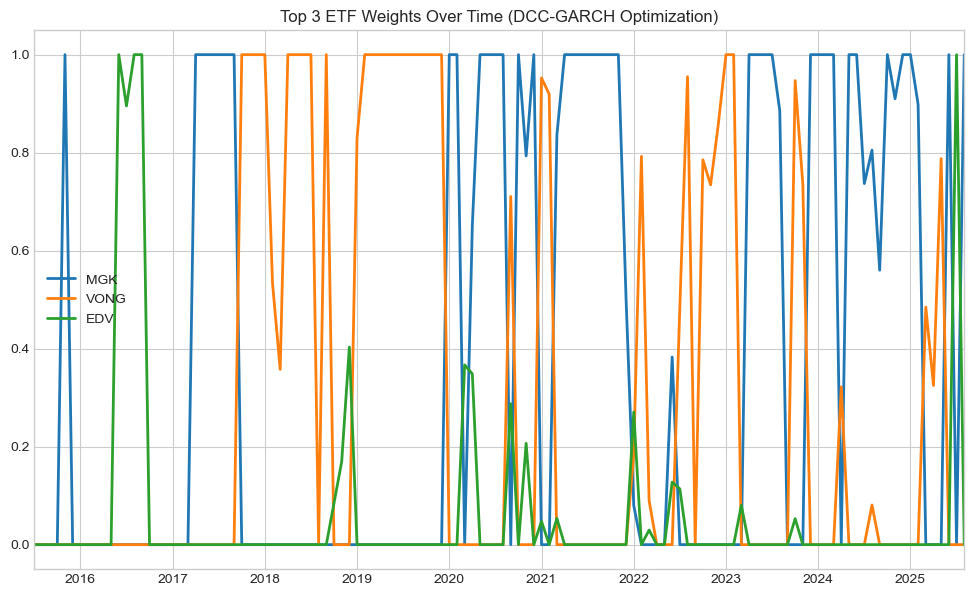

In [129]:
if rolling_dcc_weights_list:
    dcc_weights_df = pd.concat(rolling_dcc_weights_list, axis=1).T
    top_dcc_etfs = dcc_weights_df.mean().sort_values(ascending=False).head(3).index
    dcc_weights_df[top_dcc_etfs].plot(
        figsize=(12, 7),
        title="Top 3 ETF Weights Over Time (DCC-GARCH Optimization)",
        lw=2,
    )
    plt.show()

    # Create monthly return series for the DCC strategy
    dcc_shifted_weights = dcc_weights_df.shift(1).reindex(returns_monthly.index).ffill()
    common_idx = dcc_shifted_weights.dropna().index.intersection(returns_monthly.index)
    aligned_weights = dcc_shifted_weights.loc[common_idx]
    aligned_returns = returns_monthly.loc[common_idx]
    dynamic_returns_series_dcc = pd.Series(
        np.sum(aligned_weights.values * aligned_returns[etf_symbols].values, axis=1),
        index=common_idx,
    )
else:
    dynamic_returns_series_dcc = pd.Series(dtype=float)
    print("No successful DCC-GARCH optimizations were completed.")

The optimal portfolio weights vary considerably over time. Interestingly, they tend to oscillate primarily between the Russell 1000 Growth ETF (VONG), the Mega Cap Growth ETF (MGK), and the Extended Duration Treasury ETF (EDV).  This makes economic sense: since overall market risk is governed by the conditional covariance structure, the optimizer shifts weight toward higher-return assets (i.e., growth-oriented ETFs) when the estimated market risk is low.  Conversely, when the conditional covariance is elevated — signaling higher market risk — the portfolio reallocate toward lower-volatility assets, such as long-duration Treasuries.  

What is concerning, however, are the frequent extreme allocations, where the entire portfolio is concentrated in a single ETF.  Theses allocations can change sharply from one month to the next, increasing portfolio turnover and thus transaction costs.


### 5. Regime‑Switching Model

In this section, we will implement a more dynamic model that changes optimal portfolios based on the current state of the economy.  Specifically, we will estimate a two‑state Markov regime-switching model using macro and market factors to predict the next state of the economy.  Intuitively, we can think of this model splitting the time series of returns into, for example, low market risk and high market risk periods.  It would make sense to invest into more aggressive, growth heavy ETFs if we know the market is relatively calm, while during more uncertain periods it might be better to invest into more bond heavy ETFs that promise more stable return.

Sources are Andrew Filardo's paper, [*Choosing information variables for transition probabilities in a time-varying transition probability Markov switching model*](https://www.kansascityfed.org/documents/7002/choosing-information-variables-for-transition-probabilities-filardo-pdf-rwp98-091.pdf), the book chapter by Francis Diebold et al.], [*Regime Switching with Time-Varying Transition Probabilities*](https://www.sas.upenn.edu/~fdiebold/papers/paper69/pa.dlw.pdf), the [statsmodel documentation for Markov switching dynamic regression models](https://www.statsmodels.org/dev/examples/notebooks/generated/markov_regression.html)

The Markov regime-switching model is relatively straightforward.  We model monthly returns of VOO, our proxy for the overall market return, as being generated by one of *K* unobserved regimes.  Each regime is characterized by its own mean and variance. The regime dynamics follow a *first-order Markov chain*, where the transition probabilities are modeled as a logit function of macroeconomic predictors, such as the previous month’s VIX.

To determine the appropriate number of regimes *K* and the most relevant predictors, we perform a grid search and select the specification with the lowest Bayesian Information Criterion (BIC).  Additionally, we require that each regime includes a sufficient number of observations to allow for reliable estimation of regime-specific optimal portfolios.

1. **Return equation (conditional on the latent regime)**

   I assume that the market returns follow a Markov process.  I approximate the market returns with VOO:

   $$
   r_t \;=\; \mu_{s_t} \;+\; \varepsilon_t,
   \qquad
   \varepsilon_t \sim \mathcal N\!\bigl(0,\;\sigma_{s_t}^2\bigr),
   $$

   where

   * $r_t$ = monthly VOO return,
   * $s_t \in \{1,\dots,K\}$ = unobserved regime at time $t$,
   * each regime $j$ has its own mean $\mu_j$ and variance $\sigma_j^2$.

2. **Regime dynamics: first-order Markov chain with time-varying transition probabilities (TVTP)**

   To fit the Markov model, we assume that the transition probabilities between regimes are driven by macroeconomic conditions.  Conceptually, we can model these probabilities using a logit specification, where lagged economic indicators serve as predictors for the likelihood of moving from one regime to another.

   To capture relevant economic conditions, we could consider a broad set of macroeconomic variables — such as unemployment rates, industrial production, yield spreads, inflation expectations, and others.  In practice, we perform a grid search over various combinations of predictors to identify the best specification.  We find that the most important predictor is the [**Volatility Index (VIX)**](https://www.cboe.com/tradable_products/vix/), which reflects the market's expected volatility over the next 30 days, based on S&P 500 options.  Since VIX provides a forward-looking measure of market uncertainty, it is a natural candidate for distinguishing between high- and low-risk regimes.

   The transition probability from regime $i$ to regime $j$, conditional on lagged predictors $x_{t-1}$, is modeled as:

   $$
   \Pr\!\bigl[s_t = j \mid s_{t-1} = i,\;x_{t-1}\bigr]
   \;=\;
   \pi_{ij}\!\left(x_{t-1}\right),
   $$

   where $x_{t-1}% is a vector of lagged macroeconomic predictors:

   $$
   x_{t-1} =
   \begin{bmatrix}
   1\\[2pt] \text{VIX}_{\,t-1}\\[2pt] \vdots
   \end{bmatrix},
   $$

   and the logit link function defines the transition probabilities as:

   $$
   \pi_{ij}(x) \;=\;
   \frac{\exp\!\bigl(\gamma_{ij}^\top x\bigr)}
      {\displaystyle\sum_{\ell=1}^{K}\exp\!\bigl(\gamma_{i\ell}^\top x\bigr)},
   \quad \text{for } j = 1, \dots, K.
   $$



3. **Model selection and optimal regime portfolio estimation**

   To complete the model, we must determine the number of regimes $K$ to include.  This is done through hyperparameter tuning, selecting the number of regimes that minimizes the BIC.  To ensure robustness—and to guarantee that we can estimate an optimal portfolio for each regime—we impose as constraint that each regime must contain a minimum number of observations.  This prevents the model from having regimes that occur only once or twice, which would reduce interpretability and out-of-sample stability.

   Once the model is estimated, we obtain two key outputs:

   - A time series of smoothed regime probabilities, indicating the likelihood of each regime at every point in time.
   - A state sequence, representing the most likely regime at each time.

   We then estimate the optimal portfolio for *each* regime, using only the observations assigned to that regime. 

   Finally, to construct forward-looking portfolios, we can predict the optimal allocation for the next month by computing a weighted average of the regime-specific portfolios.  The weights are given by the predicted regime probabilities, which depend on the most recent value of the exogenous predictors (e.g., VIX). 

As first step, we load marco-economic variables from [FRED](https://fred.stlouisfed.org/) which we may use exogenous predictors for the transition probabilities in the Markov model.  We then align the indices of these predictors with the ETF return data to ensure consistency in the modeling timeline.

In [130]:
# Reset the seed before for the Markov regime fitting.  
np.random.seed(42)  

def get_fred_data(start, end):
    """
    Fetch macro-financial predictors from FRED:
    - VIX (market volatility)
    - 3M and 10Y Treasury yields
    - Fed Funds Rate
    - 5-Year Inflation Expectations
    - Unemployment Rate
    - Consumer Sentiment

    Also computes yield spreads:
    - 10Y - 3M
    - 10Y - Fed Funds
    """
    print("Fetching FRED macro predictors...")

    symbols = {
        "3M": "DGS3MO",               # 3-Month Treasury Yield (%)
        "10Y": "DGS10",               # 10-Year Treasury Yield (%)
        "FedFunds": "FEDFUNDS",      # Effective Federal Funds Rate (%)
        "VIX": "VIXCLS",             # Volatility Index
        "T5YIE": "T5YIE",            # 5-Year Inflation Expectations (%)
        "UNRATE": "UNRATE",          # Unemployment Rate (%)
        "UMCSENT": "UMCSENT",        # Consumer Sentiment Index
        "BAA10Y": "BAA10Y",          # Moody’s Baa Corporate Bond Yield - 10Y Treasury
        "USSLIND": "USSLIND",        # Leading Index for the United States
        "CPI": "CPIAUCSL",           # Consumer Price Index (not seasonally adjusted)
        "INDPRO": "INDPRO"           # Industrial Production Index
    }


    try:
        df = DataReader(list(symbols.values()), "fred", start, end)
        df.columns = list(symbols.keys())

        # Convert interest rates from % to decimals where appropriate
        for col in ["3M", "10Y", "FedFunds", "T5YIE", "BAA10Y"]:
            df[col] = df[col] / 100.0

        # Construct yield spread
        df["Spread_10Y_3M"] = df["10Y"] - df["3M"]

        # Construct corporate bond spread (already spread vs 10Y)
        df["CreditSpread"] = df["BAA10Y"]  # already a spread

        # Transform CPI and INDPRO to YoY % change (inflation and output growth)
        df["CPI"]    = df["CPI"].ffill()
        df["INDPRO"] = df["INDPRO"].ffill()
        df["CPI_YoY"]     = df["CPI"].pct_change(12, fill_method=None)
        df["INDPRO_YoY"]  = df["INDPRO"].pct_change(12, fill_method=None)

        return df
    
    except Exception as e:
        print(f"Could not fetch FRED data: {e}")
        return pd.DataFrame()


exog_df = get_fred_data(returns_monthly.index.min(), returns_monthly.index.max())

# ---  Align and Prepare Data for Modeling ---
# Align all data to our monthly return frequency
exog_monthly = exog_df.resample("ME").last().ffill()
common_index = returns_monthly.index.intersection(exog_monthly.index)
returns_aligned = returns_monthly.loc[common_index]
exog_aligned = exog_monthly.loc[common_index]

# Use LAGGED economic data to predict the NEXT month's regime to prevent lookahead bias
exog_lagged = exog_aligned.shift(1).dropna()
final_index = returns_aligned.index.intersection(exog_lagged.index)
returns_final = returns_aligned.loc[final_index]
exog_final_lagged = exog_lagged.loc[final_index, ['3M', '10Y', 'FedFunds', 'VIX', 'T5YIE', 'UNRATE', 'UMCSENT', 'BAA10Y',
       'USSLIND', 'CPI', 'INDPRO', 'Spread_10Y_3M', 'CreditSpread', 'CPI_YoY',
       'INDPRO_YoY']]
endog_voo = returns_final["VOO"]  # Market returns (VOO) to identify regimes

print(f"Final dataset for regime modeling has {len(endog_voo)} monthly observations.")

Fetching FRED macro predictors...
Final dataset for regime modeling has 143 monthly observations.


We now have all relevant data and can fit the Markov regime-switching model.  To do so, we must specify two key hyperparameters:

1. The number of regimes $K$,
2. The macroeconomic predictors* used as exogenous variables for the transition probabilities.

For both hyperparameter tuning tasks, we aim to minimize BIC to identify the best model specification.  Additionally, we reject any models in which one or more regimes contain too few observations.

To select the number of regimes, we perform a simple grid search starting with $K = 2 $ as the minimum.

To choose which macroeconomic variables to include as predictors, we use a *sequential (greedy) approach*: starting with an empty predictor set, we iteratively add variables one at a time.  A variable is retained only if it improves model fit.  This approach is not guaranteed to find the globally optimal set of predictors, as it assumes that adding a useful variable will improve model fit regardless of the other variables already included.  However, it is a computationally efficient and interpretable alternative to evaluating all possible predictor combinations.  To improve effectiveness, I order candidate predictors based on economic intuition, prioritizing variables that are most likely to capture regime dynamics (e.g., VIX, yield spreads, Fed Funds rate).

Once the best model is selected and fitted, we estimate the *regime-specific volatility and expected return* for VOO.  This allows us to evaluate whether the estimated regimes make economic sense.


In [131]:
ordered_exog_vars = [
    "VIX",             # Market volatility
    "Spread_10Y_3M",   # Yield curve
    "FedFunds",        # Short rate policy stance
    "T5YIE",           # Inflation expectations
    "BAA10Y",          # Corporate bond spread
    "USSLIND",         # Leading index
    "UNRATE",          # Unemployment
    "CPI_YoY",         # Actual inflation
    "INDPRO_YoY",      # Output momentum
    "UMCSENT"          # Consumer sentiment
]

models = {}
for k in range(2, MAX_REGIMES_TO_TEST + 1):
    print(f"\n=== Fitting model with {k} regimes ===")

    best_bic = np.inf
    best_model = None
    best_vars = []
    remaining = [var for var in ordered_exog_vars if var in exog_final_lagged.columns]
    selected = []

    while remaining:
        bic_candidates = []
        for var in remaining:
            current_vars = selected + [var]
            exog_subset = sm.add_constant(exog_final_lagged[current_vars])

            try:
                mod = MarkovRegression(
                    endog=endog_voo,
                    k_regimes=k,
                    trend="c",
                    switching_variance=True,
                    exog_tvtp=exog_subset,
                )
                res = mod.fit(search_reps=30, maxiter=300, disp=False)

                assigned_regimes = res.smoothed_marginal_probabilities.idxmax(axis=1)
                if (assigned_regimes.value_counts() < MIN_OBS_PER_REGIME).any():
                    continue

                bic_candidates.append((var, res.bic, res))

            except Exception as e:
                continue

        if not bic_candidates:
            break

        best_var, var_bic, var_model = min(bic_candidates, key=lambda x: x[1])

        if var_bic < best_bic:
            selected.append(best_var)
            remaining.remove(best_var)
            best_bic = var_bic
            best_model = var_model
            best_vars = selected.copy()
            print(f"  Added {best_var}, BIC improved to {best_bic:.2f}")
        else:
            print(f"  No BIC improvement for {k} regimes with more variables.")
            break

    if best_model:
        models[k] = (best_model, best_vars)
        print(f"  > Final model for {k} regimes: {best_vars}, BIC = {best_bic:.2f}")
    else:
        print(f"  > No valid model found for {k} regimes.")


if not models:
    raise RuntimeError("No suitable regime-switching models could be fitted.")

# Select the model with the lowest BIC
best_k = min(models, key=lambda k: models[k][0].bic)
best_model_results, best_exog_vars = models[best_k]

print(f"\nBest model selected: {best_k} regimes with predictors {best_exog_vars}")
print(f"Lowest BIC = {best_model_results.bic:.2f}")

# --- Interpret and Label the Regimes ---
# To make regimes interpretable, we sort them by their volatility.
regime_vols = best_model_results.params.filter(like="sigma2").sort_values()
regime_order = regime_vols.index.str.extract(r"\[(\d+)\]")[0].astype(int)
regime_map = {old_idx: new_idx for new_idx, old_idx in enumerate(regime_order)}

# Display characteristics of each sorted regime
sorted_params = pd.DataFrame()
for i in range(best_k):
    original_idx = regime_order.iloc[i]
    # Annualize parameters for interpretability
    mean_ann = best_model_results.params[f"const[{original_idx}]"] * 12 * 100
    vol_ann = np.sqrt(best_model_results.params[f"sigma2[{original_idx}]"]) * np.sqrt(12) * 100
    sorted_params[f"Regime {i}"] = [f"{mean_ann:.1f}%", f"{vol_ann:.1f}%"]
sorted_params.index = ["Annualized Mean (VOO)", "Annualized Volatility (VOO)"]
print("\nCharacteristics of Identified Market Regimes (Sorted by Volatility):")
print(sorted_params)


=== Fitting model with 2 regimes ===
  Added VIX, BIC improved to -496.54
  No BIC improvement for 2 regimes with more variables.
  > Final model for 2 regimes: ['VIX'], BIC = -496.54

=== Fitting model with 3 regimes ===
  Added T5YIE, BIC improved to -461.28
  No BIC improvement for 3 regimes with more variables.
  > Final model for 3 regimes: ['T5YIE'], BIC = -461.28

=== Fitting model with 4 regimes ===
  Added UNRATE, BIC improved to -402.36
  No BIC improvement for 4 regimes with more variables.
  > Final model for 4 regimes: ['UNRATE'], BIC = -402.36

Best model selected: 2 regimes with predictors ['VIX']
Lowest BIC = -496.54

Characteristics of Identified Market Regimes (Sorted by Volatility):
                            Regime 0 Regime 1
Annualized Mean (VOO)          17.0%     8.1%
Annualized Volatility (VOO)     7.0%    19.4%


The best-performing specification is a Markov regime-switching model with 2 regimes and VIX as the sole exogenous predictor for the transition probabilities.

We can also see that Regime 0 is the low risk - high expected return regime, while Regime 1 is the high risk - low expected return regime.  This structure makes economic sense: the model captures alternating states of the economy — periods of stability and growth with low volatility versus periods of market stress or crisis with high volatility.  A forward-looking measure of market uncertainty like VIX is a natural predictor to distinguish between these regimes.

To verify that the model aligns with our economic intuition, we can plot the marginal (smoothed) probabilities for the two regimes and compare them to the return variation of VOO over time.

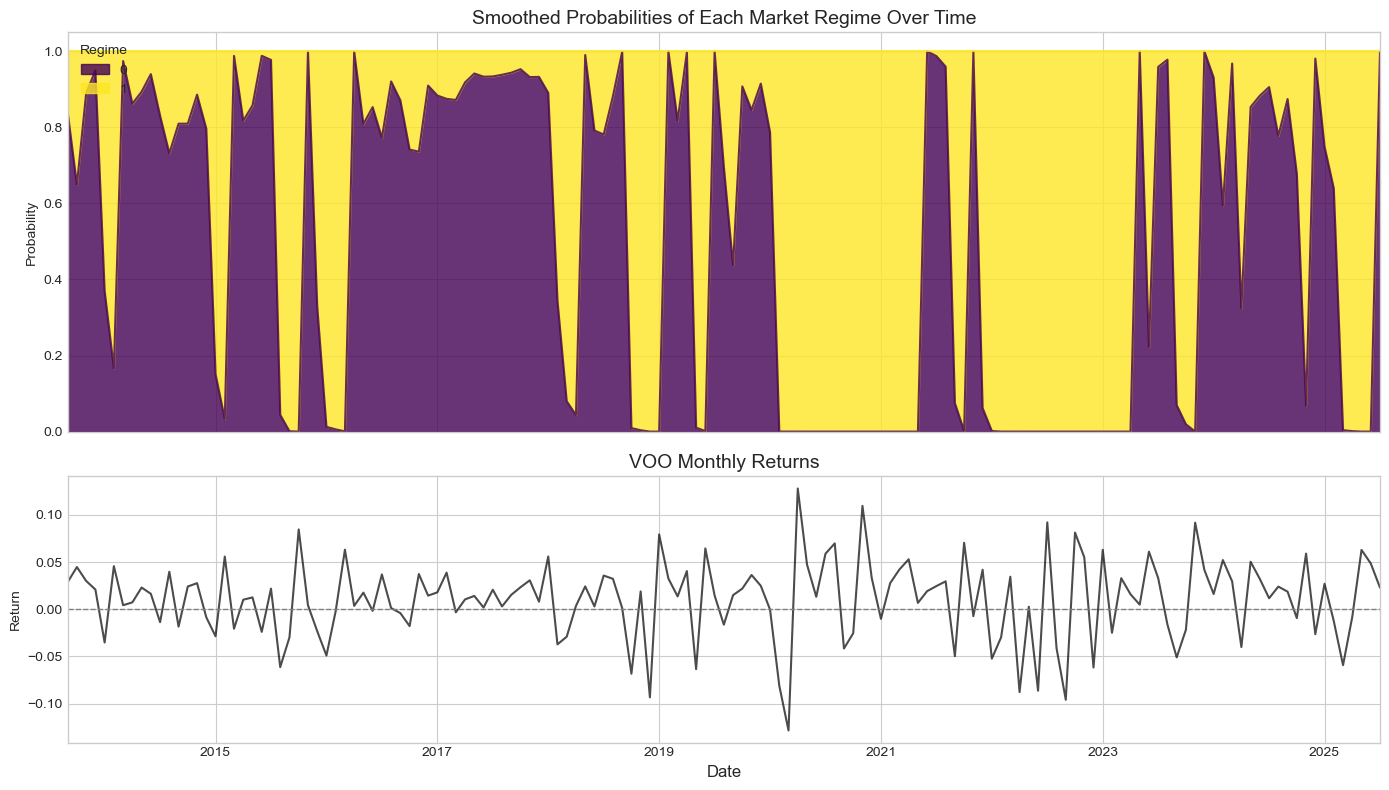

In [132]:
# Get the final, sorted series of regime probabilities
smoothed_probs = best_model_results.smoothed_marginal_probabilities.rename(
    columns=regime_map
).sort_index(axis=1)
regime_series = smoothed_probs.idxmax(axis=1).rename("regime")


# --- Visualize Regime Probabilities vs. Market Returns ---
fig, axes = plt.subplots(
    2, 1, figsize=(14, 8), sharex=True, gridspec_kw={"height_ratios": [3, 2]}
)
smoothed_probs.plot(ax=axes[0], kind="area", stacked=True, colormap="viridis", alpha=0.8)
axes[0].set_title("Smoothed Probabilities of Each Market Regime Over Time", fontsize=14)
axes[0].set_ylabel("Probability")
axes[0].legend(title="Regime", loc="upper left")
returns_final["VOO"].plot(ax=axes[1], color="black", label="VOO Monthly Return", alpha=0.7)
axes[1].set_title("VOO Monthly Returns", fontsize=14)
axes[1].set_ylabel("Return")
axes[1].axhline(0, color="grey", lw=1, linestyle="--")
plt.xlabel("Date", fontsize=12)
plt.tight_layout()
plt.show()

We observe that during periods of high volatility—i.e., large return fluctuations in VOO, such as in 2020 and again in 2022—the model assigns high probability to Regime 1 (yellow). In contrast, during calmer periods with steady returns, such as in 2017, the model identifies Regime 0 (purple).

It seems the Markov regime-switching model successfully separates the time series into economically meaningful regimes.  For each regime, we can now estimate an optimal portfolio.  Using the predicted regime probabilities for the next month, we can blend the regime-specific portfolios into a forward-looking investment strategy that dynamically adjusts to changing market conditions.

### 6. Regime‑Aware Dynamic Strategy

From the previous section, we have a Markov regime-switching model that estimates the probability of being in a low- or high-risk state of the world at any given time. In t his section, we estimate the optimal portfolio for each regime and use these to construct a*one-month forward-looking trading strategy.

To do so, we split the sample based on the regime that is more likely in each period, using the smoothed probabilities from the fitted model.  For each regime-specific subsample, we estimate an optimal portfolio that matches VOO’s global volatility *within that regime*.

This is particularly useful because the Markov model provides predicted probabilities for each regime in the next period—based on current macroeconomic conditions captured by the VIX.  We can use these probabilities to blend the regime-specific portfolios into a forward-looking portfolio strategy that dynamically adjusts to the expected state of the market.

Note that this constitutes an in-sample test, as the probabilities are inferred directly from the fitted model.  In section 8, we will evaluate how this strategy performs out-of-sample.


Now that we have a fitted Markov model with multiple states, we can estimate for *each* regime the efficient frontier and the optimal portfolio that matches VOO's volatility.  We can wrap this within-regime optimization in a function, so we can re-use the approach. 

In [133]:
# We compute a separate optimal portfolio for each identified regime.
def compute_regime_optimal_weights(
    returns,
    regime_labels,
    etf_symbols,
    expense_vector,
    target_volatility,
    n_regimes,
    frontier_points=50,
    min_obs_per_regime=None,
):
    """
    For each hidden-state regime, estimate expected returns / covariance,
    build the efficient frontier, and select the portfolio whose annualised
    volatility matches `target_volatility` (e.g. VOO).

    Parameters
    ----------
    returns : DataFrame
        Monthly returns of the ETFs (index = Date, columns = symbols).
    regime_labels : Series
        Integer regime label for each date (same index as `returns`).
    etf_symbols : list[str]
        Ordered list of ETF tickers (column order used downstream).
    expense_vector : ndarray
        Annualised expense ratio for each ETF, in the same order as `etf_symbols`.
    target_volatility : float
        Benchmark volatility to match when picking the optimal point
        on each regime’s frontier (e.g. VOO’s σᵇ).
    n_regimes : int
        Total number of regimes in the hidden-state model.
    frontier_points : int, default 50
        Number of points generated on each frontier.
    min_obs_per_regime : int or None
        Minimum observations required to estimate a regime frontier.
        Defaults to `max(24, len(etf_symbols))`.

    Returns
    -------
    dict[int, ndarray]     regime → optimal weight vector
    dict[int, DataFrame]   regime → frontier with columns ['volatility', 'expected_return']
    """
    if min_obs_per_regime is None:
        min_obs_per_regime = max(24, len(etf_symbols))

    regime_optimal_weights = {}
    regime_frontiers       = {}
    exp_ret_by_regime      = {}
    cov_by_regime          = {}


    for r in range(n_regimes):
        in_regime = regime_labels == r
        if in_regime.sum() < min_obs_per_regime:
            # Fallback: 100 % VOO if data too sparse
            w_fallback = np.array([1.0 if s == "VOO" else 0.0 for s in etf_symbols])
            regime_optimal_weights[r] = w_fallback
            continue

        # Use only returns from months assigned to regime r
        returns_r = returns.loc[in_regime, etf_symbols]

        # Annualised expected returns and covariance (Ledoit–Wolf shrinkage)
        exp_ret_r = returns_r.mean().values * 12 - expense_vector
        cov_r = LedoitWolf().fit(returns_r.values).covariance_ * 12

        # keep for downstream plotting / diagnostics
        exp_ret_by_regime[r] = exp_ret_r
        cov_by_regime[r]     = cov_r

        # Build the frontier and prune dominated points
        frontier_r = efficient_frontier(cov_r, exp_ret_r, n_points=frontier_points)
        frontier_r = prune_frontier(frontier_r)              

        # Pick portfolio whose volatility is closest to target_volatility
        _, w_opt = select_portfolio(frontier_r, "sigma", target_volatility)

        if w_opt is not None:
            print(f"  > Top 3 ETFs for Regime {r} Portfolio (matching VOO vol):")
            top_indices = np.argsort(w_opt)[-3:][::-1]
            for idx in top_indices:
                if w_opt[idx] > 0.01:
                    symbol = etf_symbols[idx]
                    name = etf_name_map.get(symbol, "Unknown")
                    print(f"    {symbol} ({name}): {w_opt[idx]:.2%}")

            regime_optimal_weights[r] = w_opt
            regime_frontiers[r] = frontier_r
        else:
            w_fallback = np.array([1.0 if s == "VOO" else 0.0 for s in etf_symbols])
            regime_optimal_weights[r] = w_fallback

    return (
        regime_optimal_weights,
        regime_frontiers,
        exp_ret_by_regime,
        cov_by_regime,
    )

# --- Call the weight-selection helper ---
regime_opt_weights, regime_frontiers, exp_ret_by_regime, cov_by_regime = compute_regime_optimal_weights(
    returns           = returns_final, 
    regime_labels     = regime_series,
    etf_symbols       = etf_symbols,
    expense_vector    = expense_vector,
    target_volatility = voo_sigma_annual,  
    n_regimes         = best_k,
    frontier_points   = FRONTIER_POINTS,
)


  > Top 3 ETFs for Regime 0 Portfolio (matching VOO vol):
    MGK (Mega Cap Growth ETF): 100.00%
  > Top 3 ETFs for Regime 1 Portfolio (matching VOO vol):
    VONG (Russell 1000 Growth ETF): 46.04%
    VTIP (Short-Term Inflation-Protected Securities ETF): 34.87%
    IVOV (S&P Mid-Cap 400 Value ETF): 19.09%


We can also visualize the efficient frontiers for each regime, as well as the optimal portfolio.

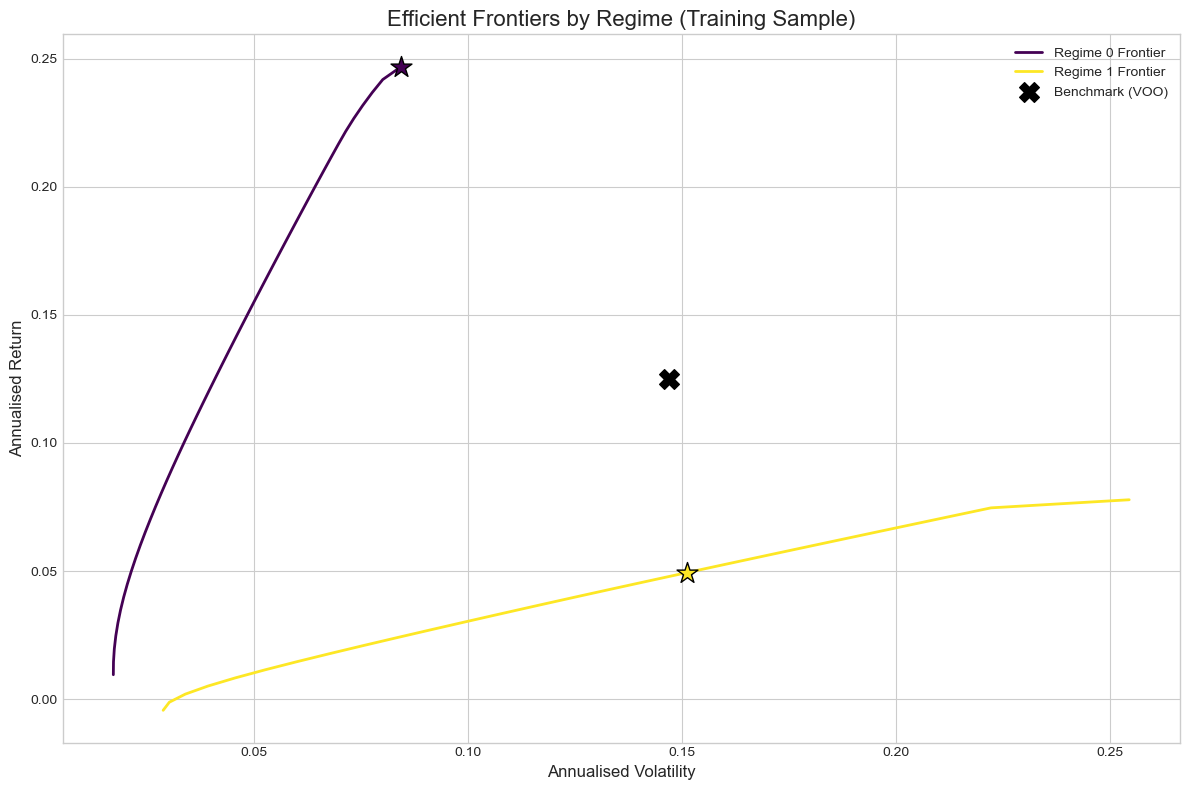

In [134]:
def plot_regime_frontiers(
    regime_frontiers,
    regime_optimal_weights,
    cov_by_regime,
    exp_ret_by_regime,
    etf_symbols,
    benchmark_vol,
    benchmark_ret,
    title="Efficient Frontiers by Regime",
):
    """
    Draw each regime’s efficient frontier plus the selected optimal portfolio,
    and overlay the benchmark (e.g. VOO).

    Parameters
    ----------
    regime_frontiers : dict[int, DataFrame]
        Output from `compute_regime_optimal_weights`.
    regime_optimal_weights : dict[int, ndarray]
        Output from `compute_regime_optimal_weights`.
    cov_by_regime : dict[int, ndarray]
        Covariance matrices used when selecting weights (optional: for stars).
    exp_ret_by_regime : dict[int, ndarray]
        Expected-return vectors used when selecting weights.
    etf_symbols, benchmark_vol, benchmark_ret : see above
    """
    num_regimes = len(regime_frontiers)
    colors = plt.cm.viridis(np.linspace(0, 1, num_regimes))
    plt.figure(figsize=(12, 8))

    for r, frontier in regime_frontiers.items():
        plt.plot(
            frontier["sigma"],
            frontier["mu"],
            label=f"Regime {r} Frontier",
            lw=2,
            color=colors[r],
        )

        # ──────────────────────────────────────────────────────────────────
        # optional star marker (needs cov & mu); skip if not provided
        # ──────────────────────────────────────────────────────────────────
        if cov_by_regime and exp_ret_by_regime:
            w_opt = regime_optimal_weights[r]
            opt_vol = np.sqrt(w_opt.T @ cov_by_regime[r] @ w_opt)
            opt_ret = w_opt.T @ exp_ret_by_regime[r]
            plt.scatter(
                opt_vol,
                opt_ret,
                marker="*",
                s=250,
                color=colors[r],
                edgecolors="black",
                zorder=5,
            )

    # benchmark marker
    if benchmark_vol is not None and benchmark_ret is not None:
        plt.scatter(
            [benchmark_vol],
            [benchmark_ret],
            color="black",
            marker="X",
            s=200,
            label="Benchmark (VOO)",
            zorder=6,
        )

    plt.title(title, fontsize=16)
    plt.xlabel("Annualised Volatility", fontsize=12)
    plt.ylabel("Annualised Return", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# --- Plot the efficient frontiers for each regime ---
plot_regime_frontiers(
    regime_frontiers       = regime_frontiers,     # from compute_regime_optimal_weights
    regime_optimal_weights = regime_opt_weights,   # from compute_regime_optimal_weights
    cov_by_regime          = cov_by_regime,                   # omit → no star markers
    exp_ret_by_regime      = exp_ret_by_regime,                   # omit → no star markers
    etf_symbols            = etf_symbols,
    benchmark_vol          = voo_sigma_annual,
    benchmark_ret          = voo_mu_annual,
    title                  = "Efficient Frontiers by Regime (Training Sample)",
)

The plot shows that the low-volatility regime, Regime 0, has a steep efficient frontier positioned *northwest* of VOO’s global risk-return profile.  We know this is the low-volatility, high-expected-return regime, so it makes sense that this "good" state of the world would feature a steep frontier, where small increases in risk yield disproportionately high returns.  Because conditional risk is limited in this regime, we can afford to overweight historically risky ETFs to maximize expected returns.  This leads the optimizer to fully invest in the Mega Cap Growth ETF (MGK).  Since we are restricted to long-only portfolios, we cannot construct combinations that reach higher volatility levels, even though the portfolio remains below VOO’s global volatility.

In contrast, Regime 1—the "crisis" regime—lies entirely below VOO's global expected return and exhibits a relatively flat efficient frontier, with a wide range of volatility but limited expected return.  In this high-risk state of the world, the optimal portfolio assigns more weight to the Short-Term Inflation-Protected Securities ETF (VTIP).  Since we still target VOO’s volatility level, the optimizer blends VTIP with the Russell 1000 Growth ETF (VONG), and additionally includes the S&P Mid-Cap 400 Value ETF (IVOV).

The inclusion of IVOV is new, but it makes intuitive sense.  During periods of crisis, investors tend to seek assets with strong intrinsic value based on fundamentals, as well as diversification relative to large-cap growth.  The Mid-Cap Value ETF offers both characteristics.

For back-testing, we use the marginal regime probabilities to blend the optimal portfolios for each regime.  This allows us to estimate the monthly in-sample returns of the strategy, which we will use for performance comparison in the sections below.

In [135]:
# At each month, the portfolio is a blend of the regime-optimal portfolios,
# weighted by the smoothed probability of being in each regime at that time.
dynamic_weights_list = []
for t in range(len(returns_final)):
    probs_t = smoothed_probs.iloc[t]
    blended_w = np.zeros(n_assets)
    # Create blended portfolio by weighting each regime's portfolio by its probability
    for i in range(best_k):
        if i in regime_opt_weights:
            blended_w += probs_t[i] * regime_opt_weights[i]
    dynamic_weights_list.append(blended_w / blended_w.sum())

# Calculate the monthly returns of this dynamic portfolio
dynamic_port_returns = np.sum(
    np.array(dynamic_weights_list) * returns_final[etf_symbols].values, axis=1
)
dynamic_returns_series = pd.Series(dynamic_port_returns, index=returns_final.index)

### 7. Final Performance Comparison

In this section, we compare the performance of all portfolio strategies we considered so far.  We define key performance metrics, plot the in-sample cumulative returns of each strategy, and run Monte Carlo return simulations for models that do not rely on dynamic weight adjustments.

There are several key takeaways:

- VOO is a strong benchmark.  Only about half of the models achieve a higher Sharpe ratio, i.e., expected return per unit of risk, and even then, the improvement is not much more than 20–30 percent.
- The static mean-variance optimization and the Markov regime-switching model perform best in the in-sample test.
- Risk Parity and Hierarchical Risk Parity are particularly effective at identifying low-volatility portfolios but tend to produce lower expected returns.
- In our setting, the Black-Litterman model also results in a portfolio allocation that minimizes volatility.

We first calculate in-sample performance measures for the different strategies—specifically total return, annual returns, volatility, and Sharpe ratio.  Since the time series of returns becomes more complete over time, I limit the evaluation to the last seven years and drop the first three years to make sure that all models are fitted on complete data.

In [136]:
# --- Define a Performance Metrics Calculator ---
def calculate_performance_metrics(returns_series):
    """
    Calculates key performance metrics for a series of returns.

    Args:
        returns_series (pd.Series): A series of periodic (e.g., monthly) returns.

    Returns:
        dict: A dictionary of performance metrics.
    """
    if returns_series.empty or returns_series.isnull().all():
        return {
            "Total Return (%)": np.nan, "Annualized Return (%)": np.nan,
            "Annualized Volatility (%)": np.nan, "Sharpe Ratio": np.nan,
        }
    n_periods_per_year = 12  # For monthly returns
    ann_return = ((1 + returns_series.mean()) ** n_periods_per_year - 1) * 100
    ann_vol = returns_series.std() * np.sqrt(n_periods_per_year) * 100
    sharpe = sharpe_ratio(ann_return / 100, ann_vol / 100)
    
    cumulative_returns = (1 + returns_series).cumprod()
    total_return = (cumulative_returns.iloc[-1] - 1) * 100
    
    return {
        "Total Return (%)": total_return,
        "Annualized Return (%)": ann_return,
        "Annualized Volatility (%)": ann_vol,
        "Sharpe Ratio": sharpe,
    }


# --- Prepare All Strategy Returns for Comparison ---
# Use a common lookback window for a fair comparison
lookback_years = 7
end_date_lookback = max(returns_final.index)
start_date_lookback = end_date_lookback - pd.DateOffset(years=lookback_years)
returns_win = returns_final.loc[start_date_lookback:end_date_lookback].dropna(how="all")

# Helper function to calculate strategy returns safely
def get_strategy_returns(weights):
    if weights is not None:
        return returns_win[etf_symbols] @ weights
    return pd.Series(dtype=float, index=returns_win.index)

strategies = {
    "VOO Benchmark": returns_win["VOO"],
    "Static Raw (Risk-Match)": get_strategy_returns(w_sigma_raw),
    "Static L1 Regularized (Risk-Match)": get_strategy_returns(w_sigma_reg_l1),
    "Static Shrunk (Risk-Match)": get_strategy_returns(w_sigma_shrunk),
    "Static Resampled": get_strategy_returns(w_resampled),
    "Black-Litterman": get_strategy_returns(w_bl_opt),
    "Risk Parity": get_strategy_returns(rp_weights),
    "Hierarchical Risk Parity": get_strategy_returns(hrp_weights),
    "HRP-MVO Blended": get_strategy_returns(w_tilt),
    "DCC-GARCH Dynamic": dynamic_returns_series_dcc.loc[start_date_lookback:end_date_lookback],
    "Regime-Aware Dynamic": dynamic_returns_series.loc[start_date_lookback:end_date_lookback],
}

# --- Display Performance Metrics Table ---
all_perf_metrics = {name: calculate_performance_metrics(ret.dropna()) for name, ret in strategies.items()}
all_perf_df = pd.DataFrame(all_perf_metrics).T
print("\n" + "=" * 70)
print("      COMPREHENSIVE STRATEGY PERFORMANCE METRICS")
print("=" * 70)
print(all_perf_df.sort_values(by="Sharpe Ratio", ascending=False))
print("=" * 70 + "\n")


      COMPREHENSIVE STRATEGY PERFORMANCE METRICS
                                    Total Return (%)  Annualized Return (%)  \
Regime-Aware Dynamic                         183.253                 16.988   
Static Raw (Risk-Match)                      174.984                 17.092   
Static L1 Regularized (Risk-Match)           175.398                 17.125   
Static Shrunk (Risk-Match)                   175.398                 17.125   
HRP-MVO Blended                              142.108                 14.609   
Static Resampled                             138.345                 14.598   
VOO Benchmark                                132.864                 14.356   
DCC-GARCH Dynamic                            116.879                 13.293   
Black-Litterman                               16.860                  2.310   
Risk Parity                                   27.640                  4.147   
Hierarchical Risk Parity                       0.542                  0.118   

 

We can also plot the cumulative returns for the strategies over the test period and compare to VOO.

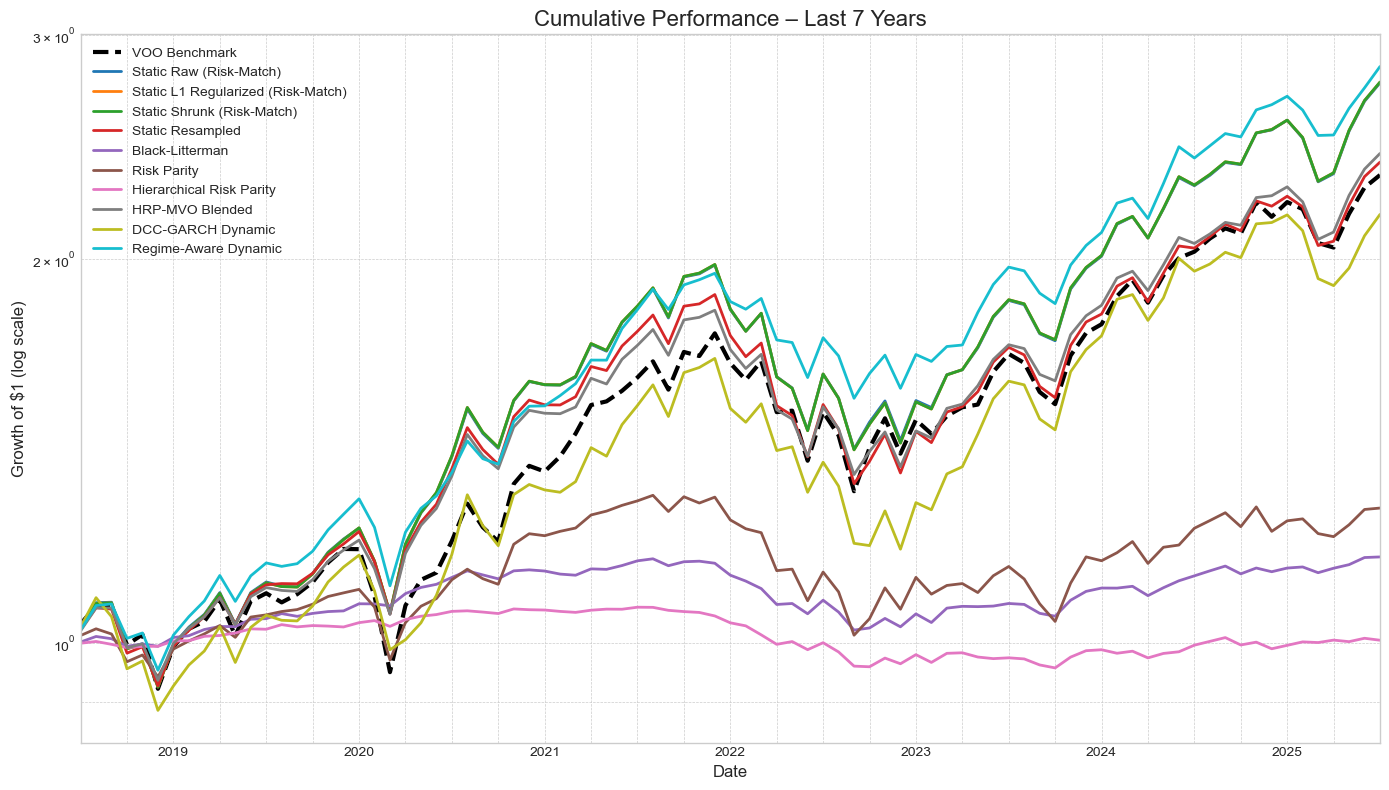

In [137]:
plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(14, 8))
for name, rtn in strategies.items():
    if rtn.dropna().empty: continue
    growth = (1 + rtn).cumprod()
    if name.lower().startswith("voo"):
        growth.plot(ax=ax, label=name, lw=3, linestyle="--", color="black")
    else:
        growth.plot(ax=ax, label=name, lw=2)
ax.set_title(f"Cumulative Performance – Last {lookback_years} Years", fontsize=16)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Growth of $1 (log scale)", fontsize=12)
ax.set_yscale("log")
ax.legend(loc="upper left", fontsize=10)
ax.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

Looking at the cumulative return chart and the performance metrics, we see that VOO performs quite well—but there are models that outperform it.  The static mean-variance optimization methods, as well as the Markov regime-switching model, perform the best.  The HRP blend with the mean-variance optimal portfolio also performs well, but if we are already identifying the mean-variance efficient portfolio, it's unclear why we would blend it again with an HRP portfolio.

On the other hand, the DCC-GARCH model performs slightly worse than VOO, making it less attractive—especially given the high frequency with which the weights oscillate, resulting in frequent rebalancing of the portfolio.  We could potentially improve performance by using weekly or even daily portfolio updates, avoiding the approximation of using the predicted optimal portfolio from the last week of the previous month for the entire following month.  However, this would increase portfolio turnover, and the average investor certainly doesn’t have time for that (I certainly don’t).

Black-Litterman, Risk Parity, and HRP show the weakest performance.  We already know that the mean shrinkage in Black-Litterman causes the algorithm to effectively collapse into a volatility-minimization strategy—similar to the objective followed by Risk Parity and HRP.  These approaches are useful if we are seeking low volatility, but if the goal is to outperform the market, we need to rely on different models.


We can also compare performance based on simulated returns.  I do this only for the models that provide stable portfolio weights—not for DCC-GARCH and the Markov regime-switching model.  For those dynamic models, we would need to build a more complex simulation environment.  For example, for the Markov regime-switching model, we would essentially need to define a full Markov model along with the exogenous predictors, simulate data based on that model, and then apply our approach to check its performance—quite complex, especially if we can instead perform out-of-sample testing in the following section.

In [138]:
# Simulate future returns to see how our portfolios might perform under a wide
# range of possible outcomes, based on the historical return distribution.
print(f"Running Monte Carlo simulation with {MC_SIM_SCENARIOS} scenarios...")
# Use monthly parameters from the full sample for the simulation
monthly_mu_sample = annual_mu_sample / 12
rng = np.random.default_rng(seed=42)  # For reproducibility

# Generate all simulated paths at once for efficiency
simulated_returns_monthly = rng.multivariate_normal(
    mean=monthly_mu_sample,
    cov=sample_cov,  # Use the original sample covariance
    size=(MC_SIM_SCENARIOS, MC_SIM_HORIZON_MONTHS),
)


def simulate_portfolio_performance(weights):
    """Calculates performance metrics from simulated return paths."""
    if weights is None or np.isnan(weights).any():
        return {
            "Mean Ann. Return (%)": np.nan, "Ann. Volatility (%)": np.nan,
            "Sharpe Ratio": np.nan, "VaR 5% (Ann.) (%)": np.nan,
        }
    portfolio_sim_returns = simulated_returns_monthly @ weights
    # Calculate annualized metrics from the simulation results
    mean_monthly_return = np.mean(portfolio_sim_returns)
    std_monthly_return = np.std(portfolio_sim_returns)
    
    annual_mean_return = mean_monthly_return * 12 * 100
    annual_volatility = std_monthly_return * np.sqrt(12) * 100
    sharpe = sharpe_ratio(annual_mean_return/100, annual_volatility/100)
    
    # Value-at-Risk (VaR): The worst expected annualized loss at a 5% confidence level.
    var_5_percent = np.percentile(portfolio_sim_returns, 5) * 12 * 100
    
    return {
        "Mean Ann. Return (%)": annual_mean_return,
        "Ann. Volatility (%)": annual_volatility,
        "Sharpe Ratio": sharpe,
        "VaR 5% (Ann.) (%)": var_5_percent,
    }

# Define weights for all strategies to be simulated
voo_weights = np.array([1.0 if s == "VOO" else 0.0 for s in etf_symbols])
simulation_portfolios = {
    "VOO Benchmark": voo_weights,
    "Static Raw (Risk-Match)": w_sigma_raw,
    "Static L1 Regularized (Risk-Match)": w_sigma_reg_l1,
    "Static Shrunk (Risk-Match)": w_sigma_shrunk,
    "Static Resampled": w_resampled,
    "Black-Litterman": w_bl_opt,
    "Risk Parity": rp_weights,
    "Hierarchical Risk Parity": hrp_weights,
    "HRP-MVO Blended": w_tilt,
}

# Run simulation for each portfolio
sim_results = {name: simulate_portfolio_performance(w) for name, w in simulation_portfolios.items()}
sim_results_df = pd.DataFrame(sim_results).T

print("\n" + "=" * 70)
print(f"      MONTE CARLO SIMULATION SUMMARY ({MC_SIM_HORIZON_MONTHS // 12}-YEAR HORIZON)")
print("=" * 70)
print(sim_results_df.sort_values(by="Sharpe Ratio", ascending=False))
print("=" * 70 + "\n")

Running Monte Carlo simulation with 10000 scenarios...

      MONTE CARLO SIMULATION SUMMARY (10-YEAR HORIZON)
                                    Mean Ann. Return (%)  Ann. Volatility (%)  \
Static Raw (Risk-Match)                           14.463               14.691   
Static L1 Regularized (Risk-Match)                14.464               14.725   
Static Shrunk (Risk-Match)                        14.464               14.725   
HRP-MVO Blended                                   12.494               12.856   
Static Resampled                                  12.740               13.985   
VOO Benchmark                                     12.472               14.703   
Black-Litterman                                    2.014                3.390   
Risk Parity                                        4.453                9.246   
Hierarchical Risk Parity                           0.161                2.380   

                                    Sharpe Ratio  VaR 5% (Ann.) (%)  
Static R

The Monte Carlo simulations confirm what we observed in the in-sample backtesting: the static mean-variance optimization approach outperforms the market portfolio.  To test the robustness of this result, we perform out-of-sample backtesting in the next section.

### Section 8. Back-Testing Framework: Last 3-Year Out-of-Sample

This section evaluates how well our static mean-variance optimization and the Markov regime-switching model perform on unseen data.  These two models showed the best performance in the in-sample period. Specifically, we fit model parameters using the first seven years of data, then let the models run over the following three years.

For the mean-variance optimization, no further action is required after identifying the optimal portfolio—we simply observe how it performs during the test period.  For the Markov model, by contrast, we adjust portfolio weights dynamically based on the predicted regime for each upcoming period during the test window.

Finally, we benchmark both strategies against VOO to determine which model truly performs better out-of-sample.  Focusing on the 2022–2025 period is particularly interesting for the Markov regime-switching model, as this was a time of sharply rising interest rates.  If the Markov model, trained on data from a relatively low interest rate environment, could still outperform during a high-rate regime, we would have a strategy that is robust across changing market conditions. Unfortunately, we will see that this is not the case.

In the end, we conclude that the simple mean-variance optimization approach outperforms both in-sample and out-of-sample.  Quite comforting—simple financial theory still has real-world value!


Before splitting our sample into training and test periods, it makes sense to consider how the market environment has evolved over time. Specifically, we can visualize the interest rate environment using the already collected data for the Fed Funds Rate, the 10-Year Treasury yield, and the 3-Month T-Bill rate.

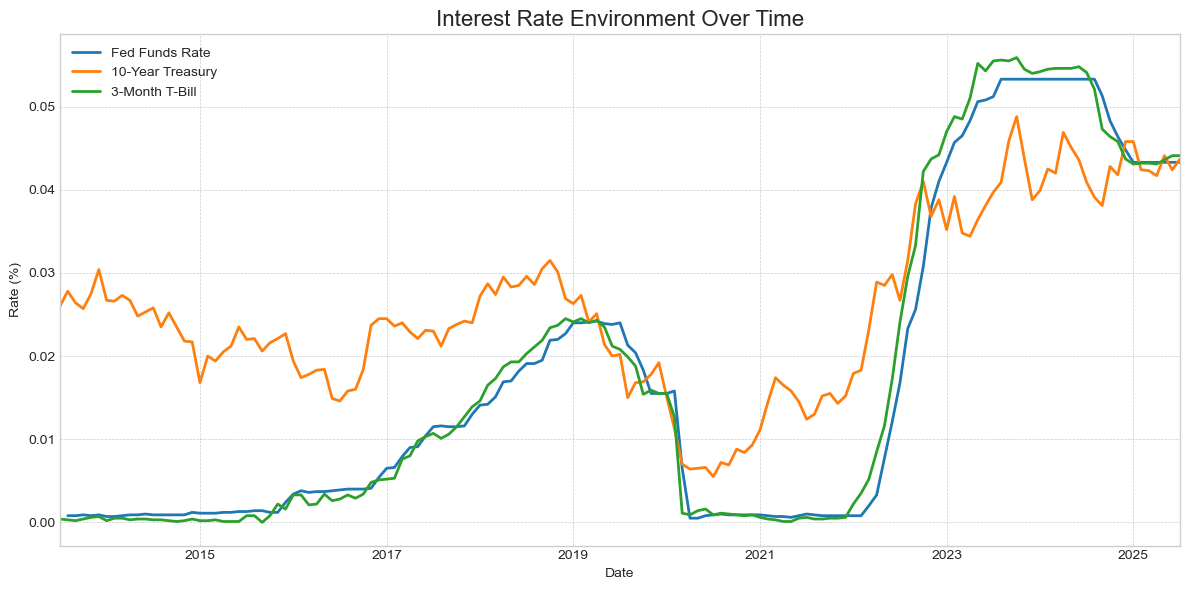

In [139]:
exog_aligned[['FedFunds', '10Y', '3M']].plot(figsize=(12, 6), linewidth=2)

plt.title('Interest Rate Environment Over Time', fontsize=16)
plt.ylabel('Rate (%)')
plt.xlabel('Date')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(["Fed Funds Rate", "10-Year Treasury", "3-Month T-Bill"])
plt.tight_layout()
plt.show()

We can clearly see that the economic environment has changed dramatically over our sample period. Starting from a relatively low interest rate environment with modest increases, rates dropped sharply during the pandemic before rising steeply in 2022. We should therefore be mindful that the training period—covering the first 7 years—captures a low-interest rate regime, while the test period falls within a high-interest rate regime. If our models perform well despite this stark shift, we can be more confident in the robustness of our approach.

We can now split our sample into training period and test period. 

In [140]:
def split_windows(returns, fit_years=7, test_years=3):
    """Return training and testing DataFrames given total monthly returns."""
    end_test   = returns.index.max()
    start_test = end_test - relativedelta(years=test_years) + relativedelta(months=1)
    start_fit  = start_test - relativedelta(years=fit_years)
    train = returns.loc[start_fit : start_test - relativedelta(months=1)]
    test  = returns.loc[start_test : end_test]
    return train, test

#  split sample  (7-year fit  |  3-year test)
train_returns, test_returns = split_windows(returns_final, fit_years=7, test_years=3)
train_exog  = exog_final_lagged[best_exog_vars].loc[train_returns.index] # Select the best exogenous predictor
test_exog   = exog_final_lagged[best_exog_vars].loc[test_returns.index]

Next, we test how the static mean-variance optimization performs out-of-sample.

In [141]:
# Annualiszd mean and covariance from the training sample
exp_ret_train = train_returns.mean().values * 12 - expense_vector
cov_train     = train_returns.cov().values  * 12

# Build the efficient frontier and pick the portfolio
# whose volatility matches the VOO benchmark
ef_train = prune_frontier(
    efficient_frontier(cov_train, exp_ret_train, FRONTIER_POINTS)
)
_, w_raw = select_portfolio(ef_train, "sigma", voo_sigma_annual)

# fallback if optimization failed
if w_raw is None:
    w_raw = np.array([1.0 if s == "VOO" else 0.0 for s in etf_symbols])

# Apply the fixed weights over the entire test period
oos_ret_raw = (test_returns[etf_symbols] @ w_raw).rename("RAW OOS")

# Report Compound Annual Growth Rate ("CAGR"), a an intital check.
cagr = (1 + oos_ret_raw).prod() ** (12 / len(oos_ret_raw)) - 1
print(f"\nRaw-frontier out-of-sample CAGR: {cagr:.2%}")

# Inspect top holdings
top_idx = np.argsort(w_raw)[-3:][::-1]
print("\nTop 3 ETF weights (fixed allocation):")
for idx in top_idx:
    if w_raw[idx] > 0.01:
        sym = etf_symbols[idx]
        name = etf_name_map.get(sym, "Unknown")
        print(f"  {sym} ({name}): {w_raw[idx]:.2%}")


Raw-frontier out-of-sample CAGR: 17.12%

Top 3 ETF weights (fixed allocation):
  VONG (Russell 1000 Growth ETF): 71.55%
  VIG (Dividend Appreciation ETF): 16.20%
  VTIP (Short-Term Inflation-Protected Securities ETF): 12.23%


The optimal portfolio allocation is quite similar to the full in-sample fit, except for the addition of the Dividend Appreciation ETF (VIG), and a shift toward a different type of securities ETF: the Short-Term Inflation-Protected Securities ETF (VTIP).

VIG delivers performance reasonably close to VOO. Given the relatively low interest rates during the training period, the Gordon Growth Model suggests that a strong dividend growth rate $g$ can support performance. The model provides a simple relationship between a stock’s price, expected dividends, discount rate (or required return), and dividend growth:

$$
P = \frac{D_1}{r - g},
$$

and its total derivative is:

$$
dP = -\frac{P}{r - g} \, dr + \frac{P}{r - g} \, dg.
$$

VIG, by design, tracks firms with a consistent history of dividend increases. Thus, a strong dividend growth rate $g$ can help support prices even when the discount rate $r$ is low or only gradually rising, as was the case during the training period.  When the discount rate $r$ rises more sharply, as in the test period, a contemporaneous increase in $g$ can help cushion the impact of higher interest rates.  This may help explain the good out-of-sample performance of the mean-variance optimal portfolio.

Overall, the static mean-variance optimization remains quite consistent in recommending a combination of a high-growth equity ETF and a Treasury ETF.

Next, we fit the Markov regime-switching model on the training period and evaluate its performance during the test period.

The only noteworthy detail here is how we predict transition probabilities out-of-sample for the Markov model.  Once we have a fitted model from the training data, we create a second “test” model that includes the exogenous regressor used to predict the next state—VIX in our case.  We then apply the Hamilton filter using the estimated parameters from the training model to this test model.

The Hamilton filter recursively calculates the probabilities of being in each latent state at time $t$, using all available data up to time $t - 1$.  In essence, it performs Bayesian inference over the latent regime path based on the observed data and the transition structure.  A more detailed explanation can be found in this [R blog post](https://www.r-bloggers.com/2022/02/understanding-hamilton-regime-switching-model-using-r-package/).

In [142]:
# --- fit Markov-Regression on the training window -----------------------
k_regimes = 2                    # or `best_k` if cross-validated earlier
mr_train = MarkovRegression(
    endog = train_returns["VOO"],
    k_regimes = k_regimes,
    trend = "c",
    switching_variance = True,
    exog_tvtp = sm.add_constant(train_exog)
)

res_train = mr_train.fit(search_reps=30, maxiter=300, disp=False)

# --- filter / forecast regimes on the test window --------------------------
mr_test = MarkovRegression(
    endog              = test_returns["VOO"],
    k_regimes          = k_regimes,
    trend              = "c",
    switching_variance = True,
    exog_tvtp          = sm.add_constant(test_exog)
)

# Apply Hamilton Filter with parameters from model fitted on training data
# to predict one-step-head transition probabilities.  Importantly, we
# fix the parameters that are used for the probability model to the 
# results from the model fitted on the training data.
res_test = mr_test.filter(res_train.params) 

# One-step-ahead probabilities:  P(state_t | information_set_{t-1})
pred_probs = res_test.predicted_marginal_probabilities.copy()
pred_probs.index = test_returns.index

We now have the out-of-sample predicted marginal probabilities for each regime. We can visualize how the in-sample regime probabilities compare to VOO’s performance and to the predictor, VIX.

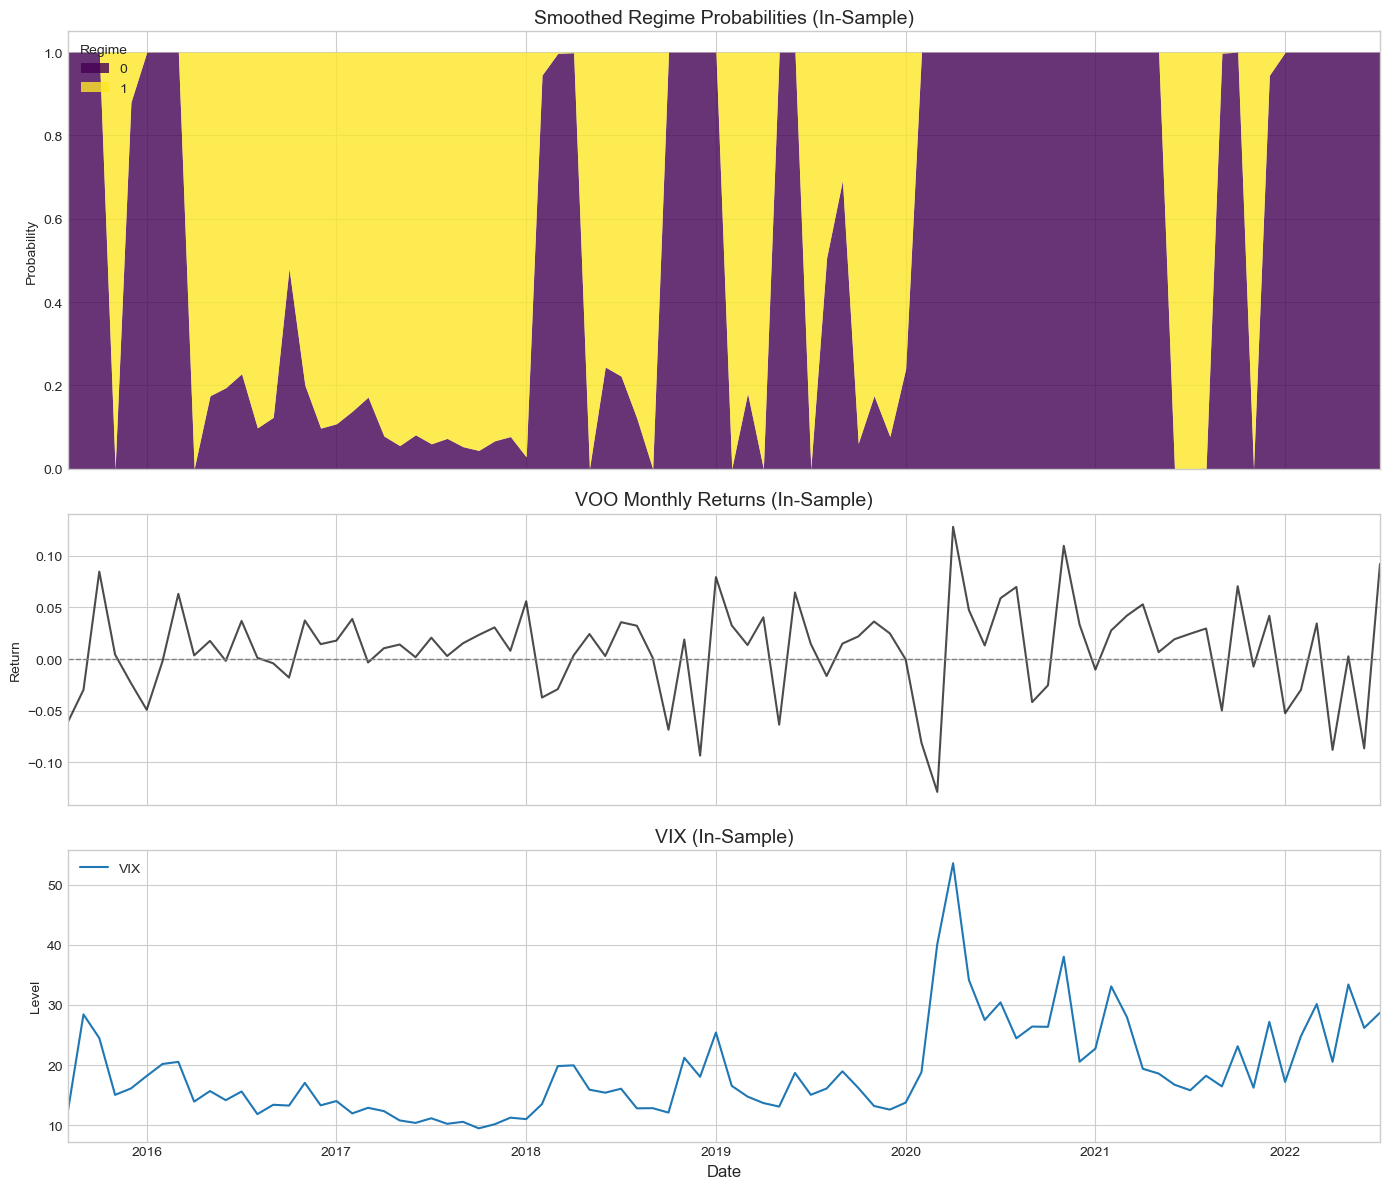

In [143]:
train_probs = res_train.smoothed_marginal_probabilities     # DataFrame k_regimes cols
train_idx   = train_probs.index                             # convenience

fig, axes = plt.subplots(
    3, 1, figsize=(14, 12), sharex=True,
    gridspec_kw={"height_ratios": [3, 2, 2]}
)

# --- Regime probabilities ---------------------------------------------------
train_probs.plot(
    ax=axes[0],
    kind="area",
    stacked=True,
    colormap="viridis",
    alpha=0.8,
    linewidth=0
)
axes[0].set_title("Smoothed Regime Probabilities (In-Sample)", fontsize=14)
axes[0].set_ylabel("Probability")
axes[0].legend(title="Regime", loc="upper left")

# --- VOO returns ------------------------------------------------------------
returns_final.loc[train_idx, "VOO"].plot(
    ax=axes[1],
    color="black",
    label="VOO Monthly Return",
    alpha=0.7
)
axes[1].set_title("VOO Monthly Returns (In-Sample)", fontsize=14)
axes[1].set_ylabel("Return")
axes[1].axhline(0, color="grey", lw=1, linestyle="--")

# --- Exogenous predictor: VIX ----------------------------------------------
train_exog["VIX"].plot(
    ax=axes[2],
    lw=1.5,
    label="VIX"
)
axes[2].set_title("VIX (In-Sample)", fontsize=14)
axes[2].set_ylabel("Level")
axes[2].legend(loc="upper left")

plt.xlabel("Date", fontsize=12)
plt.tight_layout()
plt.show()

It is unfortunate that the regime probabilities are essentially inverted compared to those from the Markov regime-switching model fitted on the entire dataset.  This highlights how sensitive the model is to the inclusion of additional data from the test period.  However, the good news is that VIX still appears to perform well as a predictor—higher VIX levels increase the likelihood of being in Regime 1, the "crisis" state.

We can estimate the optimal portfolio for each regime in the training period and evaluate the out-of-sample performance of the model by blending the optimal portfolios using the out-of-sample regime probabilities at each point in time.

  > Top 3 ETFs for Regime 0 Portfolio (matching VOO vol):
    VIOV (S&P Small-Cap 600 Value ETF): 48.17%
    VTIP (Short-Term Inflation-Protected Securities ETF): 47.15%
    VIG (Dividend Appreciation ETF): 4.68%
  > Top 3 ETFs for Regime 1 Portfolio (matching VOO vol):
    MGK (Mega Cap Growth ETF): 100.00%


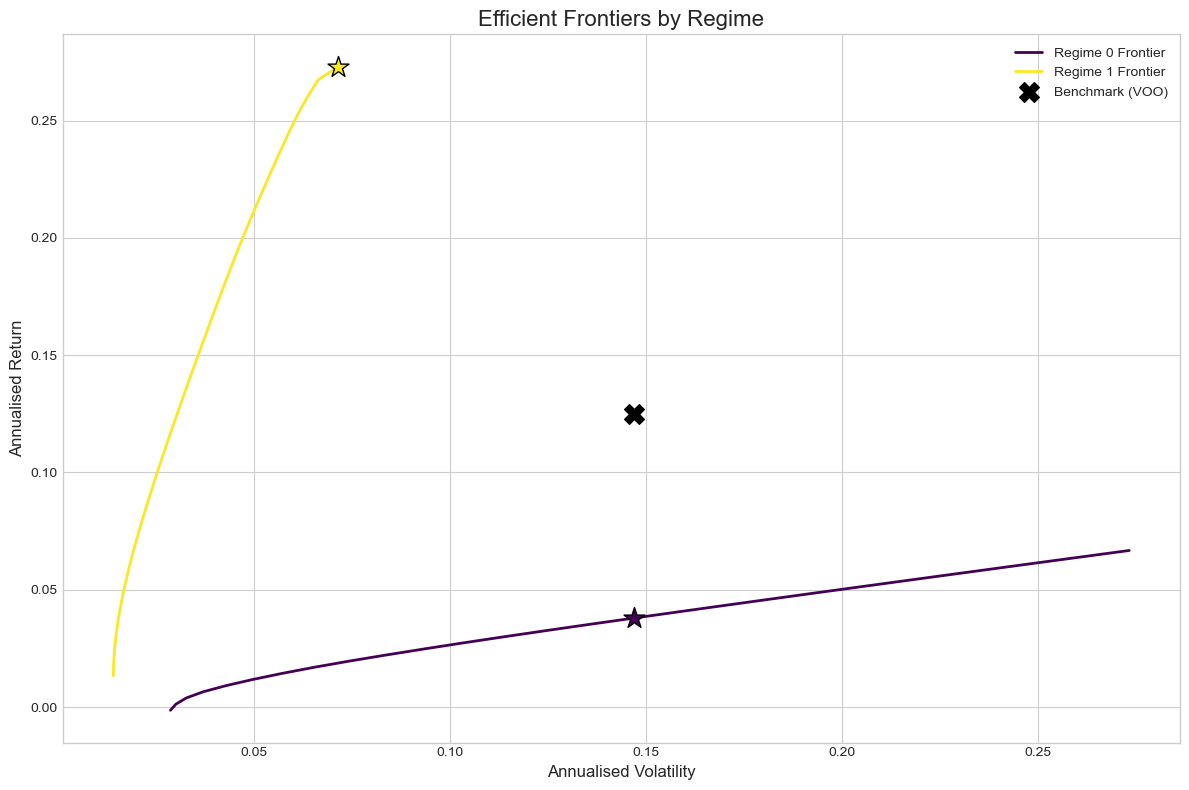

In [144]:
# Convert the training-sample regime probabilities into hard labels
regime_labels_train = (
    res_train.smoothed_marginal_probabilities          # DataFrame: cols 0..k-1
             .idxmax(axis=1)                           # Series of ints
)

# Compute optimal portfolio for each regime
regime_opt_weights, regime_frontiers, exp_ret_by_regime, cov_by_regime = (
    compute_regime_optimal_weights(
        returns           = returns_final.loc[train_returns.index],
        regime_labels     = regime_labels_train,
        etf_symbols       = etf_symbols,
        expense_vector    = expense_vector,
        target_volatility = voo_sigma_annual,          # match VOO's volatility
        n_regimes         = k_regimes,
        frontier_points   = FRONTIER_POINTS,
        min_obs_per_regime=24 
    )
)

# (optional) quick sanity-check plot
plot_regime_frontiers(regime_frontiers, regime_opt_weights,
                       cov_by_regime, exp_ret_by_regime,
                       etf_symbols, voo_sigma_annual, voo_mu_annual)

# --- build the dynamic out-of-sample portfolio ------------------------------
oos_weights = (
    pred_probs
    .apply(
        # blend the regime-specific weights by one-step-ahead probabilities
        lambda p: sum(p[j] * regime_opt_weights[j] for j in range(k_regimes)),
        axis=1, result_type="expand"
    )
    .pipe(lambda w: w.div(w.sum(axis=1), axis=0))      # normalise so weight sum to one
)
oos_weights.columns = etf_symbols

# realised return in month t uses the weights decided *before* that month
oos_port_ret = (
    (oos_weights.shift(1) * test_returns[etf_symbols])
    .sum(axis=1)
    .dropna()
)
oos_port_ret.name = "Regime-Switching OOS"

The optimal portfolios are quite interesting, but also familiar from the in-sample fitting.  Regime 0 invests mostly in the S&P Small-Cap 600 Value ETF (VIOV) and the Short-Term Inflation-Protected Securities ETF (VTIP), and some into the Dividend Appreciation ETF (VIG).  In Regime 1, on the other hand, the portfolio is again fully invested in the Mega Cap Growth ETF (MGK).  However, the regimes are completely swapped—Regime 0 is now the "good" state of the world, yet we invest in a defensive portfolio, while in the "crisis" state we invest in the aggressive Growth ETF.  This inversion is a direct consequence of the marginal regime probabilities being essentially flipped compared to the model fitted on the full dataset.

Now we can plot the regime characteristics from the training data to check whether the regimes make economic sense. As a final check, we can estimate the compound annual growth rate, which provides a direct measure of average performance during the out-of-sample period.

In [145]:
# Pull per-regime monthly parameters from the Markov-regression result
stats = []
for j in range(k_regimes):
    mean_ann = res_train.params[f"const[{j}]"] * 12 * 100            # %
    vol_ann  = (res_train.params[f"sigma2[{j}]"] ** 0.5) * (12 ** 0.5) * 100  # %
    stats.append({"regime": j, "mean": mean_ann, "vol": vol_ann})

stats_df = pd.DataFrame(stats).set_index("regime")

# Order regimes by volatility
order = stats_df.sort_values("vol").index        # e.g. [1, 0] for two regimes

# Print mean return and volatility
table = pd.DataFrame()
for i, r in enumerate(order):
    table[f"Regime {i}"] = [f"{stats_df.loc[r, 'mean']:.1f}%",
                            f"{stats_df.loc[r, 'vol']:.1f}%"]

table.index = ["Annualised Mean (VOO)", "Annualised Volatility (VOO)"]

print("\nCharacteristics of Identified Market Regimes (sorted by volatility):")
print(table)

# CAGR for sanity check
cagr = (1 + oos_port_ret).prod() ** (12 / len(oos_port_ret)) - 1
print(f"\nOut-of-sample CAGR: {cagr:.2%}")


Characteristics of Identified Market Regimes (sorted by volatility):
                            Regime 0 Regime 1
Annualised Mean (VOO)          19.9%     3.8%
Annualised Volatility (VOO)     5.6%    20.2%

Out-of-sample CAGR: 8.95%


The performance is quite sobering, and even VOO’s behavior appears unusual.  Regime 0, which invests in defensive Treasury and value stocks, is associated with low market volatility, while Regime 1—characterized by high market volatility—allocates fully to Mega Cap Growth.  Based on our earlier findings, we would have expected the allocations to be exactly the other way around.  The high-interest-rate environment during the test period seems to have fundamentally shifted the structure of the regimes.

We can also visualize the predicted out-of-sample regime probabilities and plot them against the VIX.


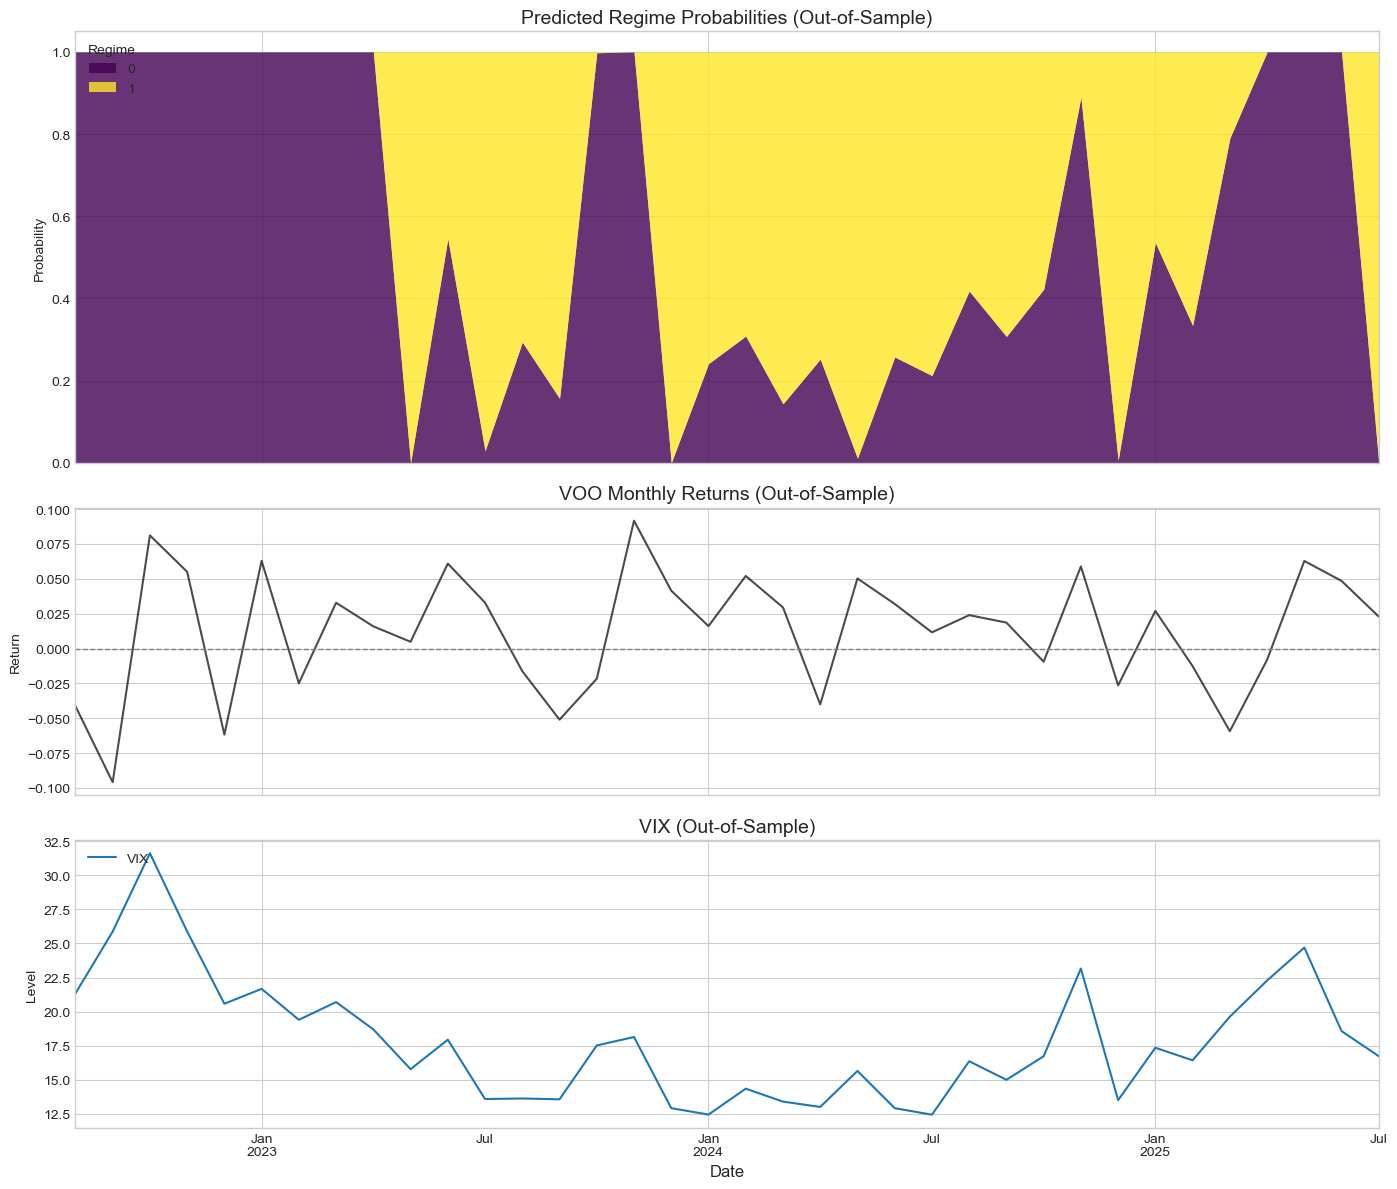

In [146]:
oos_idx = pred_probs.index                                        # convenience

fig, axes = plt.subplots(
    3, 1, figsize=(14, 12), sharex=True,          
    gridspec_kw={"height_ratios": [3, 2, 2]}
)

# --- Regime probabilities ---
pred_probs.plot(
    ax=axes[0],
    kind="area",
    stacked=True,
    colormap="viridis",
    alpha=0.8,
    linewidth=0
)
axes[0].set_title("Predicted Regime Probabilities (Out-of-Sample)", fontsize=14)
axes[0].set_ylabel("Probability")
axes[0].legend(title="Regime", loc="upper left")

# --- VOO returns ---
returns_final.loc[oos_idx, "VOO"].plot(
    ax=axes[1],
    color="black",
    label="VOO Monthly Return",
    alpha=0.7
)
axes[1].set_title("VOO Monthly Returns (Out-of-Sample)", fontsize=14)
axes[1].set_ylabel("Return")
axes[1].axhline(0, color="grey", lw=1, linestyle="--")

# --- Exogenous predictor: VIX ---
test_exog.loc[oos_idx, "VIX"].plot(
    ax=axes[2],
    lw=1.5,
    label="VIX"
)
axes[2].set_title("VIX (Out-of-Sample)", fontsize=14)
axes[2].set_ylabel("Level")
axes[2].legend(loc="upper left")

plt.xlabel("Date", fontsize=12)
plt.tight_layout()
plt.show()

The Markov model does seem to capture economic states reasonably well using the exogenous predictors: when the VIX goes up, we are more likely to be in Regime 0, and vice versa.  However, this is the opposite of what we found in the training period—there, Regime 0 was the "good" state of the world, while Regime 1 represented the "crisis" state with higher market volatility.

VOO also doesn’t cooperate: VOO shows reduced volatility with a high expected return even during periods classified as the "crisis" Regime 1.  This highlights a broader issue with the Markov regime-switching model in the out-of-sample test: we have relatively few observations overall, and the last few years appear to fall outside the typical pattern on which the model was trained.  Ultimately, this helps explain the relatively low out-of-sample return of our model.

We can compare the out-of-sample performance of our two methods and plot the cumulative returns.

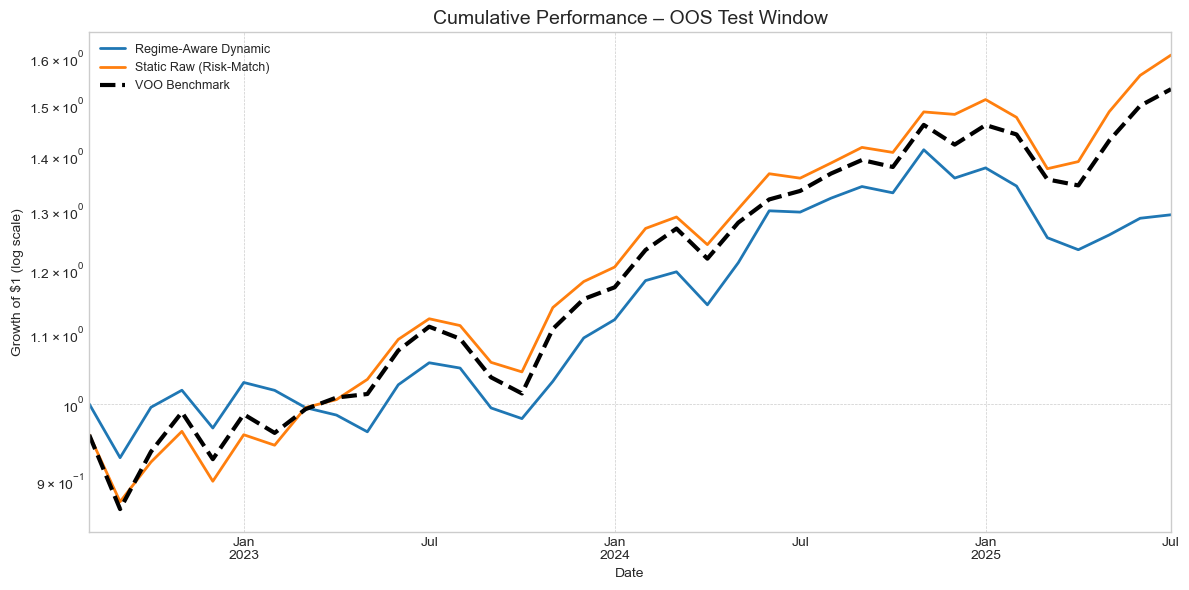


      OUT-OF-SAMPLE PERFORMANCE METRICS  
                         Total Return (%)  Annualized Return (%)  \
Static Raw (Risk-Match)            60.670                 18.360   
VOO Benchmark                      53.390                 16.630   
Regime-Aware Dynamic               29.310                  9.990   

                         Annualized Volatility (%)  Sharpe Ratio  
Static Raw (Risk-Match)                     14.750         1.240  
VOO Benchmark                               15.290         1.090  
Regime-Aware Dynamic                        14.060         0.710  


In [147]:
# --- Gather the two OOS return streams + VOO for reference --------------------
oos_strategies = {
    "Regime-Aware Dynamic": oos_port_ret,    # from the Markov model loop
    "Static Raw (Risk-Match)": oos_ret_raw,  # one-shot raw-frontier weights
    "VOO Benchmark": test_returns["VOO"].loc[oos_port_ret.index],
}

# --- Cumulative-performance plot during the test window -----------------------
plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(12, 6))
for name, ser in oos_strategies.items():
    if ser.dropna().empty:
        continue
    growth = (1 + ser).cumprod()
    style  = {"lw": 3, "linestyle": "--", "color": "black"} if name.startswith("VOO") else {"lw": 2}
    growth.plot(ax=ax, label=name, **style)

ax.set_title("Cumulative Performance – OOS Test Window", fontsize=14)
ax.set_xlabel("Date"); ax.set_ylabel("Growth of $1 (log scale)"); ax.set_yscale("log")
ax.legend(loc="upper left", fontsize=9); ax.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout(); plt.show()

# --- Performance-metrics table ------------------------------------------------
perf = {name: calculate_performance_metrics(ser.dropna()) for name, ser in oos_strategies.items()}
perf_df = pd.DataFrame(perf).T

print("\n" + "="*60)
print("      OUT-OF-SAMPLE PERFORMANCE METRICS  ")
print("="*60)
print(perf_df.sort_values("Sharpe Ratio", ascending=False).round(2))
print("="*60)

The performance of the Markov regime-switching model is quite disappointing, given how well it performed in-sample.  What could explain this?  On the one hand, the recent changes in interest rate policy over the past couple of years are difficult for the model to capture, as it was trained during a relatively low interest rate environment.  There is also the issue that the further we forecast regimes away from the original training period, the more unreliable the model becomes.  In fact, during the first couple of months after fitting the Markov model, we actually *do* outperform VOO!

Lastly, there is also a question of realism: would we really estimate our model once and then keep it unchanged for years, ignoring any recent information?

We can certainly do better.  It would make more economic sense to regularly re-fit the model, incorporating the most recent observations.  Below, I implement this idea: starting with the original training window, I keep the model fixed for several months, then re-estimate it using an updated training set that includes the most recent data.  To determine the best re-fitting frequency, I also conduct hyperparameter tuning—specifically, testing whether we should re-fit every 3, 6, or 12 months.

It is also worth noting that the Markov regime-switching model is quite sensitive to the starting conditions of the optimization.  In other words, results can vary significantly depending on the random seed used.  This is not ideal, but expected given the relatively small number of observations available to estimate the model.  To improve the likelihood of reaching the global optimum, we can increase `search_reps` to explore better starting values and raise `maxiter` to allow for more iterations during optimization.

In [148]:
chunk_grid        = [3, 6, 12]         # months between re-estimations to try
results_dyn       = {}                 # CAGR for Regime-Aware strategy
results_raw       = {}                 # CAGR for Static RAW frontier
best_series_dyn   = None               # will hold return series for best chunk
best_series_raw   = None

for CHUNK_SIZE in chunk_grid:
    print("\n" + "#"*85)
    print(f" BACK-TEST: refit every {CHUNK_SIZE:>2} months ")
    print("#"*85)

    # fresh copies so each grid value starts from the same baseline
    tr_ret   = train_returns.copy()
    tr_exog  = train_exog.copy()

    oos_dyn_list, oos_raw_list = [], []

    test_months = test_returns.index
    for start in range(0, len(test_months), CHUNK_SIZE):
        idx_slice  = test_months[start : start + CHUNK_SIZE]
        if idx_slice.empty: break
        slice_ret  = test_returns.loc[idx_slice]
        slice_exog = test_exog.loc[idx_slice]

        print(f"\n{'='*70}\n  Refit #{start//CHUNK_SIZE+1} | "
              f"chunk = {CHUNK_SIZE} mo | data through {idx_slice[-1]:%Y-%m}\n{'='*70}")

        # ── Static RAW frontier ------------------------------------------------
        exp_raw = tr_ret.mean().values * 12 - expense_vector
        cov_raw = tr_ret.cov().values  * 12
        ef_raw  = prune_frontier(efficient_frontier(cov_raw, exp_raw, FRONTIER_POINTS))
        _, w_raw = select_portfolio(ef_raw, "sigma", voo_sigma_annual)
        if w_raw is None:
            w_raw = np.array([1.0 if s == "VOO" else 0.0 for s in etf_symbols])

        # print top 3 holdings for transparency
        print("  RAW-frontier top holdings:")
        for idx in np.argsort(w_raw)[-3:][::-1]:
            if w_raw[idx] > 0.01:
                sym   = etf_symbols[idx]
                name  = etf_name_map.get(sym, "Unknown")
                print(f"    {sym:<5} ({name}): {w_raw[idx]:.2%}")

        w_raw_df   = pd.DataFrame([w_raw] * len(idx_slice), index=idx_slice, columns=etf_symbols)
        rtn_raw_sl = (w_raw_df.shift(1) * slice_ret[etf_symbols]).sum(axis=1).dropna()
        oos_raw_list.append(rtn_raw_sl)

        # ── Markov model -------------------------------------------------------
        mr_tr  = MarkovRegression(tr_ret["VOO"], k_regimes=2, trend="c",
                                  switching_variance=True, exog_tvtp=sm.add_constant(tr_exog))

        res_tr = mr_tr.fit(search_reps=30, maxiter=300, disp=False)
  
        labels = res_tr.smoothed_marginal_probabilities.idxmax(axis=1)
        # give it the *matching* date index — use the last len(labels) dates
        #labels.index = tr_ret.index[-len(labels):]

        # use only the rows that the model actually used
        #aligned_ret  = tr_ret.loc[labels.index]
        aligned_ret  = tr_ret

        counts = labels.value_counts()
        print("Obs per regime in current training window:")
        for r in range(k_regimes):
            print(f"  Regime {r}: {counts.get(r, 0)} months")
        
        reg_w, *_ = compute_regime_optimal_weights(
            returns=aligned_ret,
            regime_labels=labels,
            etf_symbols=etf_symbols,
            expense_vector=expense_vector,
            target_volatility=voo_sigma_annual,
            n_regimes=2,
            frontier_points=FRONTIER_POINTS,
            min_obs_per_regime=24,
        )

        mr_ts   = MarkovRegression(slice_ret["VOO"], k_regimes=2, trend="c",
                                   switching_variance=True, exog_tvtp=sm.add_constant(slice_exog))
        res_ts  = mr_ts.filter(res_tr.params)
        probs   = res_ts.predicted_marginal_probabilities
        probs.index = idx_slice

        w_dyn   = (probs.apply(lambda p: sum(p[j]*reg_w[j] for j in range(2)),
                               axis=1, result_type="expand")
                          .pipe(lambda w: w.div(w.sum(axis=1), axis=0)))
        w_dyn.columns = etf_symbols
        rtn_dyn_sl = (w_dyn.shift(1) * slice_ret[etf_symbols]).sum(axis=1).dropna()
        oos_dyn_list.append(rtn_dyn_sl)

        # expand training window
        tr_ret  = pd.concat([tr_ret,  slice_ret])
        tr_exog = pd.concat([tr_exog, slice_exog])

    # full OOS series for this chunk size
    series_dyn = pd.concat(oos_dyn_list).rename(f"dyn_{CHUNK_SIZE}")
    series_raw = pd.concat(oos_raw_list).rename(f"raw_{CHUNK_SIZE}")

    cagr_dyn   = (1+series_dyn).prod()**(12/len(series_dyn)) - 1
    cagr_raw   = (1+series_raw).prod()**(12/len(series_raw)) - 1
    results_dyn[CHUNK_SIZE] = cagr_dyn
    results_raw[CHUNK_SIZE] = cagr_raw

    if best_series_dyn is None or cagr_dyn > results_dyn.get(best_series_dyn.name.split('_')[-1], -9):
        best_series_dyn = series_dyn
    if best_series_raw is None or cagr_raw > results_raw.get(best_series_raw.name.split('_')[-1], -9):
        best_series_raw = series_raw

# ── pick optimal chunk sizes --------------------------------------------------
best_chunk_dyn  = max(results_dyn,  key=results_dyn.get)
best_chunk_raw  = max(results_raw,  key=results_raw.get)

print("\n" + "#"*85)
print("Hyper-parameter tuning complete")
for c in chunk_grid:
    print(f"  {c:>2}-month | Regime-Aware CAGR {results_dyn[c]:.2%} "
          f"| RAW CAGR {results_raw[c]:.2%}")
print(f"\n⇒ Best chunk: Regime-Aware = {best_chunk_dyn} mo,  RAW = {best_chunk_raw} mo")
print("#"*85)


#####################################################################################
 BACK-TEST: refit every  3 months 
#####################################################################################

  Refit #1 | chunk = 3 mo | data through 2022-10
  RAW-frontier top holdings:
    VONG  (Russell 1000 Growth ETF): 71.55%
    VIG   (Dividend Appreciation ETF): 16.20%
    VTIP  (Short-Term Inflation-Protected Securities ETF): 12.23%
Obs per regime in current training window:
  Regime 0: 40 months
  Regime 1: 44 months
  > Top 3 ETFs for Regime 0 Portfolio (matching VOO vol):
    MGK (Mega Cap Growth ETF): 100.00%
  > Top 3 ETFs for Regime 1 Portfolio (matching VOO vol):
    VIOV (S&P Small-Cap 600 Value ETF): 48.17%
    VTIP (Short-Term Inflation-Protected Securities ETF): 47.15%
    VIG (Dividend Appreciation ETF): 4.68%

  Refit #2 | chunk = 3 mo | data through 2023-01
  RAW-frontier top holdings:
    VONG  (Russell 1000 Growth ETF): 53.21%
    VIG   (Dividend Appreciation ETF)

It turns out that annual re-fitting is optimal for the static mean-variance optimization, while semi-annual re-fitting works best for the Markov regime-switching model.

There are a few interesting observations from the re-fitting procedure:

* **Static Mean-Variance Optimization:**
  Adding new data over time has little impact on the optimal portfolio. Across most re-fitting periods, the optimizer continues to allocate roughly 70-80% to the Russell 1000 Growth ETF and the remainder to the Short-Term Treasury ETF or the Dividend Appreciation ETF.

* **Markov Regime-Switching Model:**
  For the re-fitted model up to 2023, Regime 0 reflects a defensive portfolio—comprising Value ETFs and Treasury ETFs—while Regime 1 is fully invested in the Mega Cap Growth ETF.  However, by *Refit #3* in July 2023, this pattern reverses. The rising interest rate environment appears to shift market dynamics: Regime 0 now favors full investment in Mega Cap Growth, while Regime 1 adopts a more defensive stance.

* **Later Re-fits and Emerging Trends:**
  After 2023, the regimes alternate again in terms of which one favors the Mega Cap Growth ETF. More interestingly, we begin to see a rising allocation to the Dividend Appreciation ETF (VIG). As discussed above, during periods of rising interest rates, strong dividend growth can help support equity prices by partially offsetting the negative impact of higher discount rates.

As with the in-sample backtesting above, we can now calculate the out-of-sample performance metrics for both the one-shot fitted and the re-fitted models, as well as plot the cumulative returns.

In [149]:
# Gather ALL OOS return streams (align on common index)
oos_strategies = {
    "Dynamic Regime (refit)"      : best_series_dyn,  # refit Markov
    "Dynamic Regime (single fit)" : oos_port_ret,     # one-shot Markov
    "RAW Frontier (refit)"        : best_series_raw,  # refit raw σ-match
    "Static RAW Frontier"         : oos_ret_raw,      # one-shot raw σ-match
    "VOO Benchmark"               : test_returns["VOO"].loc[oos_port_ret.index],
}

# make sure all series share the same date index for plotting / metrics
common_idx = sorted(set().union(*(s.index for s in oos_strategies.values())))
oos_strategies = {k: v.reindex(common_idx).dropna() for k, v in oos_strategies.items()}

# Performance-metrics table
perf = {name: calculate_performance_metrics(ser) for name, ser in oos_strategies.items()}
perf_df = pd.DataFrame(perf).T

print("\n" + "="*70)
print("           OUT-OF-SAMPLE PERFORMANCE METRICS")
print("="*70)
print(perf_df.sort_values("Sharpe Ratio", ascending=False).round(2))
print("="*70)


           OUT-OF-SAMPLE PERFORMANCE METRICS
                             Total Return (%)  Annualized Return (%)  \
RAW Frontier (refit)                   66.420                 19.700   
Static RAW Frontier                    60.670                 18.360   
VOO Benchmark                          53.390                 16.630   
Dynamic Regime (refit)                 31.830                 10.670   
Dynamic Regime (single fit)            29.310                  9.990   

                             Annualized Volatility (%)  Sharpe Ratio  
RAW Frontier (refit)                            14.450         1.360  
Static RAW Frontier                             14.750         1.240  
VOO Benchmark                                   15.290         1.090  
Dynamic Regime (refit)                          13.860         0.770  
Dynamic Regime (single fit)                     14.060         0.710  


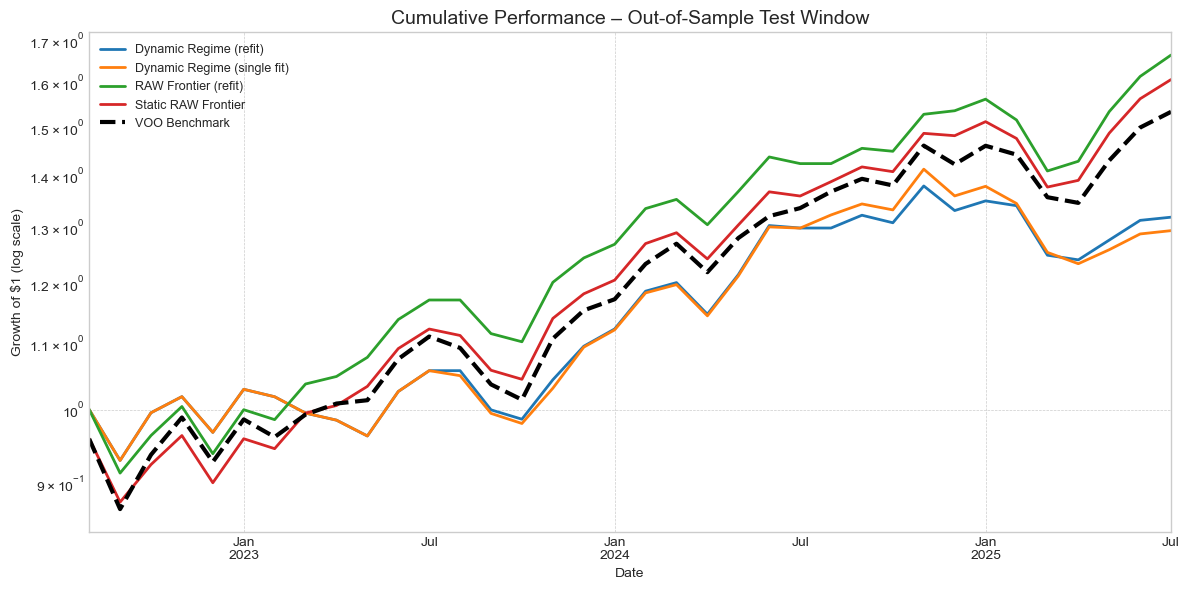

In [150]:
plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(12, 6))

for name, ser in oos_strategies.items():
    growth = (1 + ser).cumprod()
    style  = {"lw": 3, "linestyle": "--", "color": "black"} if name.startswith("VOO") else {"lw": 2}
    growth.plot(ax=ax, label=name, **style)

ax.set_title("Cumulative Performance – Out-of-Sample Test Window", fontsize=14)
ax.set_xlabel("Date")
ax.set_ylabel("Growth of $1 (log scale)")
ax.set_yscale("log")
ax.legend(loc="upper left", fontsize=9)
ax.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

Under the more realistic assumption that we re-estimate the model regularly as new data become available, both the Markov regime-switching model and the mean-variance optimization method perform better.  This highlights the importance of using recent time series data when estimating models—especially given the substantial changes in the interest rate environment, which older model fits may not capture.  We also see how risky it is to extrapolate too far using an outdated model: although the Markov model initially outperforms VOO in the first few months after fitting, this advantage disappears after about half a year.

Overall, simple mean-variance optimization delivers the best results—particularly when we incorporate more recent data and re-fit the model approximately every six months.

### 9. Tool to select optimal portfolio

We now know that the best performance is delivered by the optimal portfolio defined by the simple static mean-variance optimization, using the most recent set of data.  We can set up a simple tool that lets users select their preferences based on expected return or volatility, and then provides the corresponding optimal portfolio on the mean-variance efficient frontier.

In [151]:
# --- Frontier arrays – ensure they exist ---

sigmas = np.asarray(ef_raw["sigma"])
mus = np.asarray(ef_raw["mu"])
weights = np.asarray(ef_raw["weights"])

symbols = globals().get("symbols", etf_symbols)
name_map = globals().get("name_map", etf_name_map)

# --- Build the figure ---

fig = go.FigureWidget()
fig.layout.hovermode = "closest"
fig.layout.clickmode = "event+select"
fig.layout.plot_bgcolor = "white"
fig.layout.paper_bgcolor = "white"

fig.add_scatter(x=sigmas, y=mus, mode="lines", line=dict(color="lightgray"),
                hoverinfo="skip", showlegend=False)

frontier_pts = go.Scatter(
    x=sigmas, y=mus, mode="markers",
    marker=dict(size=7, color="gray", opacity=0.5),
    name="Raw Frontier",
    hoverlabel=dict(bgcolor="white"),
    hovertemplate="σ: %{x:.2%}<br>µ: %{y:.2%}<br>(click to see top weights)<extra></extra>"
)
fig.add_trace(frontier_pts)

fig.add_scatter(x=[voo_sigma_annual], y=[voo_mu_annual], mode="markers",
                marker=dict(symbol="diamond", size=14, color="royalblue", line=dict(width=2, color="black")),
                name="VOO (ref)",
                hoverlabel=dict(bgcolor="white"),
                hovertemplate="VOO\nσ: %{x:.2%}<br>µ: %{y:.2%}<extra></extra>")

mid = len(sigmas) // 2
fig.add_scatter(x=[sigmas[mid]], y=[mus[mid]], mode="markers",
                marker=dict(size=14, color="red", line=dict(width=2, color="black")),
                name="Selected",
                hoverinfo="skip")
sel_idx = len(fig.data) - 1

fig.update_layout(title="Efficient Frontier (Raw Estimates)",
                  xaxis_title="Volatility (σ)", yaxis_title="Expected Return (µ)",
                  height=480)

# --- Top 3 Portfolio Components ---

def format_html(idx: int) -> str:
    w = weights[idx]
    top_idx = np.argsort(w)[-3:][::-1]
    rows = [
        f"<li><b>{symbols[i]}</b> <span style='color:#666'>({name_map.get(symbols[i],'Unknown')})</span>"
        f"<span style='float:right'>{w[i]:.2%}</span></li>"
        for i in top_idx if w[i] > 0.001
    ]
    return (
        "<div style='font-family:Arial, sans-serif; font-size:14px; line-height:1.4; max-width:420px;'>"
        f"<h4 style='margin:4px 0 8px 0; font-size:15px;'>Top 3 ETFs – Frontier Point {idx+1}</h4>"
        "<ul style='list-style:none; padding-left:0; margin:0;'>" + "\n".join(rows) + "</ul></div>"
    )

out = HTML()

# --- Sliders ---

mu_slider = FloatSlider(value=mus[mid], min=mus.min(), max=mus.max(), step=0.0005,
                        description="Target µ", readout_format=".2%", continuous_update=False,
                        layout=dict(width="450px"))

sigma_slider = FloatSlider(value=sigmas[mid], min=sigmas.min(), max=sigmas.max(), step=0.0005,
                           description="Target σ", readout_format=".2%", continuous_update=False,
                           layout=dict(width="450px"))

# --- Sync logic ---

def move_to_index(idx: int):
    with fig.batch_update():
        fig.data[sel_idx].x = [sigmas[idx]]
        fig.data[sel_idx].y = [mus[idx]]
    mu_slider.value = mus[idx]
    sigma_slider.value = sigmas[idx]
    out.value = format_html(idx)

move_to_index(mid)

def on_mu_change(change):
    if change["name"] == "value":
        idx = int(np.argmin(np.abs(mus - change["new"])))
        move_to_index(idx)

def on_sigma_change(change):
    if change["name"] == "value":
        idx = int(np.argmin(np.abs(sigmas - change["new"])))
        move_to_index(idx)

mu_slider.observe(on_mu_change, names="value")
sigma_slider.observe(on_sigma_change, names="value")

fig.data[1].on_click(lambda trace, points, selector: move_to_index(points.point_inds[0]) if points.point_inds else None)

# --- Snap-to button for VOO mu and sigma ---

snap_button = Button(description="Snap to VOO", button_style="info")
snap_criterion = Dropdown(
    options=[("Match µ (return)", "mu"), ("Match σ (volatility)", "sigma")],
    value="mu",
    layout=dict(width="180px")
)

def on_snap(_):
    if snap_criterion.value == "mu":
        idx = int(np.argmin(np.abs(mus - voo_mu_annual)))
    else:
        idx = int(np.argmin(np.abs(sigmas - voo_sigma_annual)))
    move_to_index(idx)

snap_button.on_click(on_snap)

# --- Display ------------------------------------------------------

display(VBox([
    fig,
    mu_slider,
    sigma_slider,
    HBox([snap_button, snap_criterion]),
    out
]))

    'data': [{'hoverinfo': 'skip',
              'line': {'color': 'lightgray'},…